# Specific things to investigate/visualize: Time-Based, Score-Based, Home/Away-Based, Individual-Dynamic-Based

## Home vs Away similar time/score, similar play with same result, difference in change in wp
## Difference in changes of wp in each quarter
## Difference in changes of wp in 2 score, 1 score, and tied situations
## Difference in changes of wp for 1,2,3 consecutive scores
## Difference in changes of wp for /away TD

### Need too eventually combine multiple of these dynamics to really dig deep... Home, 4th quarter, 1 score game check the difference between offensive and defensive touchdowns, and the same for away and vice versa for both etc.

### Also Scatterplots of many of the dynamic features showing the home and away changes in wp like above, also need to  be combined with things like different quarters, different score differential, time remaining etc

               game_dynamic  mean_home_wp_change  max_home_wp_change  \
0        big_offensive_play             0.001290            0.782775   
1        big_defensive_play             0.000206            0.727836   
2                    off_td             0.000663            0.609143   
3                    def_td             0.000907            0.505293   
4               big_st_play             0.000459            0.376399   
5              st_return_td             0.001043            0.154209   
6      high_leverage_moment             0.000580            0.758611   
7          drought_end_play             0.000139            0.619203   
8          home_csum_scores             0.002687            0.929145   
9          away_csum_scores            -0.001862            0.907566   
10      home_csum_def_stops             0.003141            0.907566   
11      away_csum_def_stops            -0.002416            0.907566   
12    home_csum_first_downs             0.001048            0.79

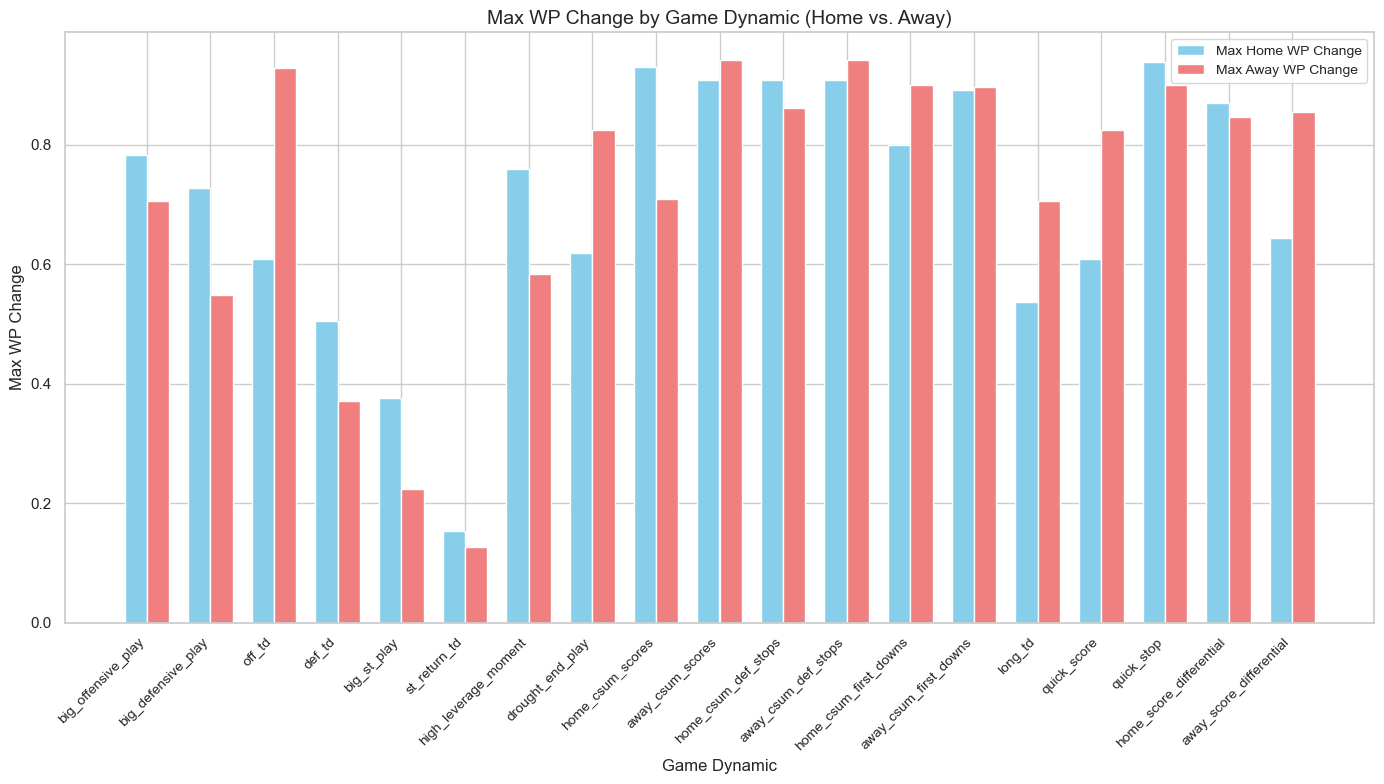

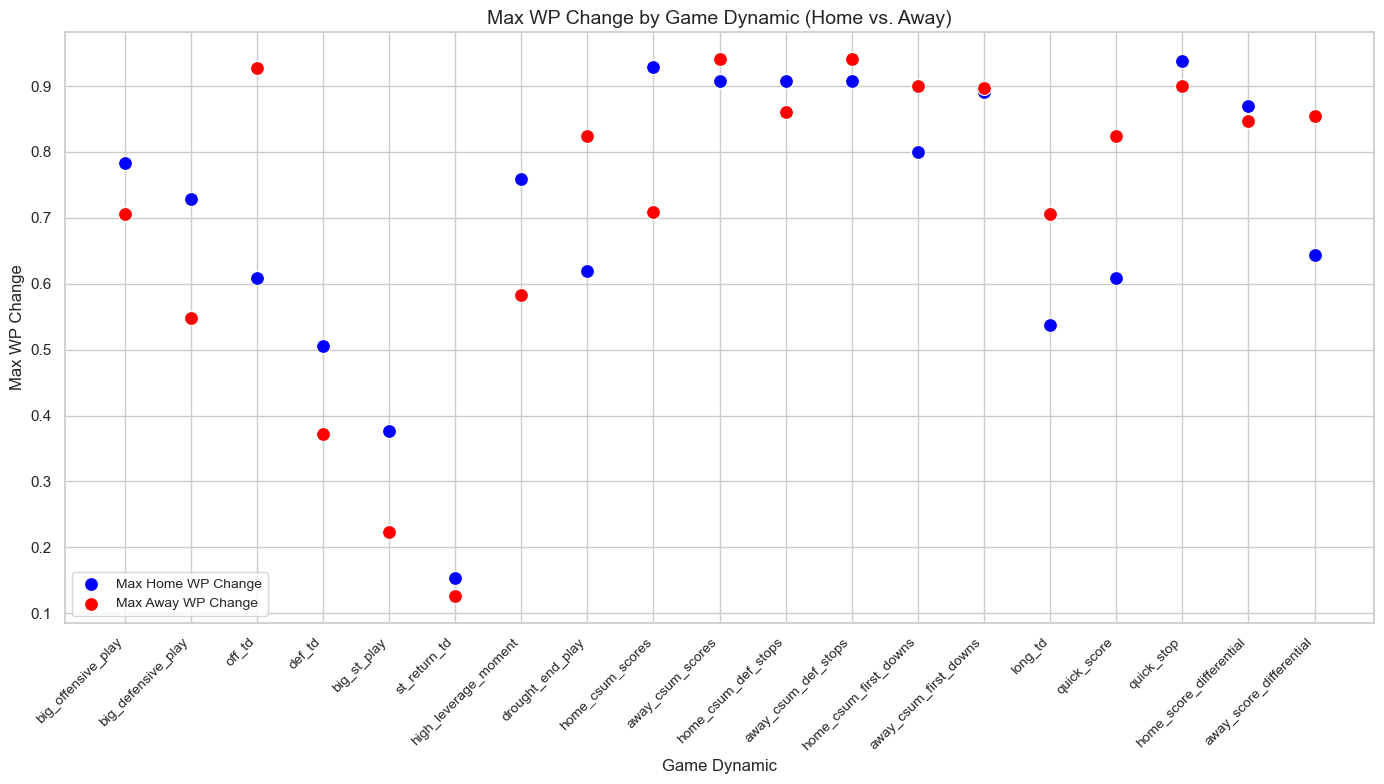

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df = pd.read_csv('NFL_pbp_2009-2019.csv', low_memory=False)

threshold = 100000
df['field_goal_result'].fillna('none', inplace=True)
dfV2 = df.loc[:, df.isnull().sum() < threshold]
missing_values = dfV2.isnull().sum()

statistical_cols = ['play_id', 'game_id', 'home_team', 'away_team', 'posteam', 
                    'defteam', 'side_of_field', 'yardline_100', 'half_seconds_remaining', 
                    'game_seconds_remaining', 'game_half', 'drive', 'qtr', 'down', 'goal_to_go', 'time', 
                    'yrdln', 'ydstogo', 'ydsnet', 'desc', 'play_type', 'yards_gained', 'home_timeouts_remaining', 
                    'away_timeouts_remaining', 'total_home_score',  'total_away_score', 'score_differential', 'home_wp', 'away_wp', 'ep']

game_dynamics_cols = [
    'punt_blocked', 'first_down_rush', 'first_down_pass', 'first_down_penalty', 'third_down_converted',
    'third_down_failed', 'fourth_down_converted', 'fourth_down_failed', 'incomplete_pass', 'interception',
    'fumble_forced', 'fumble_not_forced', 'fumble_out_of_bounds', 'solo_tackle', 'safety', 'penalty',
    'tackled_for_loss', 'fumble_lost', 'own_kickoff_recovery', 'own_kickoff_recovery_td', 'qb_hit',
    'rush_attempt', 'pass_attempt', 'sack', 'touchdown', 'pass_touchdown', 'rush_touchdown', 'field_goal_result',
    'return_touchdown', 'extra_point_attempt', 'two_point_attempt', 'field_goal_attempt', 'kickoff_attempt',
    'punt_attempt', 'fumble', 'complete_pass', 'shotgun', 'no_huddle', 'punt_inside_twenty', 'kickoff_inside_twenty']

columns_to_keep = statistical_cols + game_dynamics_cols
dfV3 = dfV2[columns_to_keep]

dfV4 = dfV3.drop(['play_id', 'game_seconds_remaining', 'fumble_forced'], axis=1)
dfV4 = dfV4.dropna(subset=['down', 'defteam', 'posteam'])
dfV4 = dfV4.reset_index(drop=True)

# Indicators for if within last 2 minutes of the half and the whole game
dfV4['close_to_end_of_half'] = (dfV4['half_seconds_remaining'] <= 120).astype(int)
dfV4['close_to_end_of_game'] = ((dfV4['half_seconds_remaining'] <= 120) & (dfV4['game_half'] == 'Half2')).astype(int)

# Indicator for if the touchdown was for the away or home team
dfV4['home_td'] = ((dfV4['touchdown'] == 1) & (dfV4['posteam'] != dfV4['away_team'])).astype(int)
dfV4['away_td'] = ((dfV4['touchdown'] == 1) & (dfV4['posteam'] != dfV4['home_team'])).astype(int)

# Trackers for the difference in both teams' win probability after each play
dfV4['home_wp_change'] = dfV4['home_wp'].diff().fillna(0)
dfV4['away_wp_change'] = dfV4['away_wp'].diff().fillna(0)

# Indicator for turnover
dfV4['turnover'] = (
    (dfV4['safety'] == 1) |
    (dfV4['interception'] == 1) |
    (dfV4['fumble_lost'] == 1) |
    ((dfV4['fourth_down_converted'] == 0) & (dfV4['down'] == 4))
).astype(int)

# Drive time - Added drive ended indicator to help - Manually resets after end of game, half, and change of possession
dfV4['drive_ended'] = (
    (dfV4['posteam'] != dfV4['posteam'].shift(1)) |  
    (dfV4['game_id'] != dfV4['game_id'].shift(1)) |  
    dfV4['desc'].str.contains('END GAME', na=False) |  
    dfV4['desc'].str.contains('END QUARTER', na=False)  
).astype(int)
dfV4['drive'] = (
    (dfV4['posteam'].ne(dfV4['posteam'].shift())) |
    (dfV4['game_id'].ne(dfV4['game_id'].shift()))
).cumsum()
dfV4['drive_time_seconds'] = (
    dfV4.groupby(['game_id', 'drive'])['half_seconds_remaining']
    .transform('first') - dfV4['half_seconds_remaining']
)
dfV4['drive_time_seconds'] = dfV4.apply(
    lambda row: 0 if row['drive_ended'] == 1 else row['drive_time_seconds'], axis=1
)
dfV4['drive_time_seconds'] = dfV4.groupby(['game_id', 'drive'])['drive_time_seconds'].cumsum()

# Indicator for long touchdowns
dfV4['long_td'] = ((dfV4['touchdown'] == 1) & (dfV4['yards_gained'] >= 50)).astype(int)

# Trackers for score differentials and lead changes
dfV4['home_score_differential'] = dfV4['total_home_score'] - dfV4['total_away_score']
dfV4['away_score_differential'] = -dfV4['home_score_differential']
dfV4['lead_change'] = ((dfV4['home_score_differential'].diff() < 0) &
                       (dfV4['home_score_differential'].shift() * dfV4['home_score_differential'] < 0)).astype(int)

# Combining first down indicators
dfV4['first_down'] = ((dfV4['first_down_pass'] == 1) | (dfV4['first_down_rush'] == 1) | (dfV4['first_down_penalty'] == 1)).astype(int)

# Indicators for scoring drives - Removing
dfV4['home_scoring_drive'] = (
    (dfV4['home_td'] == 1) 
).astype(int)
dfV4['away_scoring_drive'] = (
    (dfV4['away_td'] == 1) 
).astype(int)

# Helper for consecutive scoring events - Remove Later!!!!!!!!!!!!!!
dfV4['home_scoring_events'] = (
    (dfV4['posteam'] != dfV4['away_team']) & 
    ((dfV4['home_td'] == 1) | (dfV4['field_goal_result'] == 'made'))
).astype(int)
dfV4['away_scoring_events'] = (
    (dfV4['posteam'] != dfV4['home_team']) & 
    ((dfV4['away_td'] == 1) | (dfV4['field_goal_result'] == 'made'))
).astype(int)

# Consecutive Scoring Events + Helper function 
def calc_consecutive_cumsum_with_game_reset(series, reset_series, game_ids):
    cumsum = 0
    consecutive = []
    prev_game_id = None  
    
    for i in range(len(series)):
        if game_ids[i] != prev_game_id:
            cumsum = 0 
        if reset_series[i] == 1:  
            cumsum = 0
        if series[i] == 1:  
            cumsum += 1
        consecutive.append(cumsum)
        prev_game_id = game_ids[i]  
    return consecutive

dfV4['home_csum_scores'] = calc_consecutive_cumsum_with_game_reset(
    dfV4['home_scoring_events'], dfV4['away_scoring_events'], dfV4['game_id']
)
dfV4['away_csum_scores'] = calc_consecutive_cumsum_with_game_reset(
    dfV4['away_scoring_events'], dfV4['home_scoring_events'], dfV4['game_id']
)

#Consecutive defensive stops
dfV4['home_def_stop'] = (
    (dfV4['posteam'] != dfV4['home_team']) &  ((dfV4['punt_attempt'] == 1) |  (dfV4['turnover'] == 1)) & 
    ~dfV4['field_goal_result'].isin(['made'])  
).astype(int)
dfV4['away_def_stop'] = (
    (dfV4['posteam'] != dfV4['away_team']) & ((dfV4['punt_attempt'] == 1) |  (dfV4['turnover'] == 1)) & 
    ~dfV4['field_goal_result'].isin(['made'])
).astype(int)

def calc_consecutive_defensive_stops_with_game_reset(series, reset_series, game_ids):
    cumsum = 0
    consecutive = []
    prev_game_id = None  
    for i in range(len(series)):
        if game_ids[i] != prev_game_id:
            cumsum = 0
        if reset_series[i] == 1:
            cumsum = 0
        if series[i] == 1:
            cumsum += 1
        consecutive.append(cumsum)
        prev_game_id = game_ids[i]  
    return consecutive

dfV4['home_csum_def_stops'] = calc_consecutive_defensive_stops_with_game_reset(
    dfV4['home_def_stop'], dfV4['away_scoring_events'], dfV4['game_id']
)
dfV4['away_csum_def_stops'] = calc_consecutive_defensive_stops_with_game_reset(
    dfV4['away_def_stop'], dfV4['home_scoring_events'], dfV4['game_id']
)

# Home/Away Drive Numbers
dfV4['away_drive_number'] = (
    dfV4.loc[dfV4['posteam'] != dfV4['home_team']]
    .groupby('game_id')['drive_ended'].cumsum()
)
dfV4['home_drive_number'] = (
    dfV4.loc[dfV4['posteam'] == dfV4['home_team']]
    .groupby('game_id')['drive_ended'].cumsum()
)

# High_leverage_play moment, game on the line in a 1 score game
dfV4['high_leverage_moment'] = (
    (dfV4['down'].isin([3, 4])) & 
    (abs(dfV4['score_differential']) <= 8) & 
    (dfV4['qtr'] >= 4)
).astype(int)

# Drought Ending score
dfV4['drought_end_play'] = (
    ((dfV4['away_csum_scores'].shift(1) >= 2) & (dfV4['away_csum_scores'] == 0) & (dfV4['home_scoring_events'] == 1)) |
    ((dfV4['home_csum_scores'].shift(1) >= 2) & (dfV4['home_csum_scores'] == 0) & (dfV4['away_scoring_events'] == 1))
).astype(int)

# Defensive touchdown
dfV4['def_td'] = (
    ((dfV4['fumble'] == 1) & (dfV4['return_touchdown'] == 1)) |
    ((dfV4['interception'] == 1) & (dfV4['return_touchdown'] == 1))
).astype(int)

# Defensive touchdown
dfV4['off_td'] = (
    (dfV4['pass_touchdown'] == 1) | (dfV4['rush_touchdown'] == 1)
).astype(int)

# Special Teams touchdown
dfV4['st_return_td'] = (
    ((dfV4['kickoff_attempt'] == 1) & (dfV4['return_touchdown'] == 1)) | 
    ((dfV4['punt_attempt'] == 1) & (dfV4['return_touchdown'] == 1))  
).astype(int)

# Big special teams play...punt blocked, field goal blocked, return_touchdown, kick recovery, pin team near endzone
dfV4['big_st_play'] = (
    (dfV4['punt_blocked'] == 1) | 
    (dfV4['field_goal_result'] == 'blocked') | 
    (dfV4['own_kickoff_recovery'] == 1) | 
    (dfV4['st_return_td'] == 1) | 
    (dfV4['kickoff_inside_twenty'] == 1) | 
    (dfV4['punt_inside_twenty'] == 1)
).astype(int)

# Scoring type differentiatior, touchdowns should hold more weight than a field goal, other types may hold more weight also
dfV4['scoring_type'] = np.select(
    [
        dfV4['field_goal_result'] == 'made',
        dfV4['off_td'] == 1,
        dfV4['def_td'] == 1,
        dfV4['st_return_td'] == 1,
    ],
    ['fg', 'off_td', 'def_td', 'st_td'],
    default='none'
)

# Indicator for big offensive play
dfV4['big_offensive_play'] = (
        (dfV4['yards_gained'] >= 40) |
        (dfV4['long_td'] == 1) |
        ((dfV4['high_leverage_moment'] == 1) & (dfV4['off_td'] == 1))
).astype(int)

# Indicator for big defensive play
dfV4['big_defensive_play'] = (
    (dfV4['sack'] == 1) |
    (dfV4['tackled_for_loss'] == 1) |
    ((dfV4['high_leverage_moment'] == 1) & (dfV4['def_td'] == 'def_td')) |
    (dfV4['scoring_type'] == 'def_td')
).astype(int)

#Quick Score and Quick Stop
dfV4['quick_score'] = ((dfV4['drive_time_seconds'] < 180) & 
                               ((dfV4['touchdown'] == 1) | (dfV4['field_goal_result'] == 'made'))).astype(int)

dfV4['total_drive_time'] = dfV4.groupby('drive')['drive_time_seconds'].transform('last') 
dfV4['quick_stop'] = ((dfV4['total_drive_time'] < 180) & (dfV4['scoring_type'] == 'none')).astype(int)


# Consecutive first downs
dfV4['home_csum_first_downs'] = 0
dfV4['away_csum_first_downs'] = 0
dfV4['home_csum_first_downs'] = (
    dfV4.groupby(['home_team', 'away_team', 'home_drive_number'])['first_down']
    .cumsum()
    .where(dfV4['posteam'] != 'away_team', 0)
)
dfV4['away_csum_first_downs'] = (
    dfV4.groupby(['home_team', 'away_team', 'away_drive_number'])['first_down']
    .cumsum()
    .where(dfV4['posteam'] != 'home_team', 0)
)


columns_to_remove = [
    'ep', 'punt_blocked', 'first_down_rush', 'first_down_pass', 
    'third_down_converted', 'third_down_failed', 'fourth_down_converted', 
    'fourth_down_failed', 'incomplete_pass', 'interception', 'fumble_not_forced', 
    'fumble_out_of_bounds', 'solo_tackle', 'safety', 'penalty', 'tackled_for_loss', 
    'fumble_lost', 'own_kickoff_recovery', 'own_kickoff_recovery_td', 'qb_hit', 
    'rush_attempt', 'pass_attempt', 'sack', 'extra_point_attempt', 'two_point_attempt', 
    'field_goal_attempt', 'kickoff_attempt', 'punt_attempt', 'fumble', 'pass_touchdown', 'rush_touchdown'
    'complete_pass', 'shotgun', 'home_scoring_drive', 'away_scoring_drive','home_scoring_events','away_scoring_events',
    'rush_touchdown', 'field_goal_result', 'return_touchdown', 'complete_pass', 'no_huddle', 'punt_inside_twenty', 'kickoff_inside_twenty',
    'time', 'yrdln', 'ydstogo', 'ydsnet', 'desc', 'side_of_field', 'yardline_100', 'desc', 'drive', 'game_half', 'drive_ended', 'drive_time_seconds',
    'touchdown', 'score_differential', 'total_drive_time', 'game_id'
]

dfV5 = dfV4.drop(columns=columns_to_remove, errors='ignore')

dynamics = [
    ('big_offensive_play', dfV5['big_offensive_play'] == 1),
    ('big_defensive_play', dfV5['big_defensive_play'] == 1),
    ('off_td', dfV5['off_td'] == 1),
    ('def_td', dfV5['def_td'] == 1),
    ('big_st_play', dfV5['big_st_play'] == 1),
    ('st_return_td', dfV5['st_return_td'] == 1),
    ('high_leverage_moment', dfV5['high_leverage_moment'] == 1),
    ('drought_end_play', dfV5['drought_end_play'] == 1),
    ('home_csum_scores', dfV5['home_csum_scores'] == 1),
    ('away_csum_scores', dfV5['away_csum_scores'] == 1),
    ('home_csum_def_stops', dfV5['home_csum_def_stops'] == 1),
    ('away_csum_def_stops', dfV5['away_csum_def_stops'] == 1),
    ('home_csum_first_downs', dfV5['home_csum_first_downs'] == 1),
    ('away_csum_first_downs', dfV5['away_csum_first_downs'] == 1),
    ('long_td', dfV5['long_td'] == 1),
    ('quick_score', dfV5['quick_score'] == 1),
    ('quick_stop', dfV5['quick_stop'] == 1),
    ('home_score_differential', dfV5['home_score_differential'] == 1),
    ('away_score_differential', dfV5['away_score_differential'] == 1),
]

wp_change_analysis = {}
for dynamic_name, mask in dynamics:
    wp_change_analysis[dynamic_name] = {
        'mean_home_wp_change': dfV5.loc[mask, 'home_wp_change'].mean(),
        'max_home_wp_change': dfV5.loc[mask, 'home_wp_change'].max(),
        'mean_away_wp_change': dfV5.loc[mask, 'away_wp_change'].mean(),
        'max_away_wp_change': dfV5.loc[mask, 'away_wp_change'].max(),
        'count': mask.sum(),
        'qtr': dfV5.loc[mask, 'qtr'].mode()[0] if not mask.sum() == 0 else None,  # Use qtr directly
    }

wp_change_analysis_df = pd.DataFrame(wp_change_analysis).T.reset_index()
wp_change_analysis_df.columns = [
    'game_dynamic',
    'mean_home_wp_change',
    'max_home_wp_change',
    'mean_away_wp_change',
    'max_away_wp_change',
    'count',
    'qtr',
]
print(wp_change_analysis_df)

sns.set(style="whitegrid")
plt.figure(figsize=(14, 8))
bar_width = 0.35
x = wp_change_analysis_df['game_dynamic']

plt.bar(
    x=np.arange(len(x)) - bar_width / 2,
    height=wp_change_analysis_df['max_home_wp_change'],
    width=bar_width,
    label='Max Home WP Change',
    color='skyblue',
)
plt.bar(
    x=np.arange(len(x)) + bar_width / 2,
    height=wp_change_analysis_df['max_away_wp_change'],
    width=bar_width,
    label='Max Away WP Change',
    color='lightcoral',
)

plt.xticks(np.arange(len(x)), x, rotation=45, ha='right', fontsize=10)
plt.xlabel('Game Dynamic', fontsize=12)
plt.ylabel('Max WP Change', fontsize=12)
plt.title('Max WP Change by Game Dynamic (Home vs. Away)', fontsize=14)
plt.legend(fontsize=10)
plt.tight_layout()

plt.show()

plt.figure(figsize=(14, 8))

sns.scatterplot(
    x='game_dynamic',
    y='max_home_wp_change',
    data=wp_change_analysis_df,
    color='blue',
    s=100,
    label='Max Home WP Change',
)
sns.scatterplot(
    x='game_dynamic',
    y='max_away_wp_change',
    data=wp_change_analysis_df,
    color='red',
    s=100,
    label='Max Away WP Change',
)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel('Game Dynamic', fontsize=12)
plt.ylabel('Max WP Change', fontsize=12)
plt.title('Max WP Change by Game Dynamic (Home vs. Away)', fontsize=14)
plt.legend(fontsize=10)
plt.tight_layout()

plt.show()

c:\Users\seanz\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


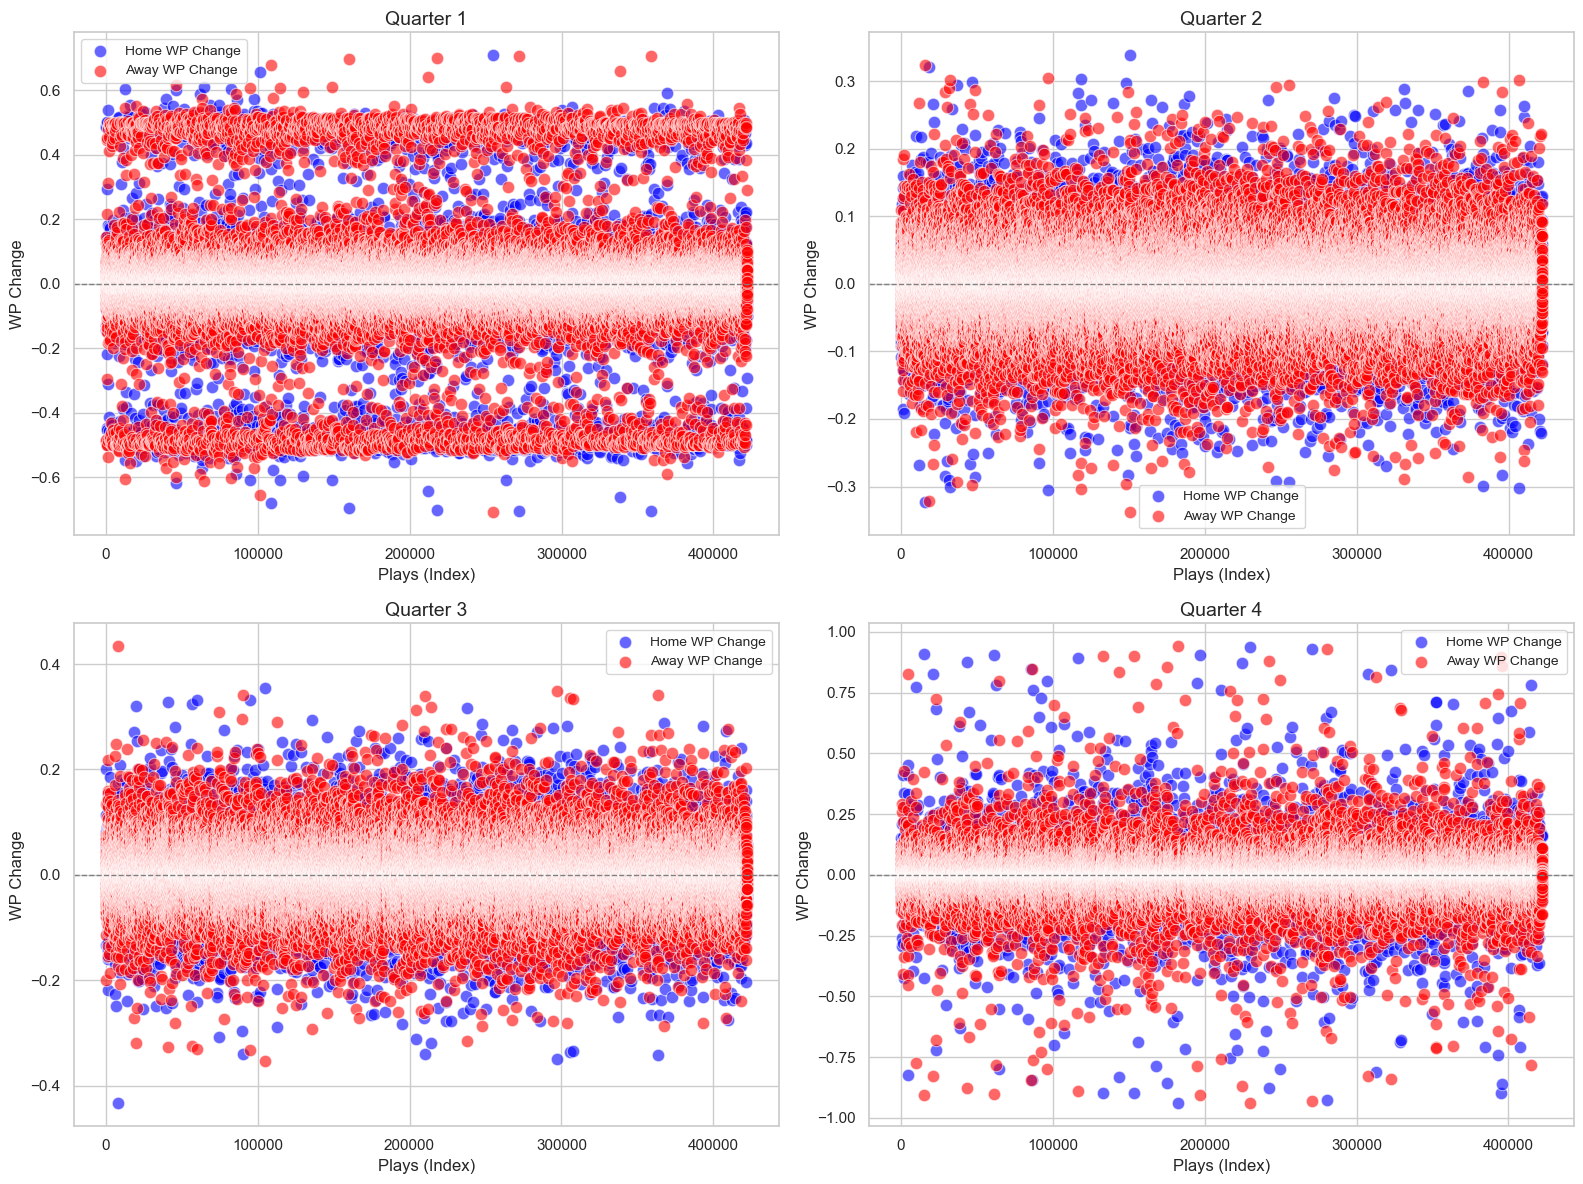

In [2]:
plt.figure(figsize=(16, 12))

# Iterate over quarters to create individual scatterplots
for quarter in range(1, 5):
    # Filter data for the current quarter
    quarter_data = dfV5[dfV5['qtr'] == quarter]
    
    # Create a subplot for the current quarter
    plt.subplot(2, 2, quarter)
    
    # Scatterplot for home WP change
    sns.scatterplot(
        x=quarter_data.index,  # Use the index as x-axis for spacing
        y=quarter_data['home_wp_change'],
        color='blue',
        s=80,
        alpha=0.6,
        label='Home WP Change',
    )
    
    # Scatterplot for away WP change
    sns.scatterplot(
        x=quarter_data.index,  # Use the index as x-axis for spacing
        y=quarter_data['away_wp_change'],
        color='red',
        s=80,
        alpha=0.6,
        label='Away WP Change',
    )
    
    # Customize the subplot
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # Reference line at WP change = 0
    plt.title(f'Quarter {quarter}', fontsize=14)
    plt.xlabel('Plays (Index)', fontsize=12)
    plt.ylabel('WP Change', fontsize=12)
    plt.legend(fontsize=10)

# Adjust layout for clarity
plt.tight_layout()

# Show the plot
plt.show()

# -----------------------End of old work----------------------------

# Testing 3 different score situtations - Within 1 score, Within 2 scores, 3 or more score games


1-score game: Sorted Game Dynamics by Max WP Changes
Home WP Changes:
quick_stop: 0.938
home_csum_scores: 0.929
away_csum_scores: 0.908
away_csum_def_stops: 0.908
home_csum_def_stops: 0.908
away_csum_first_downs: 0.891
home_score_differential: 0.870
home_csum_first_downs: 0.799
big_offensive_play: 0.783
high_leverage_moment: 0.759
big_defensive_play: 0.728
away_score_differential: 0.644
drought_end_play: 0.619
quick_score: 0.609
off_td: 0.609
long_td: 0.537
def_td: 0.505
big_st_play: 0.376
st_return_td: 0.154

Away WP Changes:
away_csum_scores: 0.941
away_csum_def_stops: 0.941
off_td: 0.928
quick_stop: 0.900
home_csum_first_downs: 0.900
away_csum_first_downs: 0.897
home_csum_def_stops: 0.861
away_score_differential: 0.855
home_score_differential: 0.846
drought_end_play: 0.825
quick_score: 0.825
home_csum_scores: 0.709
long_td: 0.706
big_offensive_play: 0.706
high_leverage_moment: 0.583
big_defensive_play: 0.549
def_td: 0.371
big_st_play: 0.224
st_return_td: 0.126


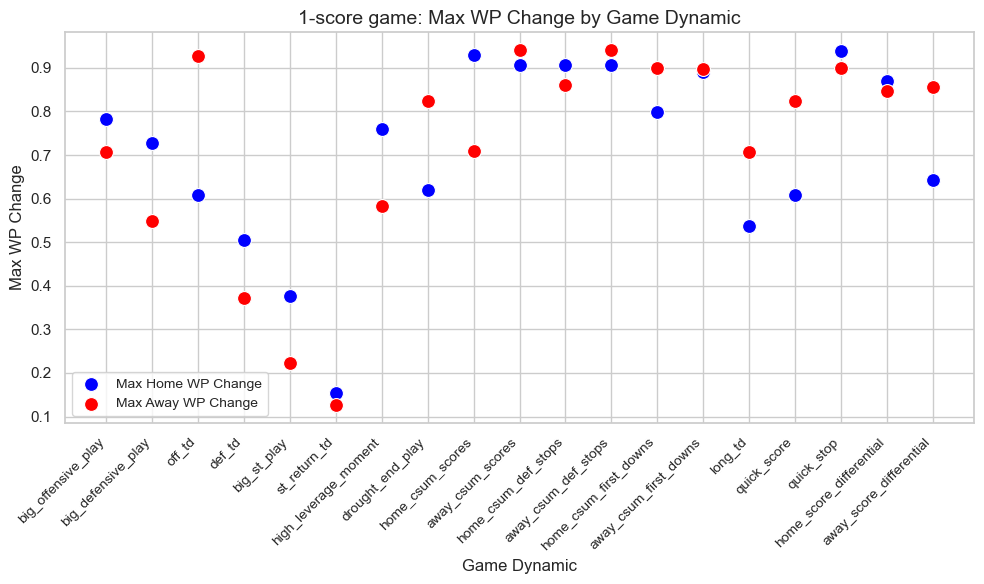


1-score game: Sorted Game Dynamics by Mean WP Changes
Home WP Changes:
quick_stop: 0.938
home_csum_scores: 0.929
away_csum_scores: 0.908
away_csum_def_stops: 0.908
home_csum_def_stops: 0.908
away_csum_first_downs: 0.891
home_score_differential: 0.870
home_csum_first_downs: 0.799
big_offensive_play: 0.783
high_leverage_moment: 0.759
big_defensive_play: 0.728
away_score_differential: 0.644
drought_end_play: 0.619
quick_score: 0.609
off_td: 0.609
long_td: 0.537
def_td: 0.505
big_st_play: 0.376
st_return_td: 0.154

Away WP Changes:
away_csum_scores: 0.941
away_csum_def_stops: 0.941
off_td: 0.928
quick_stop: 0.900
home_csum_first_downs: 0.900
away_csum_first_downs: 0.897
home_csum_def_stops: 0.861
away_score_differential: 0.855
home_score_differential: 0.846
drought_end_play: 0.825
quick_score: 0.825
home_csum_scores: 0.709
long_td: 0.706
big_offensive_play: 0.706
high_leverage_moment: 0.583
big_defensive_play: 0.549
def_td: 0.371
big_st_play: 0.224
st_return_td: 0.126


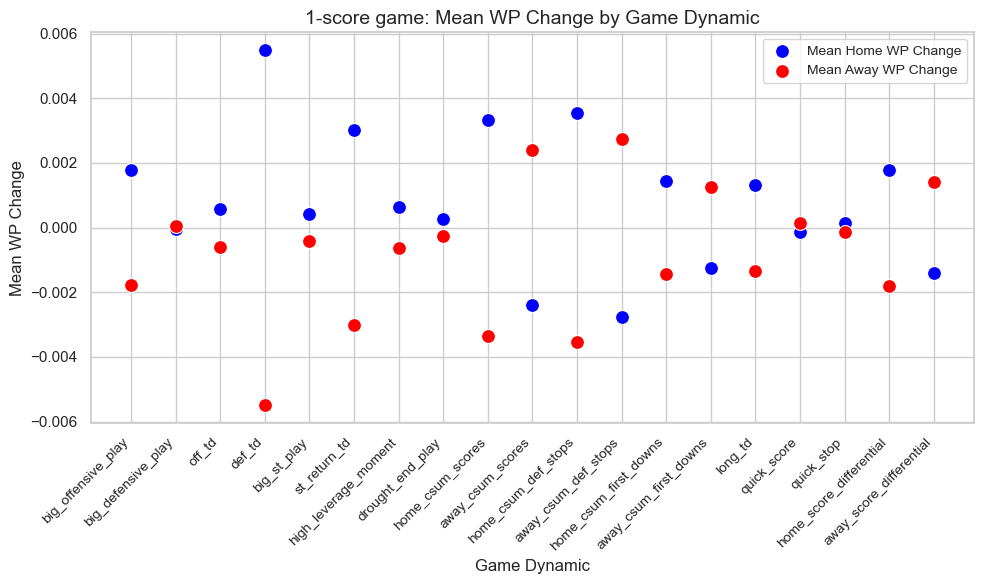


2-score game: Sorted Game Dynamics by Max WP Changes
Home WP Changes:
home_csum_def_stops: 0.605
quick_stop: 0.336
home_csum_scores: 0.334
away_csum_scores: 0.298
away_csum_def_stops: 0.298
big_defensive_play: 0.297
away_csum_first_downs: 0.229
big_offensive_play: 0.229
home_csum_first_downs: 0.204
quick_score: 0.204
off_td: 0.204
long_td: 0.181
def_td: 0.137
drought_end_play: 0.107
st_return_td: 0.097
big_st_play: 0.097
high_leverage_moment: 0.077
home_score_differential: 0.000
away_score_differential: 0.000

Away WP Changes:
away_csum_def_stops: 0.522
home_csum_scores: 0.522
home_csum_first_downs: 0.318
home_csum_def_stops: 0.301
quick_stop: 0.301
away_csum_scores: 0.289
off_td: 0.238
quick_score: 0.238
away_csum_first_downs: 0.238
big_defensive_play: 0.214
big_offensive_play: 0.204
def_td: 0.143
long_td: 0.122
drought_end_play: 0.106
big_st_play: 0.105
high_leverage_moment: 0.095
st_return_td: 0.095
home_score_differential: 0.000
away_score_differential: 0.000


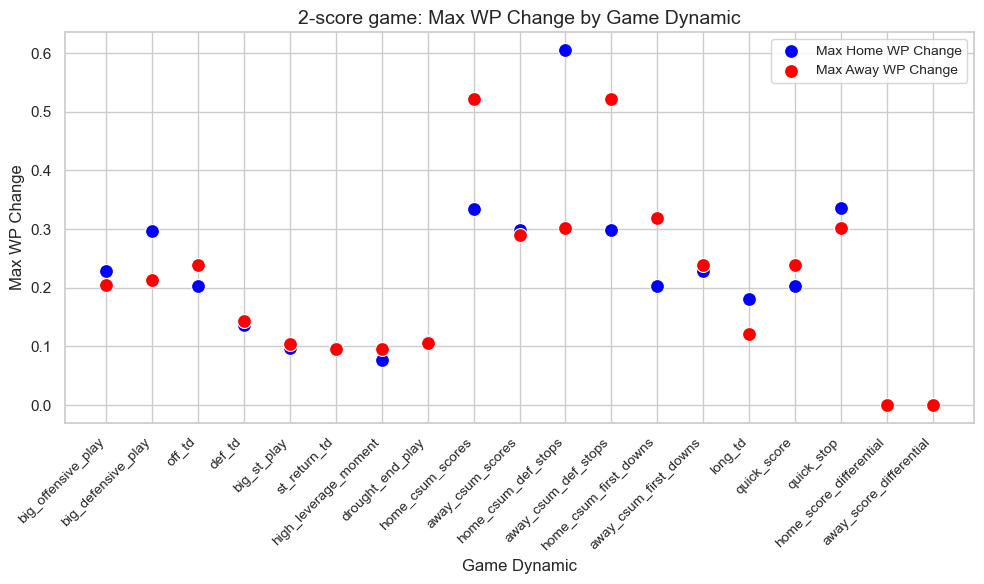


2-score game: Sorted Game Dynamics by Mean WP Changes
Home WP Changes:
home_csum_def_stops: 0.605
quick_stop: 0.336
home_csum_scores: 0.334
away_csum_scores: 0.298
away_csum_def_stops: 0.298
big_defensive_play: 0.297
away_csum_first_downs: 0.229
big_offensive_play: 0.229
home_csum_first_downs: 0.204
quick_score: 0.204
off_td: 0.204
long_td: 0.181
def_td: 0.137
drought_end_play: 0.107
st_return_td: 0.097
big_st_play: 0.097
high_leverage_moment: 0.077
home_score_differential: 0.000
away_score_differential: 0.000

Away WP Changes:
away_csum_def_stops: 0.522
home_csum_scores: 0.522
home_csum_first_downs: 0.318
home_csum_def_stops: 0.301
quick_stop: 0.301
away_csum_scores: 0.289
off_td: 0.238
quick_score: 0.238
away_csum_first_downs: 0.238
big_defensive_play: 0.214
big_offensive_play: 0.204
def_td: 0.143
long_td: 0.122
drought_end_play: 0.106
big_st_play: 0.105
high_leverage_moment: 0.095
st_return_td: 0.095
home_score_differential: 0.000
away_score_differential: 0.000


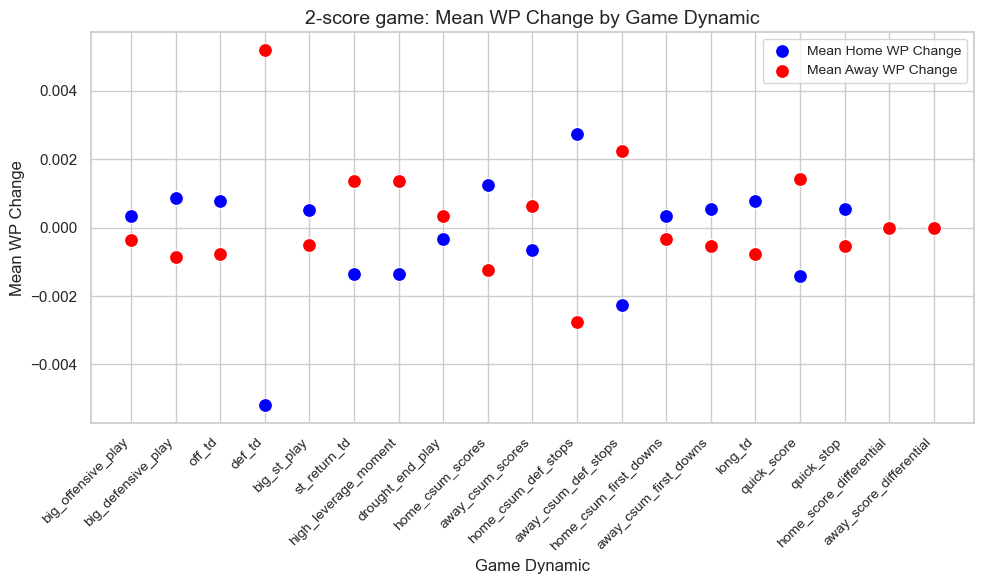


3-score game: Sorted Game Dynamics by Max WP Changes
Home WP Changes:
home_csum_first_downs: 0.222
away_csum_scores: 0.152
home_csum_def_stops: 0.152
away_csum_first_downs: 0.151
off_td: 0.129
quick_score: 0.129
away_csum_def_stops: 0.126
home_csum_scores: 0.114
quick_stop: 0.102
def_td: 0.093
drought_end_play: 0.093
big_defensive_play: 0.093
big_offensive_play: 0.066
long_td: 0.051
st_return_td: 0.042
big_st_play: 0.042
high_leverage_moment: 0.000
home_score_differential: 0.000
away_score_differential: 0.000

Away WP Changes:
quick_stop: 0.223
home_csum_scores: 0.223
away_csum_def_stops: 0.186
off_td: 0.145
home_csum_first_downs: 0.133
away_csum_first_downs: 0.124
quick_score: 0.124
away_csum_scores: 0.108
big_defensive_play: 0.108
def_td: 0.087
drought_end_play: 0.087
home_csum_def_stops: 0.084
long_td: 0.066
big_offensive_play: 0.066
st_return_td: 0.043
big_st_play: 0.043
high_leverage_moment: 0.000
home_score_differential: 0.000
away_score_differential: 0.000


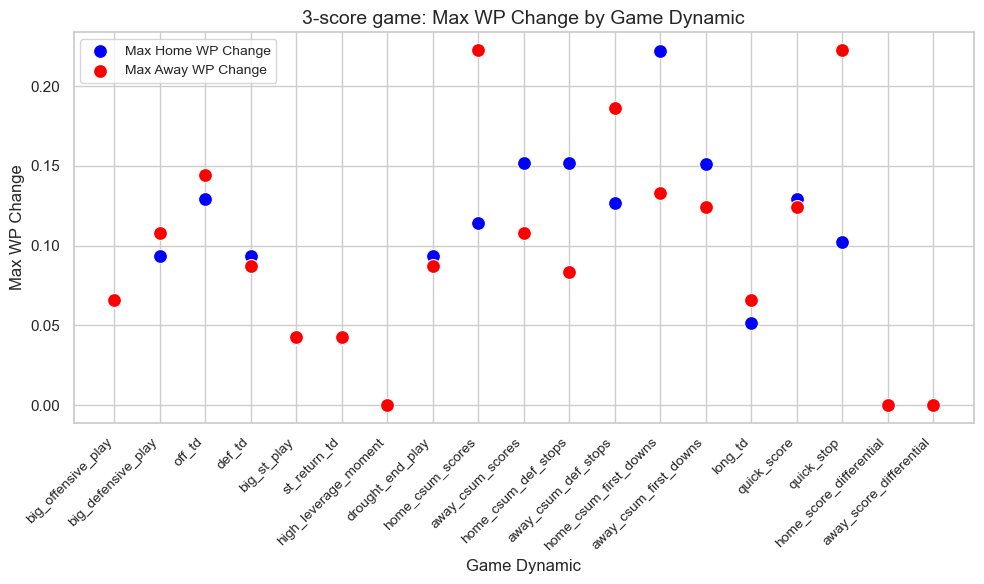


3-score game: Sorted Game Dynamics by Mean WP Changes
Home WP Changes:
home_csum_first_downs: 0.222
away_csum_scores: 0.152
home_csum_def_stops: 0.152
away_csum_first_downs: 0.151
off_td: 0.129
quick_score: 0.129
away_csum_def_stops: 0.126
home_csum_scores: 0.114
quick_stop: 0.102
def_td: 0.093
drought_end_play: 0.093
big_defensive_play: 0.093
big_offensive_play: 0.066
long_td: 0.051
st_return_td: 0.042
big_st_play: 0.042
high_leverage_moment: 0.000
home_score_differential: 0.000
away_score_differential: 0.000

Away WP Changes:
quick_stop: 0.223
home_csum_scores: 0.223
away_csum_def_stops: 0.186
off_td: 0.145
home_csum_first_downs: 0.133
away_csum_first_downs: 0.124
quick_score: 0.124
away_csum_scores: 0.108
big_defensive_play: 0.108
def_td: 0.087
drought_end_play: 0.087
home_csum_def_stops: 0.084
long_td: 0.066
big_offensive_play: 0.066
st_return_td: 0.043
big_st_play: 0.043
high_leverage_moment: 0.000
home_score_differential: 0.000
away_score_differential: 0.000


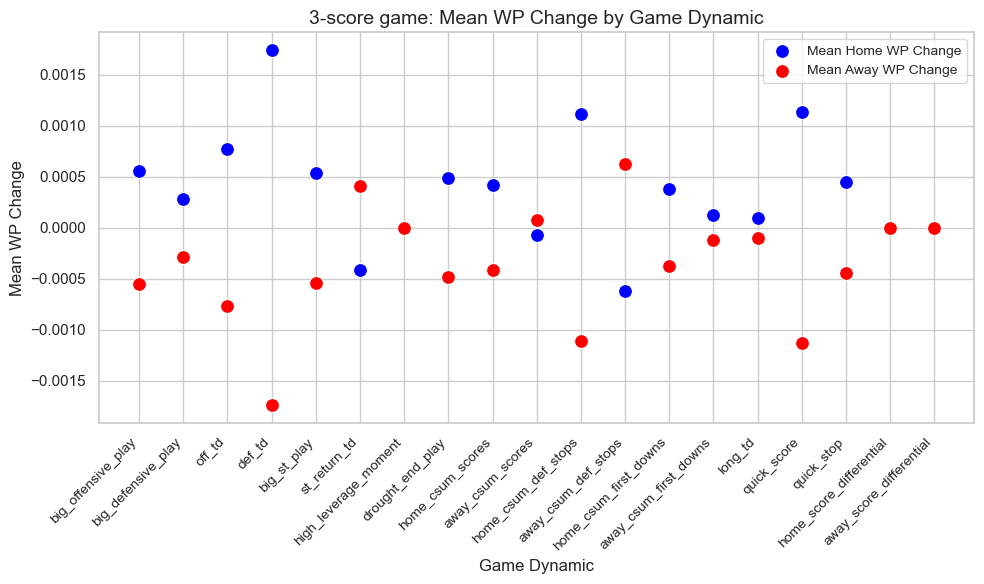

In [3]:
scoring_ranges = {
    '1-score game': (dfV5['home_score_differential'].abs() <= 8),
    '2-score game': (dfV5['home_score_differential'].abs() > 8) & (dfV5['home_score_differential'].abs() <= 16),
    '3-score game': (dfV5['home_score_differential'].abs() > 16),
}

all_dynamics = wp_change_analysis_df['game_dynamic'].unique()

for range_label, condition in scoring_ranges.items():
    range_df = dfV5[condition]
    wp_change_analysis = {}
    for dynamic_name, mask in dynamics: 
        wp_change_analysis[dynamic_name] = {
            'mean_home_wp_change': range_df.loc[mask, 'home_wp_change'].mean(),
            'max_home_wp_change': range_df.loc[mask, 'home_wp_change'].max(),
            'mean_away_wp_change': range_df.loc[mask, 'away_wp_change'].mean(),
            'max_away_wp_change': range_df.loc[mask, 'away_wp_change'].max(),
            'count': mask.sum(),
        }
  
    range_analysis_df = pd.DataFrame(wp_change_analysis).T.reset_index()
    range_analysis_df.columns = [
        'game_dynamic',
        'mean_home_wp_change',
        'max_home_wp_change',
        'mean_away_wp_change',
        'max_away_wp_change',
        'count',
    ]
    
    range_analysis_df = range_analysis_df.set_index('game_dynamic').reindex(all_dynamics).reset_index()
    range_analysis_df.fillna(0, inplace=True)
    
    sorted_home_wp = range_analysis_df[['game_dynamic', 'max_home_wp_change']].sort_values(
        by='max_home_wp_change', ascending=False
    ).reset_index(drop=True)
    
    sorted_away_wp = range_analysis_df[['game_dynamic', 'max_away_wp_change']].sort_values(
        by='max_away_wp_change', ascending=False
    ).reset_index(drop=True)
    
    print(f"\n{range_label}: Sorted Game Dynamics by Max WP Changes")
    print("Home WP Changes:")
    for dynamic, max_value in sorted_home_wp.values:
        print(f"{dynamic}: {max_value:.3f}")
    
    print("\nAway WP Changes:")
    for dynamic, max_value in sorted_away_wp.values:
        print(f"{dynamic}: {max_value:.3f}")
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='game_dynamic',
        y='max_home_wp_change',
        data=range_analysis_df,
        color='blue',
        s=100,
        label='Max Home WP Change',
    )
    sns.scatterplot(
        x='game_dynamic',
        y='max_away_wp_change',
        data=range_analysis_df,
        color='red',
        s=100,
        label='Max Away WP Change',
    )
    
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.xlabel('Game Dynamic', fontsize=12)
    plt.ylabel('Max WP Change', fontsize=12)
    plt.title(f'{range_label}: Max WP Change by Game Dynamic', fontsize=14)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

    print(f"\n{range_label}: Sorted Game Dynamics by Mean WP Changes")
    print("Home WP Changes:")
    for dynamic, mean_value in sorted_home_wp.values:
        print(f"{dynamic}: {mean_value:.3f}")
    
    print("\nAway WP Changes:")
    for dynamic, mean_value in sorted_away_wp.values:
        print(f"{dynamic}: {mean_value:.3f}")

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='game_dynamic',
        y='mean_home_wp_change',
        data=range_analysis_df,
        color='blue',
        s=100,
        label='Mean Home WP Change',
    )
    sns.scatterplot(
        x='game_dynamic',
        y='mean_away_wp_change',
        data=range_analysis_df,
        color='red',
        s=100,
        label='Mean Away WP Change',
    )
    
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.xlabel('Game Dynamic', fontsize=12)
    plt.ylabel('Mean WP Change', fontsize=12)
    plt.title(f'{range_label}: Mean WP Change by Game Dynamic', fontsize=14)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

# Testing 3 different score situtations - Home Winning by 1 score, Home Winning by 2 scores, Home Winning by 3 or more score games


1-score game: Sorted Game Dynamics by Max WP Changes - Home Winning
Home WP Changes:
home_csum_scores: 0.929
quick_stop: 0.929
away_csum_scores: 0.908
away_csum_def_stops: 0.908
home_csum_def_stops: 0.908
away_csum_first_downs: 0.891
home_score_differential: 0.870
big_offensive_play: 0.783
high_leverage_moment: 0.759
big_defensive_play: 0.705
home_csum_first_downs: 0.637
drought_end_play: 0.609
quick_score: 0.609
off_td: 0.609
def_td: 0.505
long_td: 0.390
big_st_play: 0.376
st_return_td: 0.154
away_score_differential: 0.000

Away WP Changes:
away_csum_scores: 0.941
away_csum_def_stops: 0.941
home_score_differential: 0.846
quick_stop: 0.846
away_csum_first_downs: 0.846
home_csum_def_stops: 0.813
home_csum_scores: 0.709
quick_score: 0.418
long_td: 0.418
home_csum_first_downs: 0.418
big_offensive_play: 0.418
off_td: 0.418
drought_end_play: 0.392
big_defensive_play: 0.371
def_td: 0.371
high_leverage_moment: 0.284
big_st_play: 0.177
st_return_td: 0.050
away_score_differential: 0.000


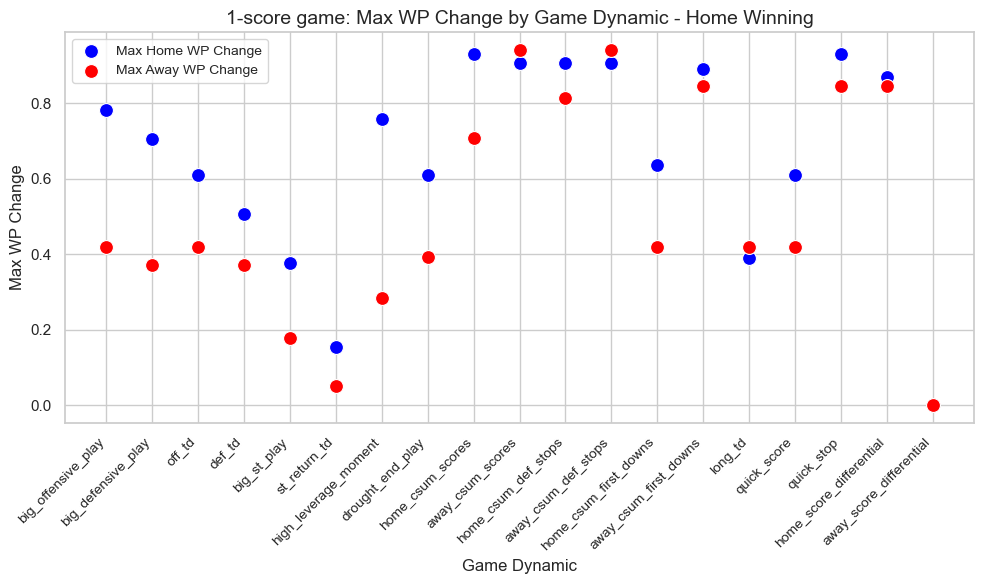


1-score game: Sorted Game Dynamics by Mean WP Changes - Home Winning
Home WP Changes:
home_csum_scores: 0.929
quick_stop: 0.929
away_csum_scores: 0.908
away_csum_def_stops: 0.908
home_csum_def_stops: 0.908
away_csum_first_downs: 0.891
home_score_differential: 0.870
big_offensive_play: 0.783
high_leverage_moment: 0.759
big_defensive_play: 0.705
home_csum_first_downs: 0.637
drought_end_play: 0.609
quick_score: 0.609
off_td: 0.609
def_td: 0.505
long_td: 0.390
big_st_play: 0.376
st_return_td: 0.154
away_score_differential: 0.000

Away WP Changes:
away_csum_scores: 0.941
away_csum_def_stops: 0.941
home_score_differential: 0.846
quick_stop: 0.846
away_csum_first_downs: 0.846
home_csum_def_stops: 0.813
home_csum_scores: 0.709
quick_score: 0.418
long_td: 0.418
home_csum_first_downs: 0.418
big_offensive_play: 0.418
off_td: 0.418
drought_end_play: 0.392
big_defensive_play: 0.371
def_td: 0.371
high_leverage_moment: 0.284
big_st_play: 0.177
st_return_td: 0.050
away_score_differential: 0.000


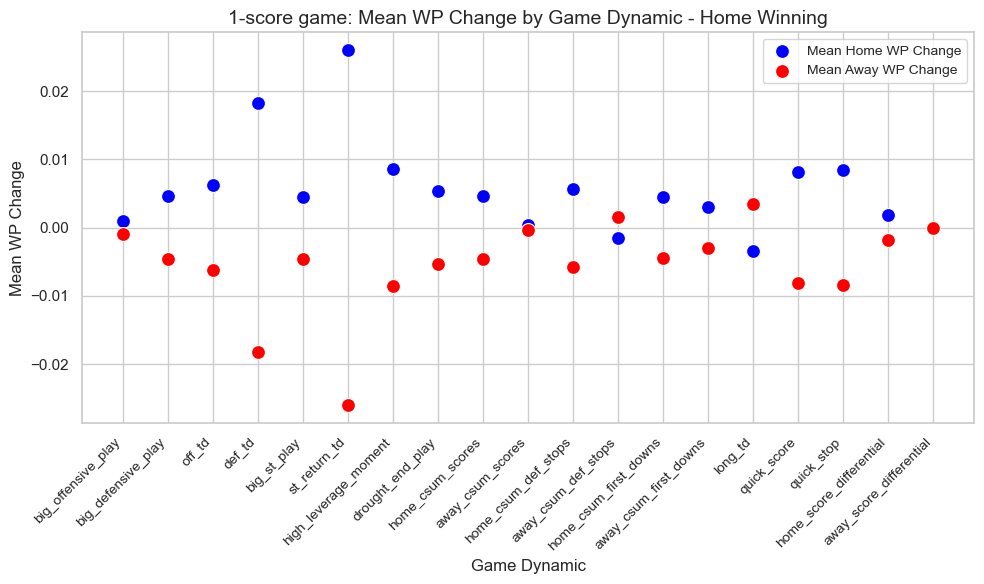


2-score game: Sorted Game Dynamics by Max WP Changes - Home Winning
Home WP Changes:
home_csum_def_stops: 0.605
quick_stop: 0.336
home_csum_scores: 0.334
away_csum_scores: 0.298
away_csum_def_stops: 0.298
big_defensive_play: 0.297
away_csum_first_downs: 0.229
big_offensive_play: 0.229
home_csum_first_downs: 0.204
quick_score: 0.204
off_td: 0.204
long_td: 0.181
def_td: 0.137
drought_end_play: 0.107
st_return_td: 0.097
big_st_play: 0.097
high_leverage_moment: 0.052
home_score_differential: 0.000
away_score_differential: 0.000

Away WP Changes:
away_csum_scores: 0.219
away_csum_first_downs: 0.203
home_csum_scores: 0.203
quick_stop: 0.203
quick_score: 0.203
home_csum_def_stops: 0.203
away_csum_def_stops: 0.193
big_defensive_play: 0.160
def_td: 0.102
home_csum_first_downs: 0.099
big_st_play: 0.089
off_td: 0.089
big_offensive_play: 0.088
long_td: 0.086
drought_end_play: 0.072
high_leverage_moment: 0.068
st_return_td: 0.039
home_score_differential: 0.000
away_score_differential: 0.000


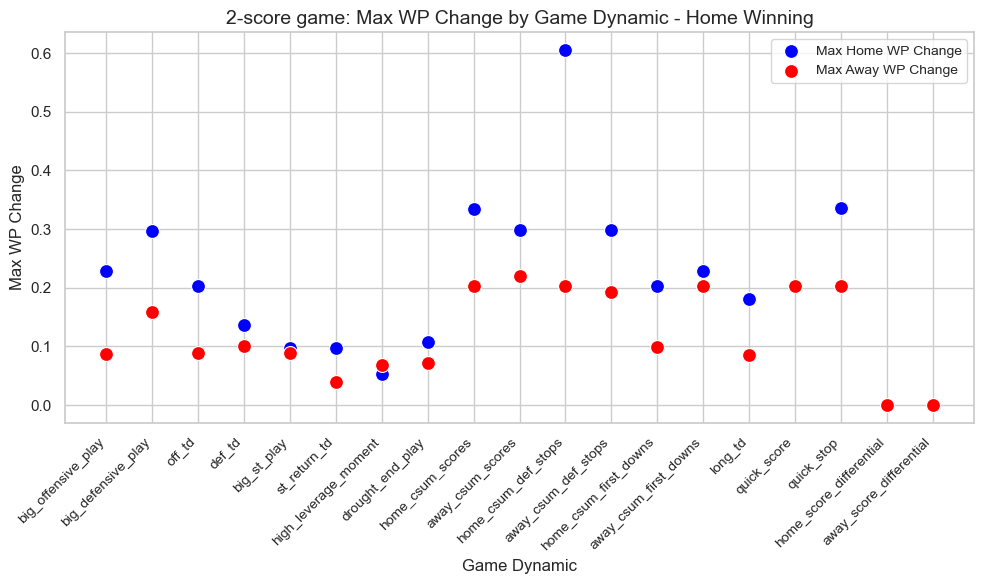


2-score game: Sorted Game Dynamics by Mean WP Changes - Home Winning
Home WP Changes:
home_csum_def_stops: 0.605
quick_stop: 0.336
home_csum_scores: 0.334
away_csum_scores: 0.298
away_csum_def_stops: 0.298
big_defensive_play: 0.297
away_csum_first_downs: 0.229
big_offensive_play: 0.229
home_csum_first_downs: 0.204
quick_score: 0.204
off_td: 0.204
long_td: 0.181
def_td: 0.137
drought_end_play: 0.107
st_return_td: 0.097
big_st_play: 0.097
high_leverage_moment: 0.052
home_score_differential: 0.000
away_score_differential: 0.000

Away WP Changes:
away_csum_scores: 0.219
away_csum_first_downs: 0.203
home_csum_scores: 0.203
quick_stop: 0.203
quick_score: 0.203
home_csum_def_stops: 0.203
away_csum_def_stops: 0.193
big_defensive_play: 0.160
def_td: 0.102
home_csum_first_downs: 0.099
big_st_play: 0.089
off_td: 0.089
big_offensive_play: 0.088
long_td: 0.086
drought_end_play: 0.072
high_leverage_moment: 0.068
st_return_td: 0.039
home_score_differential: 0.000
away_score_differential: 0.000


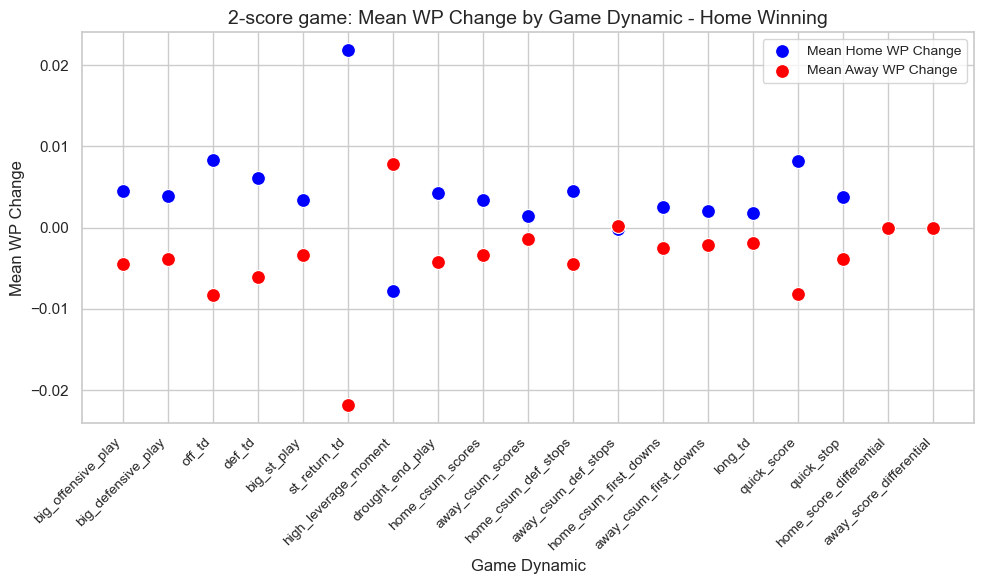


3-score game: Sorted Game Dynamics by Max WP Changes - Home Winning
Home WP Changes:
home_csum_first_downs: 0.222
away_csum_scores: 0.152
home_csum_def_stops: 0.152
away_csum_first_downs: 0.151
off_td: 0.129
quick_score: 0.129
away_csum_def_stops: 0.126
home_csum_scores: 0.114
quick_stop: 0.102
def_td: 0.093
drought_end_play: 0.093
big_defensive_play: 0.093
big_offensive_play: 0.066
long_td: 0.045
st_return_td: 0.042
big_st_play: 0.042
high_leverage_moment: 0.000
home_score_differential: 0.000
away_score_differential: 0.000

Away WP Changes:
home_csum_scores: 0.223
quick_stop: 0.223
away_csum_first_downs: 0.074
away_csum_def_stops: 0.071
away_csum_scores: 0.063
home_csum_def_stops: 0.055
big_defensive_play: 0.053
home_csum_first_downs: 0.052
big_offensive_play: 0.052
drought_end_play: 0.038
def_td: 0.038
quick_score: 0.035
off_td: 0.035
big_st_play: 0.031
long_td: 0.030
st_return_td: 0.002
high_leverage_moment: 0.000
home_score_differential: 0.000
away_score_differential: 0.000


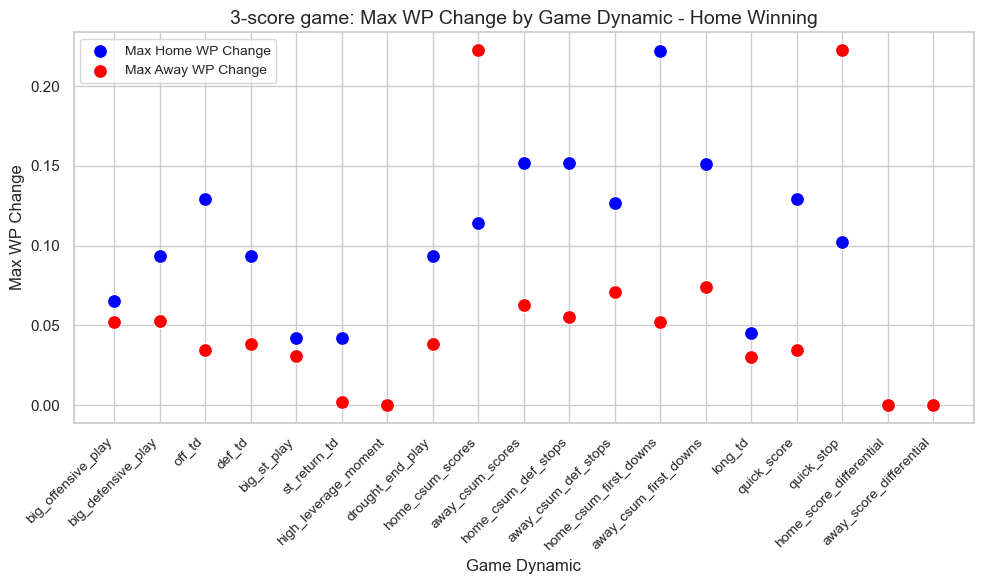


3-score game: Sorted Game Dynamics by Mean WP Changes - Home Winning
Home WP Changes:
home_csum_first_downs: 0.222
away_csum_scores: 0.152
home_csum_def_stops: 0.152
away_csum_first_downs: 0.151
off_td: 0.129
quick_score: 0.129
away_csum_def_stops: 0.126
home_csum_scores: 0.114
quick_stop: 0.102
def_td: 0.093
drought_end_play: 0.093
big_defensive_play: 0.093
big_offensive_play: 0.066
long_td: 0.045
st_return_td: 0.042
big_st_play: 0.042
high_leverage_moment: 0.000
home_score_differential: 0.000
away_score_differential: 0.000

Away WP Changes:
home_csum_scores: 0.223
quick_stop: 0.223
away_csum_first_downs: 0.074
away_csum_def_stops: 0.071
away_csum_scores: 0.063
home_csum_def_stops: 0.055
big_defensive_play: 0.053
home_csum_first_downs: 0.052
big_offensive_play: 0.052
drought_end_play: 0.038
def_td: 0.038
quick_score: 0.035
off_td: 0.035
big_st_play: 0.031
long_td: 0.030
st_return_td: 0.002
high_leverage_moment: 0.000
home_score_differential: 0.000
away_score_differential: 0.000


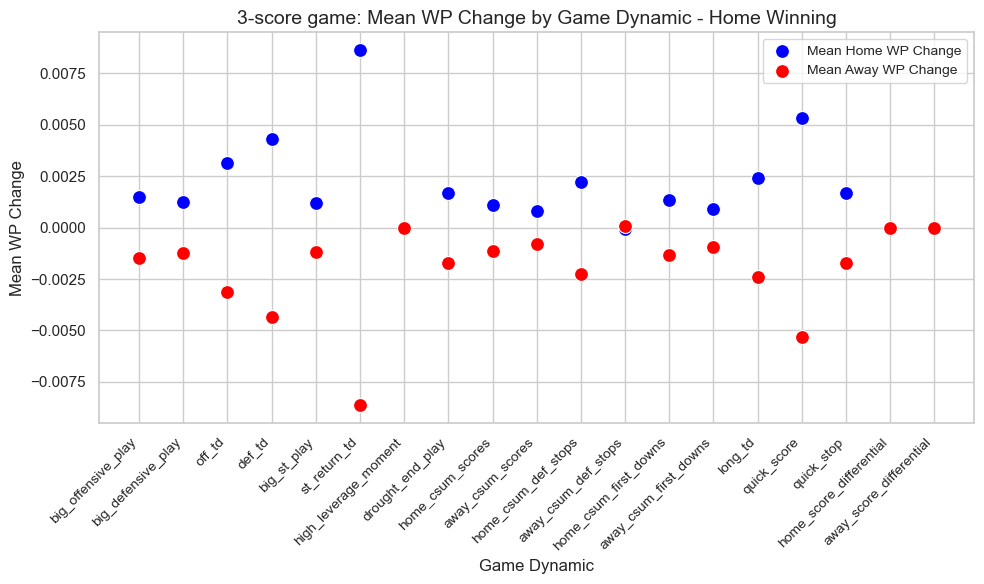

In [4]:
scoring_ranges = {
    '1-score game': (dfV5['home_score_differential'] > 0) & (dfV5['home_score_differential'] <= 8),
    '2-score game': (dfV5['home_score_differential'] > 8) & (dfV5['home_score_differential'] <= 16),
    '3-score game': (dfV5['home_score_differential'] > 16),
}

all_dynamics = wp_change_analysis_df['game_dynamic'].unique()

for range_label, condition in scoring_ranges.items():
    range_df = dfV5[condition]
    wp_change_analysis = {}
    for dynamic_name, mask in dynamics: 
        wp_change_analysis[dynamic_name] = {
            'mean_home_wp_change': range_df.loc[mask, 'home_wp_change'].mean(),
            'max_home_wp_change': range_df.loc[mask, 'home_wp_change'].max(),
            'mean_away_wp_change': range_df.loc[mask, 'away_wp_change'].mean(),
            'max_away_wp_change': range_df.loc[mask, 'away_wp_change'].max(),
            'count': mask.sum(),
        }
    
    range_analysis_df = pd.DataFrame(wp_change_analysis).T.reset_index()
    range_analysis_df.columns = [
        'game_dynamic',
        'mean_home_wp_change',
        'max_home_wp_change',
        'mean_away_wp_change',
        'max_away_wp_change',
        'count',
    ]
    
    range_analysis_df = range_analysis_df.set_index('game_dynamic').reindex(all_dynamics).reset_index()
    range_analysis_df.fillna(0, inplace=True)
    
    sorted_home_wp = range_analysis_df[['game_dynamic', 'max_home_wp_change']].sort_values(
        by='max_home_wp_change', ascending=False
    ).reset_index(drop=True)
    
    sorted_away_wp = range_analysis_df[['game_dynamic', 'max_away_wp_change']].sort_values(
        by='max_away_wp_change', ascending=False
    ).reset_index(drop=True)

    print(f"\n{range_label}: Sorted Game Dynamics by Max WP Changes - Home Winning")
    print("Home WP Changes:")
    for dynamic, max_value in sorted_home_wp.values:
        print(f"{dynamic}: {max_value:.3f}")
    
    print("\nAway WP Changes:")
    for dynamic, max_value in sorted_away_wp.values:
        print(f"{dynamic}: {max_value:.3f}")
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='game_dynamic',
        y='max_home_wp_change',
        data=range_analysis_df,
        color='blue',
        s=100,
        label='Max Home WP Change',
    )
    sns.scatterplot(
        x='game_dynamic',
        y='max_away_wp_change',
        data=range_analysis_df,
        color='red',
        s=100,
        label='Max Away WP Change',
    )
    
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.xlabel('Game Dynamic', fontsize=12)
    plt.ylabel('Max WP Change', fontsize=12)
    plt.title(f'{range_label}: Max WP Change by Game Dynamic - Home Winning', fontsize=14)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

    print(f"\n{range_label}: Sorted Game Dynamics by Mean WP Changes - Home Winning")
    print("Home WP Changes:")
    for dynamic, mean_value in sorted_home_wp.values:
        print(f"{dynamic}: {mean_value:.3f}")
    
    print("\nAway WP Changes:")
    for dynamic, mean_value in sorted_away_wp.values:
        print(f"{dynamic}: {mean_value:.3f}")

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='game_dynamic',
        y='mean_home_wp_change',
        data=range_analysis_df,
        color='blue',
        s=100,
        label='Mean Home WP Change',
    )
    sns.scatterplot(
        x='game_dynamic',
        y='mean_away_wp_change',
        data=range_analysis_df,
        color='red',
        s=100,
        label='Mean Away WP Change',
    )
    
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.xlabel('Game Dynamic', fontsize=12)
    plt.ylabel('Mean WP Change', fontsize=12)
    plt.title(f'{range_label}: Mean WP Change by Game Dynamic - Home Winning', fontsize=14)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

# Testing 3 different score situtations - Away Winning by 1 score, Away Winning by 2 scores, Away Winning by 3 or more score games


1-score game: Sorted Game Dynamics by Max WP Changes - Away Winning
Home WP Changes:
home_csum_scores: 0.710
away_csum_def_stops: 0.648
big_offensive_play: 0.644
quick_stop: 0.644
away_csum_scores: 0.644
away_score_differential: 0.644
home_csum_def_stops: 0.611
long_td: 0.537
quick_score: 0.537
off_td: 0.537
high_leverage_moment: 0.514
home_csum_first_downs: 0.486
away_csum_first_downs: 0.456
drought_end_play: 0.377
big_defensive_play: 0.377
def_td: 0.377
big_st_play: 0.154
st_return_td: 0.034
home_score_differential: 0.000

Away WP Changes:
away_csum_scores: 0.928
off_td: 0.928
away_csum_def_stops: 0.900
quick_stop: 0.900
home_csum_first_downs: 0.900
away_score_differential: 0.855
drought_end_play: 0.825
quick_score: 0.825
home_csum_def_stops: 0.801
away_csum_first_downs: 0.801
home_csum_scores: 0.706
long_td: 0.706
big_offensive_play: 0.706
high_leverage_moment: 0.583
big_defensive_play: 0.431
big_st_play: 0.195
st_return_td: 0.126
def_td: 0.126
home_score_differential: 0.000


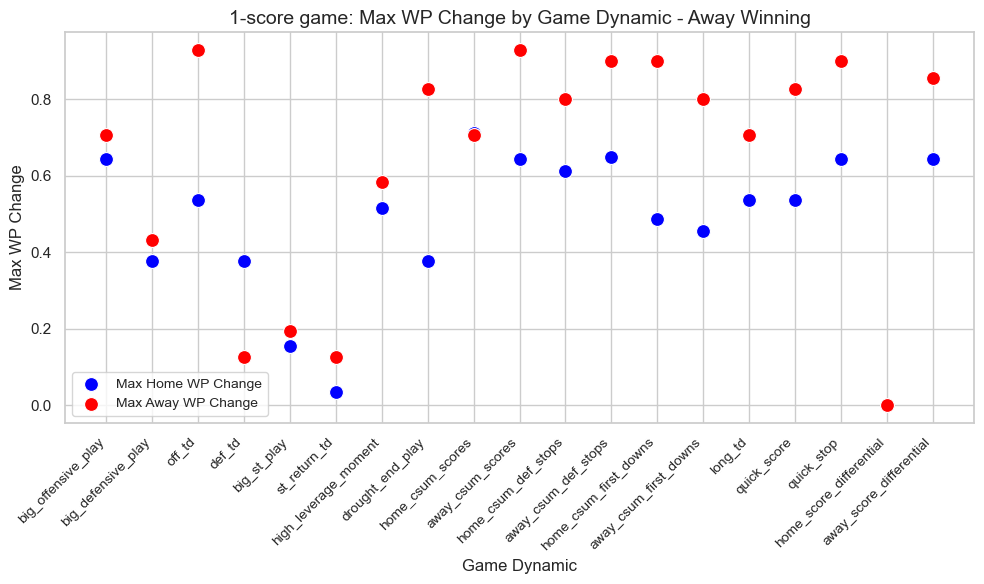


1-score game: Sorted Game Dynamics by Mean WP Changes - Away Winning
Home WP Changes:
home_csum_scores: 0.710
away_csum_def_stops: 0.648
big_offensive_play: 0.644
quick_stop: 0.644
away_csum_scores: 0.644
away_score_differential: 0.644
home_csum_def_stops: 0.611
long_td: 0.537
quick_score: 0.537
off_td: 0.537
high_leverage_moment: 0.514
home_csum_first_downs: 0.486
away_csum_first_downs: 0.456
drought_end_play: 0.377
big_defensive_play: 0.377
def_td: 0.377
big_st_play: 0.154
st_return_td: 0.034
home_score_differential: 0.000

Away WP Changes:
away_csum_scores: 0.928
off_td: 0.928
away_csum_def_stops: 0.900
quick_stop: 0.900
home_csum_first_downs: 0.900
away_score_differential: 0.855
drought_end_play: 0.825
quick_score: 0.825
home_csum_def_stops: 0.801
away_csum_first_downs: 0.801
home_csum_scores: 0.706
long_td: 0.706
big_offensive_play: 0.706
high_leverage_moment: 0.583
big_defensive_play: 0.431
big_st_play: 0.195
st_return_td: 0.126
def_td: 0.126
home_score_differential: 0.000


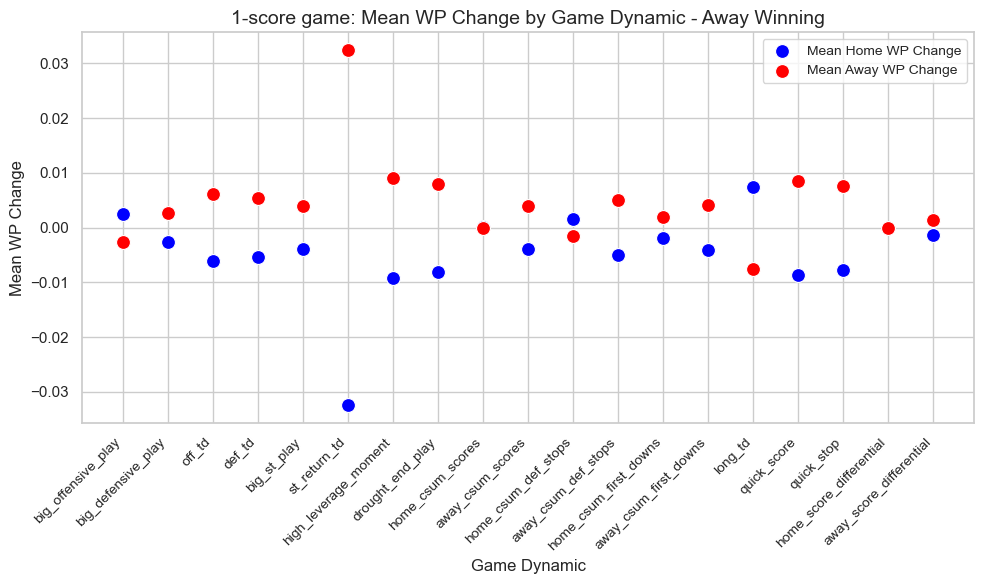


2-score game: Sorted Game Dynamics by Max WP Changes - Away Winning
Home WP Changes:
away_csum_scores: 0.179
home_csum_first_downs: 0.173
quick_stop: 0.167
home_csum_scores: 0.167
home_csum_def_stops: 0.167
away_csum_def_stops: 0.154
big_defensive_play: 0.148
quick_score: 0.122
def_td: 0.122
away_csum_first_downs: 0.092
big_st_play: 0.083
high_leverage_moment: 0.077
off_td: 0.075
drought_end_play: 0.074
big_offensive_play: 0.069
long_td: 0.069
st_return_td: 0.003
home_score_differential: 0.000
away_score_differential: 0.000

Away WP Changes:
away_csum_def_stops: 0.522
home_csum_scores: 0.522
home_csum_first_downs: 0.318
home_csum_def_stops: 0.301
quick_stop: 0.301
away_csum_scores: 0.289
off_td: 0.238
quick_score: 0.238
away_csum_first_downs: 0.238
big_defensive_play: 0.214
big_offensive_play: 0.204
def_td: 0.143
long_td: 0.122
drought_end_play: 0.106
big_st_play: 0.105
high_leverage_moment: 0.095
st_return_td: 0.095
home_score_differential: 0.000
away_score_differential: 0.000


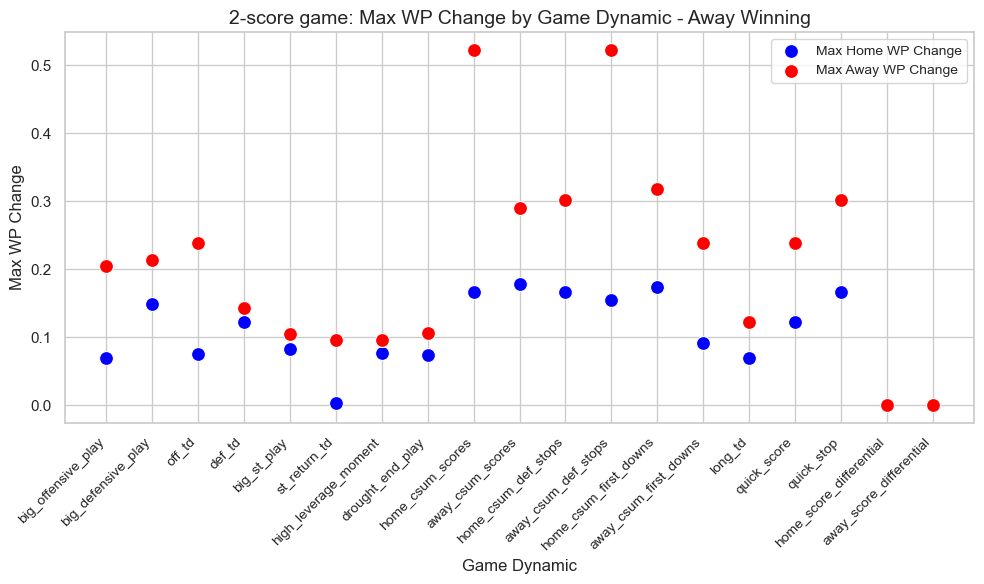


2-score game: Sorted Game Dynamics by Mean WP Changes - Away Winning
Home WP Changes:
away_csum_scores: 0.179
home_csum_first_downs: 0.173
quick_stop: 0.167
home_csum_scores: 0.167
home_csum_def_stops: 0.167
away_csum_def_stops: 0.154
big_defensive_play: 0.148
quick_score: 0.122
def_td: 0.122
away_csum_first_downs: 0.092
big_st_play: 0.083
high_leverage_moment: 0.077
off_td: 0.075
drought_end_play: 0.074
big_offensive_play: 0.069
long_td: 0.069
st_return_td: 0.003
home_score_differential: 0.000
away_score_differential: 0.000

Away WP Changes:
away_csum_def_stops: 0.522
home_csum_scores: 0.522
home_csum_first_downs: 0.318
home_csum_def_stops: 0.301
quick_stop: 0.301
away_csum_scores: 0.289
off_td: 0.238
quick_score: 0.238
away_csum_first_downs: 0.238
big_defensive_play: 0.214
big_offensive_play: 0.204
def_td: 0.143
long_td: 0.122
drought_end_play: 0.106
big_st_play: 0.105
high_leverage_moment: 0.095
st_return_td: 0.095
home_score_differential: 0.000
away_score_differential: 0.000


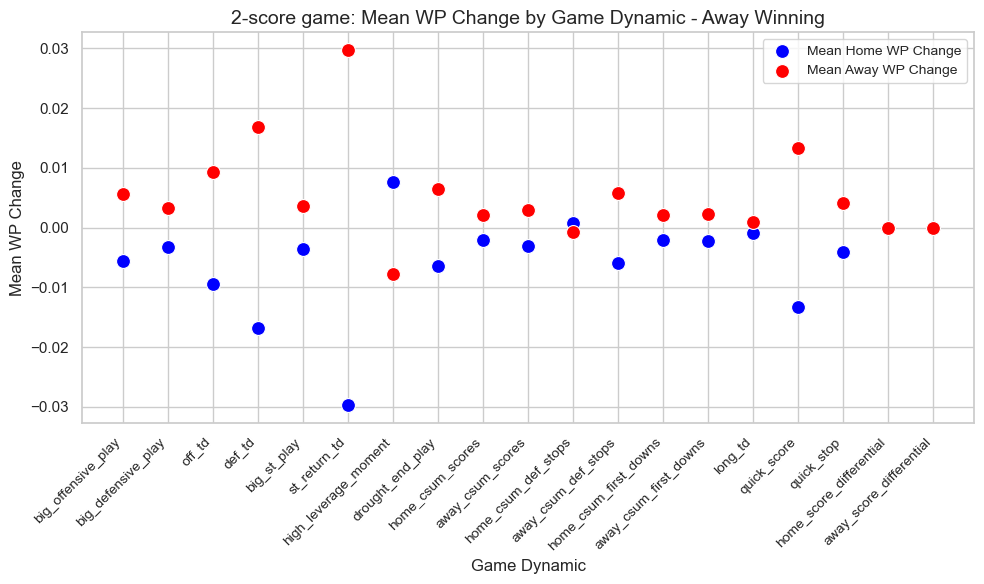


3-score game: Sorted Game Dynamics by Max WP Changes - Away Winning
Home WP Changes:
quick_stop: 0.073
home_csum_def_stops: 0.073
big_defensive_play: 0.073
home_csum_scores: 0.064
home_csum_first_downs: 0.055
away_csum_scores: 0.052
quick_score: 0.051
long_td: 0.051
big_offensive_play: 0.051
off_td: 0.051
away_csum_def_stops: 0.048
def_td: 0.036
big_st_play: 0.032
drought_end_play: 0.031
away_csum_first_downs: 0.030
high_leverage_moment: 0.000
home_score_differential: 0.000
away_score_differential: 0.000
st_return_td: -0.002

Away WP Changes:
home_csum_scores: 0.186
away_csum_def_stops: 0.186
off_td: 0.145
quick_stop: 0.133
home_csum_first_downs: 0.133
away_csum_first_downs: 0.124
quick_score: 0.124
away_csum_scores: 0.108
big_defensive_play: 0.108
def_td: 0.087
drought_end_play: 0.087
home_csum_def_stops: 0.084
long_td: 0.066
big_offensive_play: 0.066
st_return_td: 0.043
big_st_play: 0.043
high_leverage_moment: 0.000
home_score_differential: 0.000
away_score_differential: 0.000


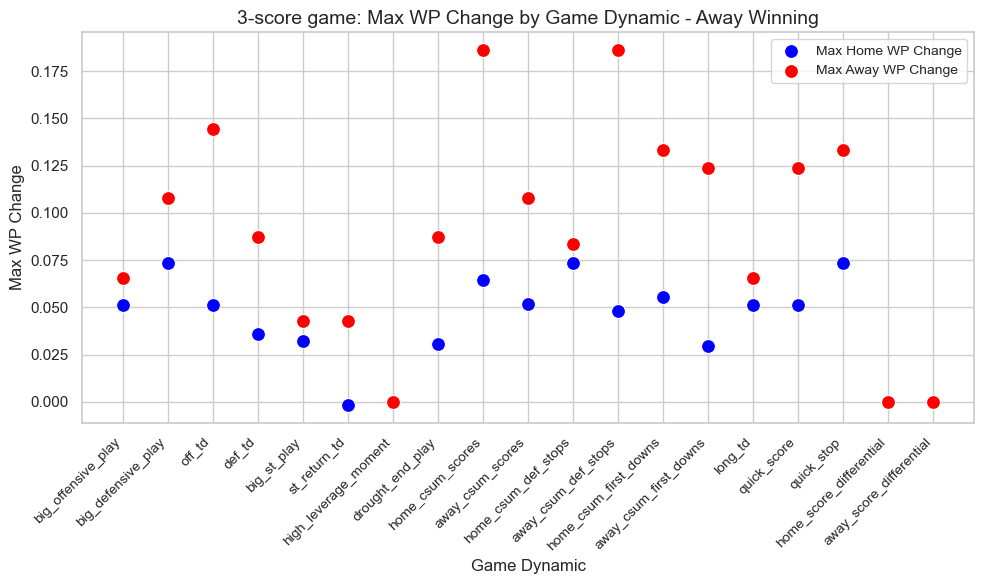


3-score game: Sorted Game Dynamics by Mean WP Changes - Away Winning
Home WP Changes:
quick_stop: 0.073
home_csum_def_stops: 0.073
big_defensive_play: 0.073
home_csum_scores: 0.064
home_csum_first_downs: 0.055
away_csum_scores: 0.052
quick_score: 0.051
long_td: 0.051
big_offensive_play: 0.051
off_td: 0.051
away_csum_def_stops: 0.048
def_td: 0.036
big_st_play: 0.032
drought_end_play: 0.031
away_csum_first_downs: 0.030
high_leverage_moment: 0.000
home_score_differential: 0.000
away_score_differential: 0.000
st_return_td: -0.002

Away WP Changes:
home_csum_scores: 0.186
away_csum_def_stops: 0.186
off_td: 0.145
quick_stop: 0.133
home_csum_first_downs: 0.133
away_csum_first_downs: 0.124
quick_score: 0.124
away_csum_scores: 0.108
big_defensive_play: 0.108
def_td: 0.087
drought_end_play: 0.087
home_csum_def_stops: 0.084
long_td: 0.066
big_offensive_play: 0.066
st_return_td: 0.043
big_st_play: 0.043
high_leverage_moment: 0.000
home_score_differential: 0.000
away_score_differential: 0.000


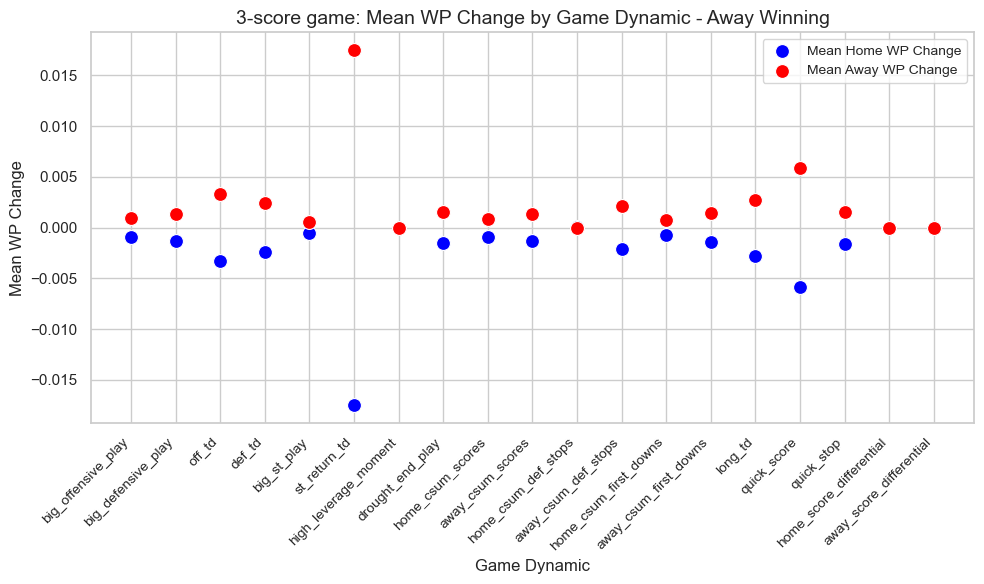

In [5]:
scoring_ranges = {
    '1-score game': (dfV5['away_score_differential'] > 0) & (dfV5['away_score_differential'] <= 8),
    '2-score game': (dfV5['away_score_differential'] > 8) & (dfV5['away_score_differential'] <= 16),
    '3-score game': (dfV5['away_score_differential'] > 16),
}

all_dynamics = wp_change_analysis_df['game_dynamic'].unique()

for range_label, condition in scoring_ranges.items():
    range_df = dfV5[condition]
    wp_change_analysis = {}
    for dynamic_name, mask in dynamics: 
        wp_change_analysis[dynamic_name] = {
            'mean_home_wp_change': range_df.loc[mask, 'home_wp_change'].mean(),
            'max_home_wp_change': range_df.loc[mask, 'home_wp_change'].max(),
            'mean_away_wp_change': range_df.loc[mask, 'away_wp_change'].mean(),
            'max_away_wp_change': range_df.loc[mask, 'away_wp_change'].max(),
            'count': mask.sum(),
        }
    
    range_analysis_df = pd.DataFrame(wp_change_analysis).T.reset_index()
    range_analysis_df.columns = [
        'game_dynamic',
        'mean_home_wp_change',
        'max_home_wp_change',
        'mean_away_wp_change',
        'max_away_wp_change',
        'count',
    ]
    
    range_analysis_df = range_analysis_df.set_index('game_dynamic').reindex(all_dynamics).reset_index()
    range_analysis_df.fillna(0, inplace=True)
    
    sorted_home_wp = range_analysis_df[['game_dynamic', 'max_home_wp_change']].sort_values(
        by='max_home_wp_change', ascending=False
    ).reset_index(drop=True)
    
    sorted_away_wp = range_analysis_df[['game_dynamic', 'max_away_wp_change']].sort_values(
        by='max_away_wp_change', ascending=False
    ).reset_index(drop=True)

    print(f"\n{range_label}: Sorted Game Dynamics by Max WP Changes - Away Winning")
    print("Home WP Changes:")
    for dynamic, max_value in sorted_home_wp.values:
        print(f"{dynamic}: {max_value:.3f}")
    
    print("\nAway WP Changes:")
    for dynamic, max_value in sorted_away_wp.values:
        print(f"{dynamic}: {max_value:.3f}")
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='game_dynamic',
        y='max_home_wp_change',
        data=range_analysis_df,
        color='blue',
        s=100,
        label='Max Home WP Change',
    )
    sns.scatterplot(
        x='game_dynamic',
        y='max_away_wp_change',
        data=range_analysis_df,
        color='red',
        s=100,
        label='Max Away WP Change',
    )
    
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.xlabel('Game Dynamic', fontsize=12)
    plt.ylabel('Max WP Change', fontsize=12)
    plt.title(f'{range_label}: Max WP Change by Game Dynamic - Away Winning', fontsize=14)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

    print(f"\n{range_label}: Sorted Game Dynamics by Mean WP Changes - Away Winning")
    print("Home WP Changes:")
    for dynamic, mean_value in sorted_home_wp.values:
        print(f"{dynamic}: {mean_value:.3f}")
    
    print("\nAway WP Changes:")
    for dynamic, mean_value in sorted_away_wp.values:
        print(f"{dynamic}: {mean_value:.3f}")

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='game_dynamic',
        y='mean_home_wp_change',
        data=range_analysis_df,
        color='blue',
        s=100,
        label='Mean Home WP Change',
    )
    sns.scatterplot(
        x='game_dynamic',
        y='mean_away_wp_change',
        data=range_analysis_df,
        color='red',
        s=100,
        label='Mean Away WP Change',
    )
    
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.xlabel('Game Dynamic', fontsize=12)
    plt.ylabel('Mean WP Change', fontsize=12)
    plt.title(f'{range_label}: Mean WP Change by Game Dynamic - Away Winning', fontsize=14)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

# Testing Tied Game


Tied Game: Sorted Game Dynamics by Max WP Changes - Tied Games
Home WP Changes:
quick_stop: 0.938
home_csum_scores: 0.903
away_csum_def_stops: 0.845
away_csum_scores: 0.799
home_csum_def_stops: 0.799
home_csum_first_downs: 0.799
big_defensive_play: 0.728
away_csum_first_downs: 0.643
high_leverage_moment: 0.619
drought_end_play: 0.619
big_offensive_play: 0.509
off_td: 0.334
quick_score: 0.284
big_st_play: 0.267
long_td: 0.101
def_td: 0.012
home_score_differential: 0.000
away_score_differential: 0.000
st_return_td: -0.077

Away WP Changes:
quick_stop: 0.897
away_csum_first_downs: 0.897
away_csum_scores: 0.861
home_csum_def_stops: 0.861
away_csum_def_stops: 0.786
home_csum_first_downs: 0.591
big_defensive_play: 0.549
home_csum_scores: 0.532
big_offensive_play: 0.532
off_td: 0.361
quick_score: 0.323
high_leverage_moment: 0.265
big_st_play: 0.224
long_td: 0.205
drought_end_play: 0.144
st_return_td: 0.077
def_td: 0.035
home_score_differential: 0.000
away_score_differential: 0.000


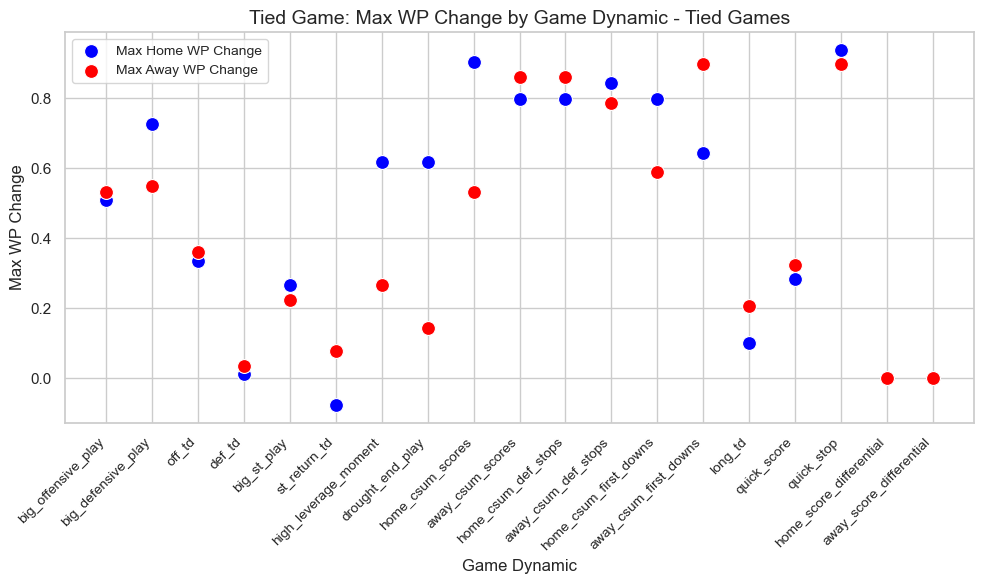


Tied Game: Sorted Game Dynamics by Mean WP Changes - Tied Games
Home WP Changes:
quick_stop: 0.938
home_csum_scores: 0.903
away_csum_def_stops: 0.845
away_csum_scores: 0.799
home_csum_def_stops: 0.799
home_csum_first_downs: 0.799
big_defensive_play: 0.728
away_csum_first_downs: 0.643
high_leverage_moment: 0.619
drought_end_play: 0.619
big_offensive_play: 0.509
off_td: 0.334
quick_score: 0.284
big_st_play: 0.267
long_td: 0.101
def_td: 0.012
home_score_differential: 0.000
away_score_differential: 0.000
st_return_td: -0.077

Away WP Changes:
quick_stop: 0.897
away_csum_first_downs: 0.897
away_csum_scores: 0.861
home_csum_def_stops: 0.861
away_csum_def_stops: 0.786
home_csum_first_downs: 0.591
big_defensive_play: 0.549
home_csum_scores: 0.532
big_offensive_play: 0.532
off_td: 0.361
quick_score: 0.323
high_leverage_moment: 0.265
big_st_play: 0.224
long_td: 0.205
drought_end_play: 0.144
st_return_td: 0.077
def_td: 0.035
home_score_differential: 0.000
away_score_differential: 0.000


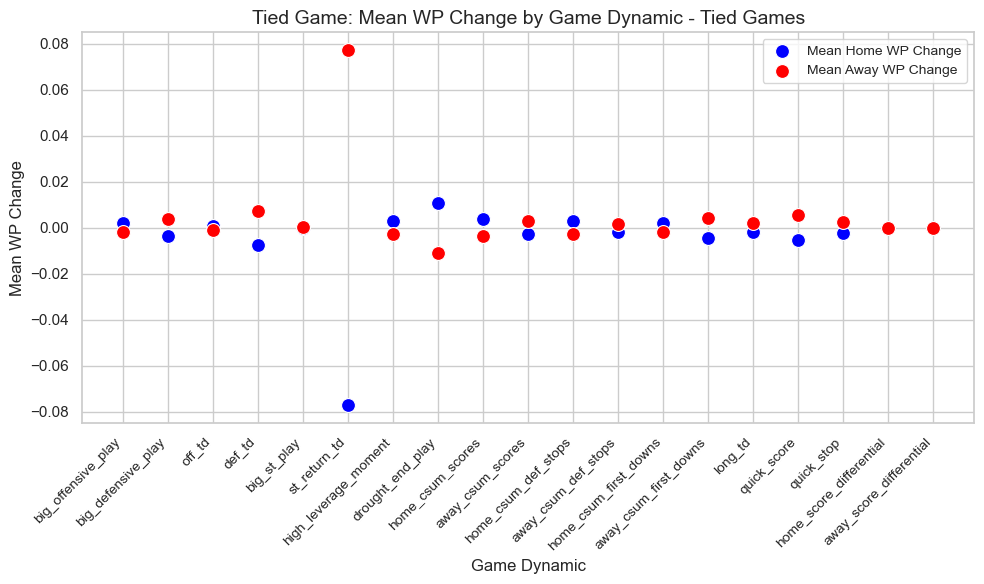

In [6]:
scoring_ranges = {
    'Tied Game': (dfV5['away_score_differential'] == 0)
}

all_dynamics = wp_change_analysis_df['game_dynamic'].unique()

for range_label, condition in scoring_ranges.items():
    range_df = dfV5[condition]
    wp_change_analysis = {}
    for dynamic_name, mask in dynamics: 
        wp_change_analysis[dynamic_name] = {
            'mean_home_wp_change': range_df.loc[mask, 'home_wp_change'].mean(),
            'max_home_wp_change': range_df.loc[mask, 'home_wp_change'].max(),
            'mean_away_wp_change': range_df.loc[mask, 'away_wp_change'].mean(),
            'max_away_wp_change': range_df.loc[mask, 'away_wp_change'].max(),
            'count': mask.sum(),
        }
    
    range_analysis_df = pd.DataFrame(wp_change_analysis).T.reset_index()
    range_analysis_df.columns = [
        'game_dynamic',
        'mean_home_wp_change',
        'max_home_wp_change',
        'mean_away_wp_change',
        'max_away_wp_change',
        'count',
    ]
    
    range_analysis_df = range_analysis_df.set_index('game_dynamic').reindex(all_dynamics).reset_index()
    range_analysis_df.fillna(0, inplace=True)
    
    sorted_home_wp = range_analysis_df[['game_dynamic', 'max_home_wp_change']].sort_values(
        by='max_home_wp_change', ascending=False
    ).reset_index(drop=True)
    
    sorted_away_wp = range_analysis_df[['game_dynamic', 'max_away_wp_change']].sort_values(
        by='max_away_wp_change', ascending=False
    ).reset_index(drop=True)

    print(f"\n{range_label}: Sorted Game Dynamics by Max WP Changes - Tied Games")
    print("Home WP Changes:")
    for dynamic, max_value in sorted_home_wp.values:
        print(f"{dynamic}: {max_value:.3f}")
    
    print("\nAway WP Changes:")
    for dynamic, max_value in sorted_away_wp.values:
        print(f"{dynamic}: {max_value:.3f}")
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='game_dynamic',
        y='max_home_wp_change',
        data=range_analysis_df,
        color='blue',
        s=100,
        label='Max Home WP Change',
    )
    sns.scatterplot(
        x='game_dynamic',
        y='max_away_wp_change',
        data=range_analysis_df,
        color='red',
        s=100,
        label='Max Away WP Change',
    )
    
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.xlabel('Game Dynamic', fontsize=12)
    plt.ylabel('Max WP Change', fontsize=12)
    plt.title(f'{range_label}: Max WP Change by Game Dynamic - Tied Games', fontsize=14)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

    print(f"\n{range_label}: Sorted Game Dynamics by Mean WP Changes - Tied Games")
    print("Home WP Changes:")
    for dynamic, mean_value in sorted_home_wp.values:
        print(f"{dynamic}: {mean_value:.3f}")
    
    print("\nAway WP Changes:")
    for dynamic, mean_value in sorted_away_wp.values:
        print(f"{dynamic}: {mean_value:.3f}")

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='game_dynamic',
        y='mean_home_wp_change',
        data=range_analysis_df,
        color='blue',
        s=100,
        label='Mean Home WP Change',
    )
    sns.scatterplot(
        x='game_dynamic',
        y='mean_away_wp_change',
        data=range_analysis_df,
        color='red',
        s=100,
        label='Mean Away WP Change',
    )
    
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.xlabel('Game Dynamic', fontsize=12)
    plt.ylabel('Mean WP Change', fontsize=12)
    plt.title(f'{range_label}: Mean WP Change by Game Dynamic - Tied Games', fontsize=14)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

# Testing different quarters - 1st quarter, 2nd quarter, 3rd quarter, 4th quarter


1st Quarter: Sorted Game Dynamics by Max WP Changes
Home WP Changes:
quick_stop: 0.709
away_csum_first_downs: 0.657
home_csum_first_downs: 0.552
big_offensive_play: 0.537
quick_score: 0.537
long_td: 0.537
away_csum_scores: 0.537
off_td: 0.537
big_defensive_play: 0.523
home_csum_def_stops: 0.510
def_td: 0.505
away_csum_def_stops: 0.499
drought_end_play: 0.390
home_csum_scores: 0.390
away_score_differential: 0.281
home_score_differential: 0.241
big_st_play: 0.152
st_return_td: 0.076
high_leverage_moment: 0.000

Away WP Changes:
big_offensive_play: 0.706
drought_end_play: 0.706
quick_score: 0.706
long_td: 0.706
home_csum_first_downs: 0.706
home_csum_scores: 0.706
away_score_differential: 0.706
off_td: 0.706
away_csum_first_downs: 0.661
away_csum_scores: 0.661
quick_stop: 0.642
big_defensive_play: 0.549
away_csum_def_stops: 0.514
home_csum_def_stops: 0.478
def_td: 0.371
home_score_differential: 0.224
big_st_play: 0.130
st_return_td: 0.079
high_leverage_moment: 0.000


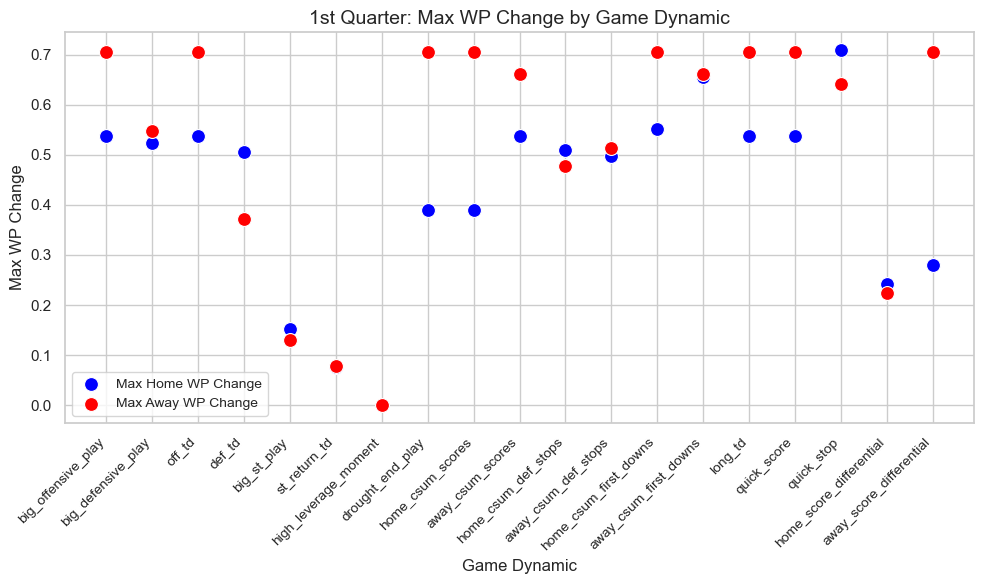


1st Quarter: Sorted Game Dynamics by Mean WP Changes
Home WP Changes:
def_td: 0.008
st_return_td: 0.008
home_csum_scores: 0.003
home_csum_def_stops: 0.003
quick_score: 0.002
big_offensive_play: 0.002
big_st_play: 0.002
off_td: 0.002
away_score_differential: 0.001
home_score_differential: 0.000
high_leverage_moment: 0.000
home_csum_first_downs: -0.001
quick_stop: -0.001
away_csum_first_downs: -0.002
away_csum_def_stops: -0.002
away_csum_scores: -0.002
big_defensive_play: -0.003
long_td: -0.003
drought_end_play: -0.012

Away WP Changes:
drought_end_play: 0.012
long_td: 0.003
big_defensive_play: 0.003
away_csum_scores: 0.002
away_csum_def_stops: 0.002
away_csum_first_downs: 0.002
quick_stop: 0.001
home_csum_first_downs: 0.001
high_leverage_moment: 0.000
home_score_differential: -0.000
away_score_differential: -0.001
off_td: -0.002
big_st_play: -0.002
big_offensive_play: -0.002
quick_score: -0.002
home_csum_def_stops: -0.003
home_csum_scores: -0.003
st_return_td: -0.008
def_td: -0.008


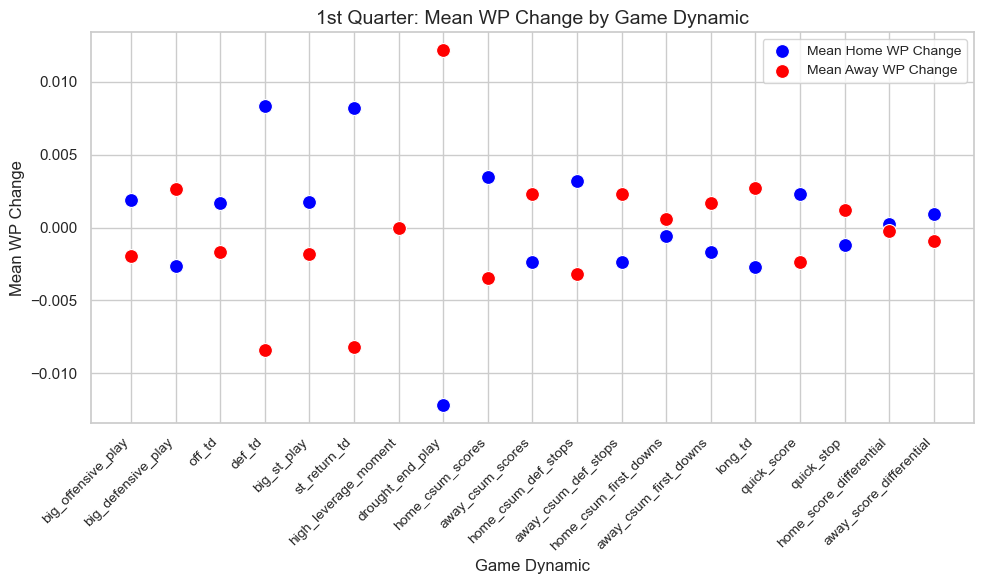


2nd Quarter: Sorted Game Dynamics by Max WP Changes
Home WP Changes:
home_csum_scores: 0.338
home_score_differential: 0.338
quick_stop: 0.338
away_csum_def_stops: 0.321
home_csum_def_stops: 0.321
away_csum_scores: 0.298
big_defensive_play: 0.297
away_csum_first_downs: 0.294
away_score_differential: 0.278
home_csum_first_downs: 0.268
quick_score: 0.229
off_td: 0.229
big_offensive_play: 0.229
long_td: 0.186
def_td: 0.137
drought_end_play: 0.136
big_st_play: 0.100
st_return_td: 0.074
high_leverage_moment: 0.000

Away WP Changes:
away_csum_def_stops: 0.324
quick_stop: 0.324
home_csum_first_downs: 0.324
home_csum_def_stops: 0.324
home_csum_scores: 0.305
away_csum_scores: 0.299
home_score_differential: 0.270
big_defensive_play: 0.261
off_td: 0.238
quick_score: 0.238
away_csum_first_downs: 0.238
away_score_differential: 0.213
big_offensive_play: 0.199
drought_end_play: 0.126
long_td: 0.121
big_st_play: 0.105
def_td: 0.091
st_return_td: 0.082
high_leverage_moment: 0.000


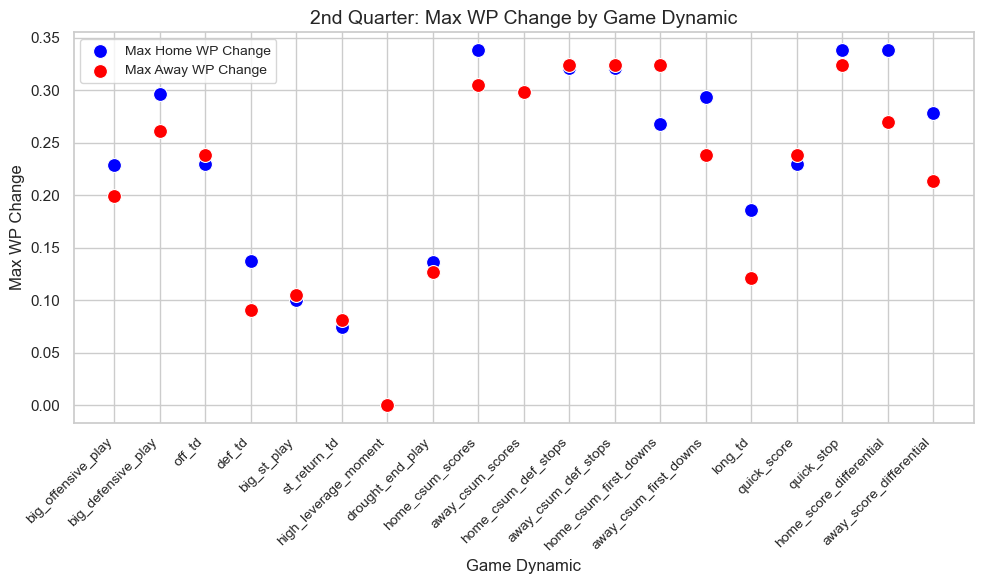


2nd Quarter: Sorted Game Dynamics by Mean WP Changes
Home WP Changes:
home_csum_def_stops: 0.004
home_csum_scores: 0.003
long_td: 0.002
def_td: 0.002
big_offensive_play: 0.002
drought_end_play: 0.001
off_td: 0.001
big_defensive_play: 0.001
home_csum_first_downs: 0.001
st_return_td: 0.001
quick_stop: 0.001
quick_score: 0.000
away_csum_first_downs: 0.000
high_leverage_moment: 0.000
home_score_differential: -0.000
big_st_play: -0.000
away_score_differential: -0.001
away_csum_scores: -0.002
away_csum_def_stops: -0.002

Away WP Changes:
away_csum_def_stops: 0.002
away_csum_scores: 0.002
away_score_differential: 0.001
big_st_play: 0.000
home_score_differential: 0.000
high_leverage_moment: 0.000
away_csum_first_downs: -0.000
quick_score: -0.000
quick_stop: -0.001
st_return_td: -0.001
home_csum_first_downs: -0.001
big_defensive_play: -0.001
off_td: -0.001
drought_end_play: -0.001
big_offensive_play: -0.002
def_td: -0.002
long_td: -0.002
home_csum_scores: -0.003
home_csum_def_stops: -0.004


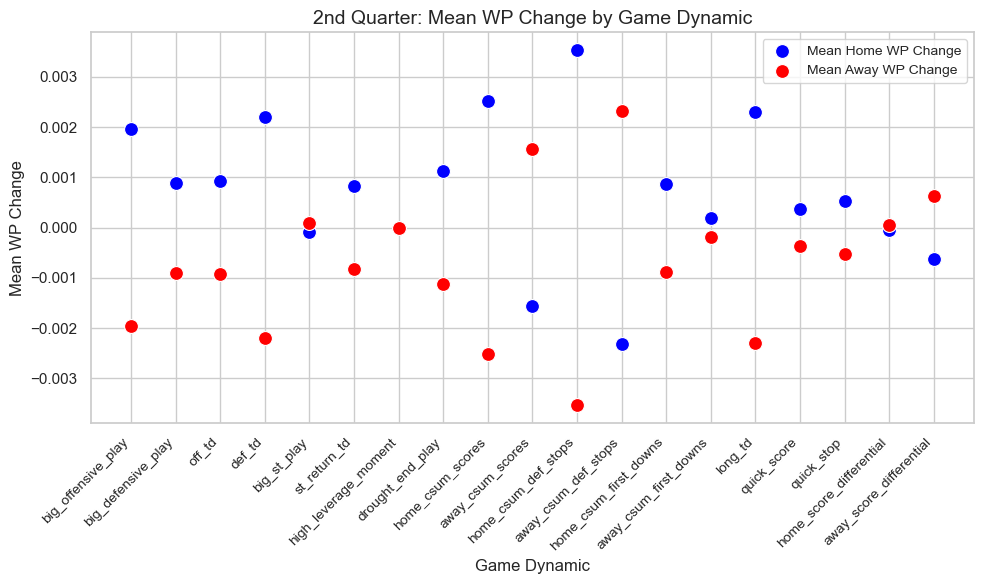


3rd Quarter: Sorted Game Dynamics by Max WP Changes
Home WP Changes:
home_csum_scores: 0.354
home_csum_first_downs: 0.354
home_csum_def_stops: 0.354
quick_stop: 0.332
away_csum_def_stops: 0.332
big_defensive_play: 0.332
away_csum_scores: 0.324
away_score_differential: 0.293
home_score_differential: 0.281
away_csum_first_downs: 0.271
big_offensive_play: 0.222
off_td: 0.218
quick_score: 0.204
drought_end_play: 0.191
long_td: 0.134
big_st_play: 0.125
def_td: 0.122
st_return_td: 0.097
high_leverage_moment: 0.000

Away WP Changes:
home_csum_scores: 0.434
away_csum_def_stops: 0.434
home_csum_def_stops: 0.434
home_score_differential: 0.339
quick_stop: 0.339
home_csum_first_downs: 0.318
away_score_differential: 0.296
away_csum_scores: 0.289
quick_score: 0.266
off_td: 0.266
away_csum_first_downs: 0.254
big_defensive_play: 0.237
drought_end_play: 0.207
big_offensive_play: 0.177
long_td: 0.175
big_st_play: 0.138
def_td: 0.112
st_return_td: 0.048
high_leverage_moment: 0.000


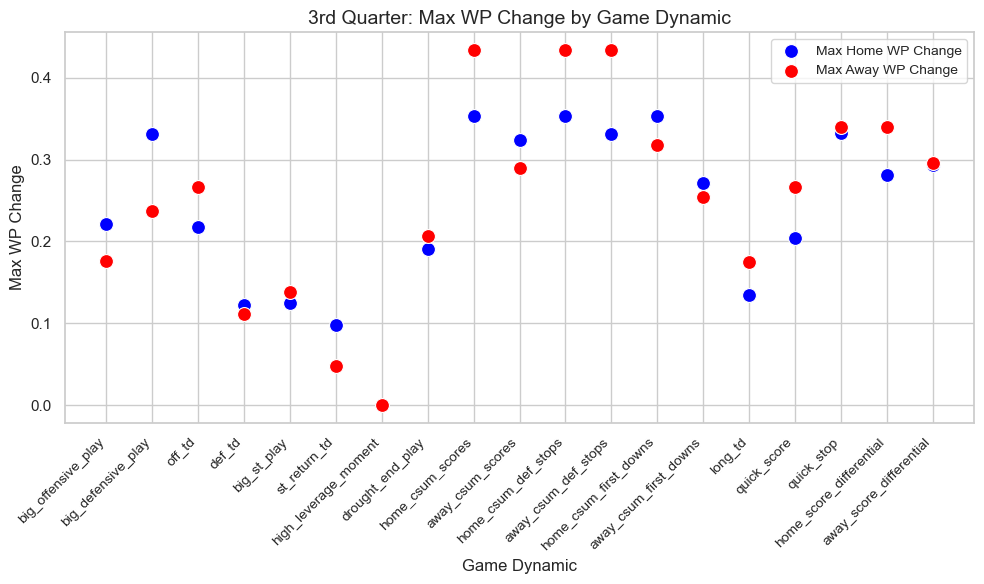


3rd Quarter: Sorted Game Dynamics by Mean WP Changes
Home WP Changes:
home_score_differential: 0.003
home_csum_def_stops: 0.002
home_csum_scores: 0.002
away_csum_first_downs: 0.001
big_defensive_play: 0.001
quick_stop: 0.000
home_csum_first_downs: 0.000
big_st_play: 0.000
big_offensive_play: 0.000
high_leverage_moment: 0.000
off_td: -0.000
away_score_differential: -0.000
quick_score: -0.000
drought_end_play: -0.001
long_td: -0.001
st_return_td: -0.001
away_csum_scores: -0.002
away_csum_def_stops: -0.003
def_td: -0.004

Away WP Changes:
def_td: 0.004
away_csum_def_stops: 0.003
away_csum_scores: 0.002
st_return_td: 0.001
long_td: 0.001
drought_end_play: 0.001
quick_score: 0.000
away_score_differential: 0.000
off_td: 0.000
high_leverage_moment: 0.000
big_offensive_play: -0.000
big_st_play: -0.000
home_csum_first_downs: -0.000
quick_stop: -0.000
big_defensive_play: -0.001
away_csum_first_downs: -0.001
home_csum_scores: -0.002
home_csum_def_stops: -0.002
home_score_differential: -0.003


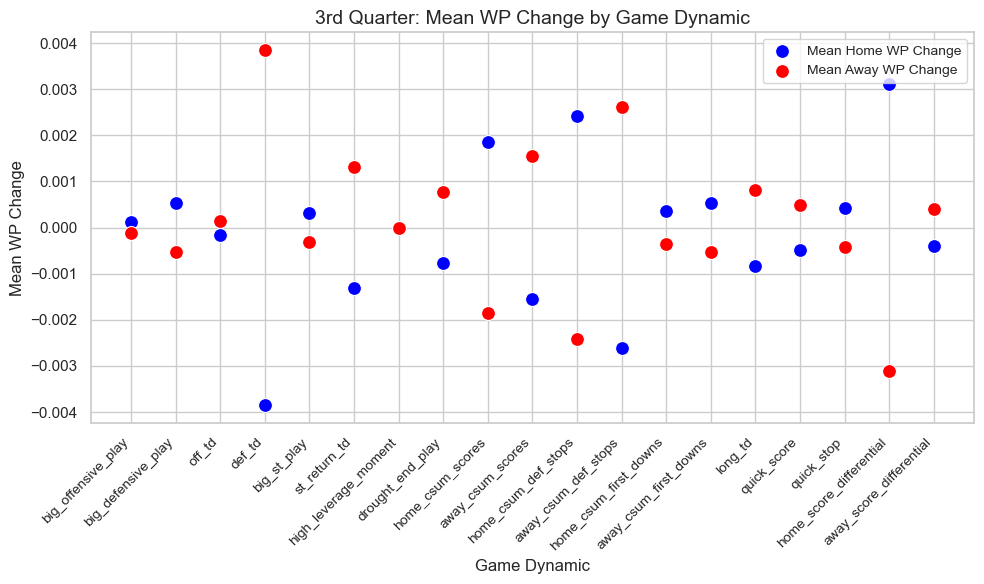


4th Quarter: Sorted Game Dynamics by Max WP Changes
Home WP Changes:
quick_stop: 0.938
home_csum_scores: 0.929
away_csum_scores: 0.908
away_csum_def_stops: 0.908
home_csum_def_stops: 0.908
away_csum_first_downs: 0.891
home_score_differential: 0.870
home_csum_first_downs: 0.799
big_offensive_play: 0.783
high_leverage_moment: 0.759
big_defensive_play: 0.728
away_score_differential: 0.644
drought_end_play: 0.619
quick_score: 0.609
off_td: 0.609
big_st_play: 0.376
long_td: 0.299
def_td: 0.131
st_return_td: 0.063

Away WP Changes:
away_csum_scores: 0.941
away_csum_def_stops: 0.941
off_td: 0.928
quick_stop: 0.900
home_csum_first_downs: 0.900
away_csum_first_downs: 0.897
home_csum_def_stops: 0.861
away_score_differential: 0.855
home_score_differential: 0.846
drought_end_play: 0.825
quick_score: 0.825
home_csum_scores: 0.709
big_offensive_play: 0.607
high_leverage_moment: 0.583
big_defensive_play: 0.489
long_td: 0.256
big_st_play: 0.190
def_td: 0.143
st_return_td: 0.126


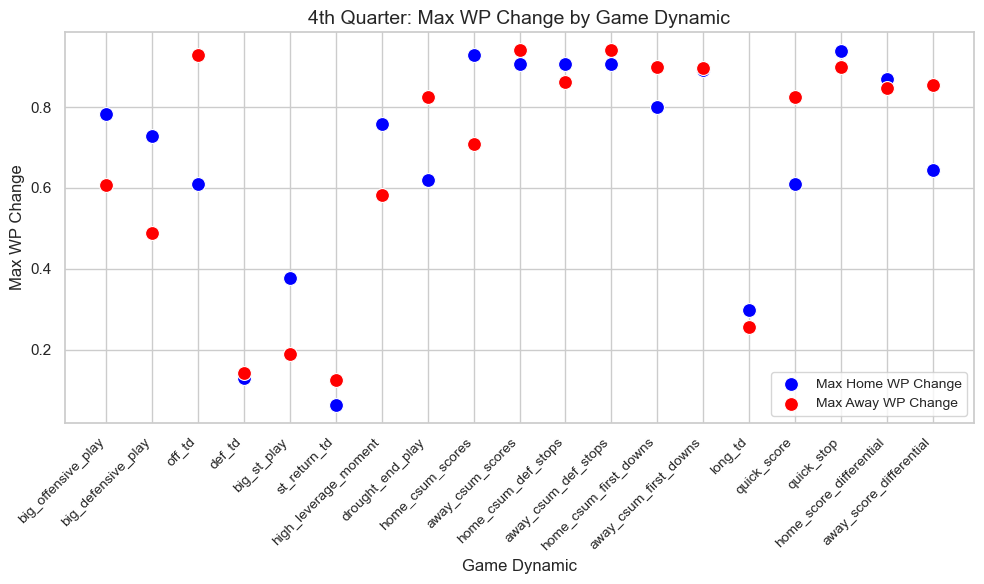


4th Quarter: Sorted Game Dynamics by Mean WP Changes
Home WP Changes:
home_score_differential: 0.005
long_td: 0.004
home_csum_def_stops: 0.003
home_csum_scores: 0.003
home_csum_first_downs: 0.003
big_defensive_play: 0.001
quick_stop: 0.001
big_offensive_play: 0.001
high_leverage_moment: 0.000
off_td: -0.000
drought_end_play: -0.000
big_st_play: -0.000
away_csum_first_downs: -0.001
away_csum_scores: -0.002
away_csum_def_stops: -0.002
quick_score: -0.003
def_td: -0.003
away_score_differential: -0.004
st_return_td: -0.010

Away WP Changes:
st_return_td: 0.010
away_score_differential: 0.004
def_td: 0.003
quick_score: 0.003
away_csum_def_stops: 0.002
away_csum_scores: 0.002
away_csum_first_downs: 0.001
big_st_play: 0.000
drought_end_play: 0.000
off_td: 0.000
high_leverage_moment: -0.000
big_offensive_play: -0.001
quick_stop: -0.001
big_defensive_play: -0.001
home_csum_first_downs: -0.003
home_csum_scores: -0.003
home_csum_def_stops: -0.003
long_td: -0.004
home_score_differential: -0.005


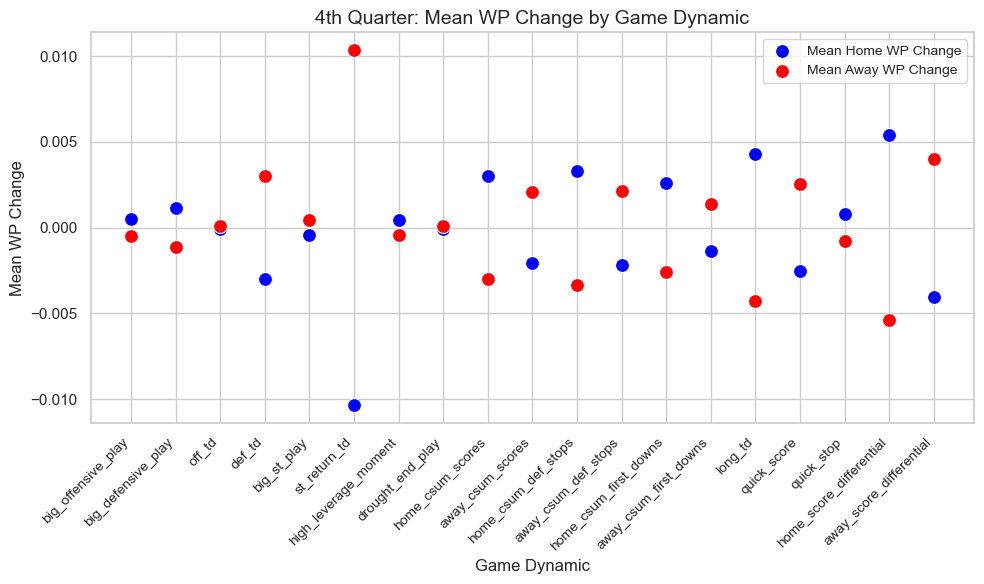

In [7]:
scoring_ranges = {
    '1st Quarter': (dfV5['qtr'] == 1),
    '2nd Quarter': (dfV5['qtr'] == 2),
    '3rd Quarter': (dfV5['qtr'] == 3),
    '4th Quarter': (dfV5['qtr'] == 4),
}
all_dynamics = wp_change_analysis_df['game_dynamic'].unique()

for quarter_label, condition in scoring_ranges.items():
    quarter_df = dfV5[condition]
    wp_change_analysis = {}
    for dynamic_name, mask in dynamics:  
        wp_change_analysis[dynamic_name] = {
            'mean_home_wp_change': quarter_df.loc[mask, 'home_wp_change'].mean(),
            'max_home_wp_change': quarter_df.loc[mask, 'home_wp_change'].max(),
            'mean_away_wp_change': quarter_df.loc[mask, 'away_wp_change'].mean(),
            'max_away_wp_change': quarter_df.loc[mask, 'away_wp_change'].max(),
            'count': mask.sum(),
        }
    
    quarter_analysis_df = pd.DataFrame(wp_change_analysis).T.reset_index()
    quarter_analysis_df.columns = [
        'game_dynamic',
        'mean_home_wp_change',
        'max_home_wp_change',
        'mean_away_wp_change',
        'max_away_wp_change',
        'count',
    ]
    quarter_analysis_df = quarter_analysis_df.set_index('game_dynamic').reindex(all_dynamics).reset_index()
    quarter_analysis_df.fillna(0, inplace=True)

    sorted_home_wp = quarter_analysis_df[['game_dynamic', 'max_home_wp_change']].sort_values(
        by='max_home_wp_change', ascending=False
    ).reset_index(drop=True)
    
    sorted_away_wp = quarter_analysis_df[['game_dynamic', 'max_away_wp_change']].sort_values(
        by='max_away_wp_change', ascending=False
    ).reset_index(drop=True)
    
    print(f"\n{quarter_label}: Sorted Game Dynamics by Max WP Changes")
    print("Home WP Changes:")
    for dynamic, max_value in sorted_home_wp.values:
        print(f"{dynamic}: {max_value:.3f}")
    
    print("\nAway WP Changes:")
    for dynamic, max_value in sorted_away_wp.values:
        print(f"{dynamic}: {max_value:.3f}")
 
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='game_dynamic',
        y='max_home_wp_change',
        data=quarter_analysis_df,
        color='blue',
        s=100,
        label='Max Home WP Change',
    )
    sns.scatterplot(
        x='game_dynamic',
        y='max_away_wp_change',
        data=quarter_analysis_df,
        color='red',
        s=100,
        label='Max Away WP Change',
    )
    
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.xlabel('Game Dynamic', fontsize=12)
    plt.ylabel('Max WP Change', fontsize=12)
    plt.title(f'{quarter_label}: Max WP Change by Game Dynamic', fontsize=14)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

    sorted_home_wp_mean = quarter_analysis_df[['game_dynamic', 'mean_home_wp_change']].sort_values(
        by='mean_home_wp_change', ascending=False
    ).reset_index(drop=True)
    
    sorted_away_wp_mean = quarter_analysis_df[['game_dynamic', 'mean_away_wp_change']].sort_values(
        by='mean_away_wp_change', ascending=False
    ).reset_index(drop=True)
    
    print(f"\n{quarter_label}: Sorted Game Dynamics by Mean WP Changes")
    print("Home WP Changes:")
    for dynamic, mean_value in sorted_home_wp_mean.values:
        print(f"{dynamic}: {mean_value:.3f}")
    
    print("\nAway WP Changes:")
    for dynamic, mean_value in sorted_away_wp_mean.values:
        print(f"{dynamic}: {mean_value:.3f}")

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='game_dynamic',
        y='mean_home_wp_change',
        data=quarter_analysis_df,
        color='blue',
        s=100,
        label='Mean Home WP Change',
    )
    sns.scatterplot(
        x='game_dynamic',
        y='mean_away_wp_change',
        data=quarter_analysis_df,
        color='red',
        s=100,
        label='Mean Away WP Change',
    )
  
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.xlabel('Game Dynamic', fontsize=12)
    plt.ylabel('Mean WP Change', fontsize=12)
    plt.title(f'{quarter_label}: Mean WP Change by Game Dynamic', fontsize=14)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

# Testing Quarters and Score Combos (Combos of biggest range changes) - 
## 1st quarter and 1 score lead (away), 4th quarter and 1 score game (away), Tied Game 1st quarter, tied game 4th quarter


Tied Game Early: Sorted Game Dynamics by Max WP Changes
Home WP Changes:
quick_stop: 0.612
home_csum_first_downs: 0.552
away_csum_first_downs: 0.543
big_defensive_play: 0.523
home_csum_def_stops: 0.510
big_offensive_play: 0.509
away_csum_def_stops: 0.499
home_csum_scores: 0.248
away_csum_scores: 0.224
quick_score: 0.127
off_td: 0.127
big_st_play: 0.105
drought_end_play: 0.069
long_td: 0.034
high_leverage_moment: 0.000
st_return_td: 0.000
home_score_differential: 0.000
away_score_differential: 0.000
def_td: -0.021

Away WP Changes:
quick_stop: 0.642
away_csum_first_downs: 0.596
big_defensive_play: 0.549
home_csum_first_downs: 0.534
away_csum_def_stops: 0.514
big_offensive_play: 0.507
home_csum_def_stops: 0.478
away_csum_scores: 0.270
long_td: 0.205
quick_score: 0.205
off_td: 0.205
home_csum_scores: 0.184
big_st_play: 0.119
drought_end_play: 0.029
def_td: 0.021
high_leverage_moment: 0.000
st_return_td: 0.000
home_score_differential: 0.000
away_score_differential: 0.000


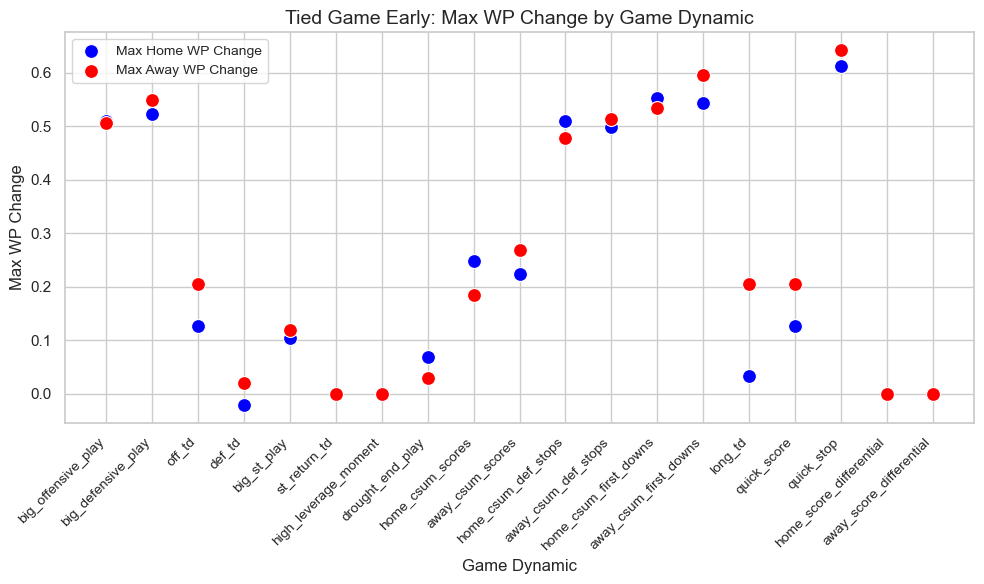


Tied Game Early: Sorted Game Dynamics by Mean WP Changes
Home WP Changes:
quick_stop: 0.612
home_csum_first_downs: 0.552
away_csum_first_downs: 0.543
big_defensive_play: 0.523
home_csum_def_stops: 0.510
big_offensive_play: 0.509
away_csum_def_stops: 0.499
home_csum_scores: 0.248
away_csum_scores: 0.224
quick_score: 0.127
off_td: 0.127
big_st_play: 0.105
drought_end_play: 0.069
long_td: 0.034
high_leverage_moment: 0.000
st_return_td: 0.000
home_score_differential: 0.000
away_score_differential: 0.000
def_td: -0.021

Away WP Changes:
quick_stop: 0.642
away_csum_first_downs: 0.596
big_defensive_play: 0.549
home_csum_first_downs: 0.534
away_csum_def_stops: 0.514
big_offensive_play: 0.507
home_csum_def_stops: 0.478
away_csum_scores: 0.270
long_td: 0.205
quick_score: 0.205
off_td: 0.205
home_csum_scores: 0.184
big_st_play: 0.119
drought_end_play: 0.029
def_td: 0.021
high_leverage_moment: 0.000
st_return_td: 0.000
home_score_differential: 0.000
away_score_differential: 0.000


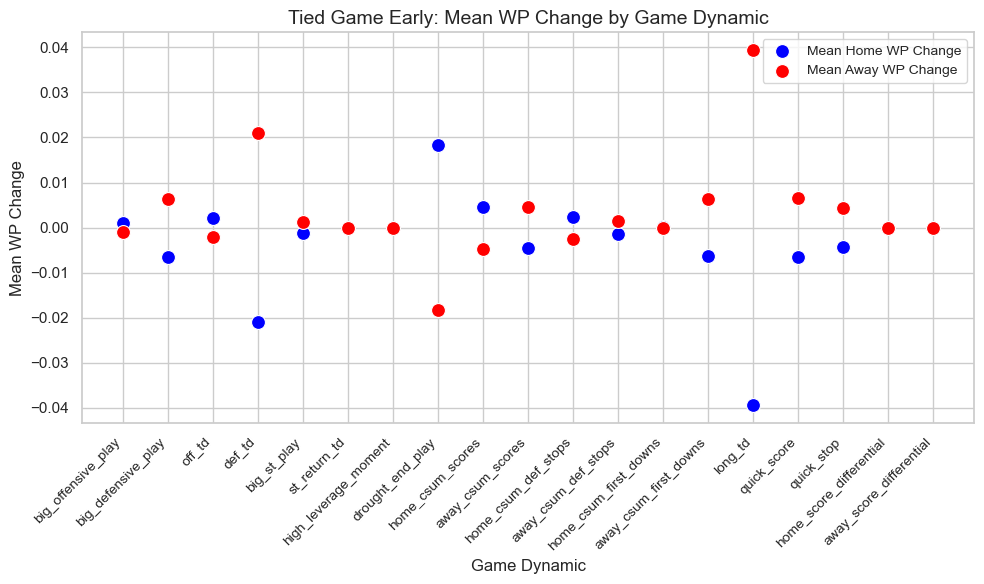


Tied Game Late: Sorted Game Dynamics by Max WP Changes
Home WP Changes:
quick_stop: 0.938
home_csum_scores: 0.903
away_csum_def_stops: 0.845
away_csum_scores: 0.799
home_csum_first_downs: 0.799
home_csum_def_stops: 0.799
big_defensive_play: 0.728
high_leverage_moment: 0.619
drought_end_play: 0.619
away_csum_first_downs: 0.409
off_td: 0.334
quick_score: 0.284
big_offensive_play: 0.274
big_st_play: 0.118
long_td: 0.048
def_td: 0.012
st_return_td: 0.000
home_score_differential: 0.000
away_score_differential: 0.000

Away WP Changes:
away_csum_first_downs: 0.897
quick_stop: 0.897
away_csum_scores: 0.861
home_csum_def_stops: 0.861
away_csum_def_stops: 0.786
home_csum_scores: 0.489
big_defensive_play: 0.489
home_csum_first_downs: 0.443
off_td: 0.361
quick_score: 0.323
high_leverage_moment: 0.265
drought_end_play: 0.144
big_st_play: 0.143
big_offensive_play: 0.135
long_td: 0.021
def_td: 0.003
st_return_td: 0.000
home_score_differential: 0.000
away_score_differential: 0.000


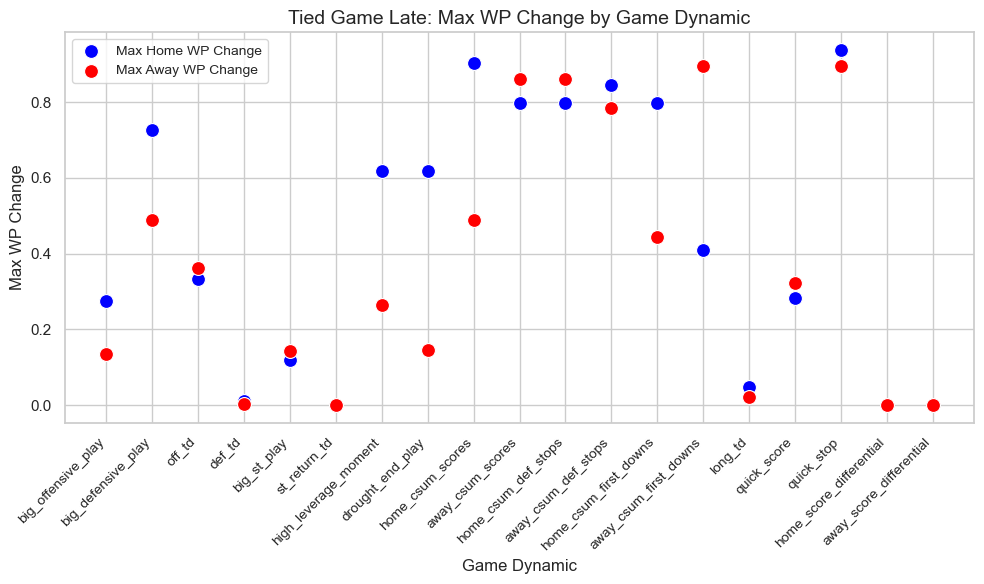


Tied Game Late: Sorted Game Dynamics by Mean WP Changes
Home WP Changes:
quick_stop: 0.938
home_csum_scores: 0.903
away_csum_def_stops: 0.845
away_csum_scores: 0.799
home_csum_first_downs: 0.799
home_csum_def_stops: 0.799
big_defensive_play: 0.728
high_leverage_moment: 0.619
drought_end_play: 0.619
away_csum_first_downs: 0.409
off_td: 0.334
quick_score: 0.284
big_offensive_play: 0.274
big_st_play: 0.118
long_td: 0.048
def_td: 0.012
st_return_td: 0.000
home_score_differential: 0.000
away_score_differential: 0.000

Away WP Changes:
away_csum_first_downs: 0.897
quick_stop: 0.897
away_csum_scores: 0.861
home_csum_def_stops: 0.861
away_csum_def_stops: 0.786
home_csum_scores: 0.489
big_defensive_play: 0.489
home_csum_first_downs: 0.443
off_td: 0.361
quick_score: 0.323
high_leverage_moment: 0.265
drought_end_play: 0.144
big_st_play: 0.143
big_offensive_play: 0.135
long_td: 0.021
def_td: 0.003
st_return_td: 0.000
home_score_differential: 0.000
away_score_differential: 0.000


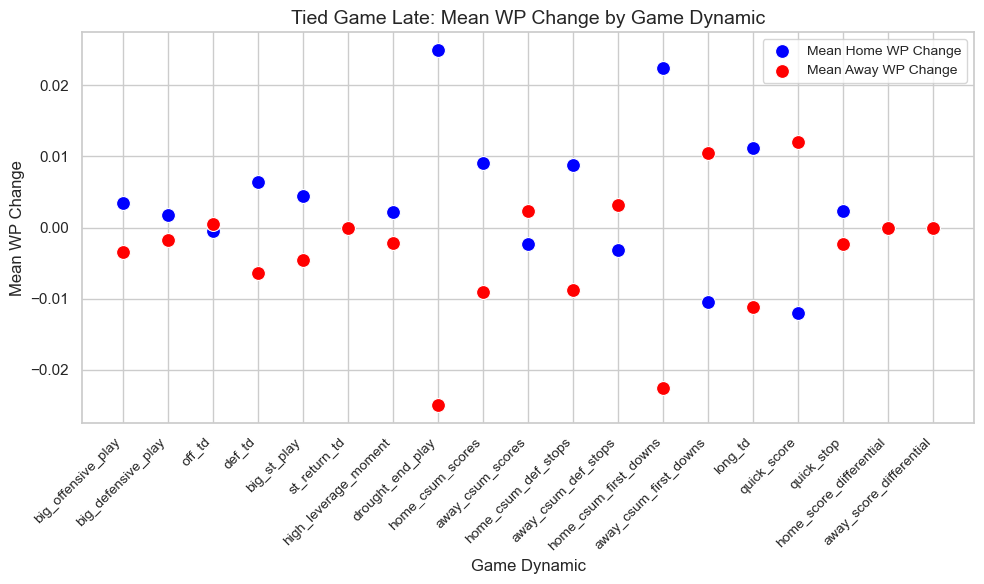


1 Score Early Game: Sorted Game Dynamics by Max WP Changes
Home WP Changes:
quick_stop: 0.612
home_csum_first_downs: 0.552
away_csum_first_downs: 0.543
big_offensive_play: 0.537
quick_score: 0.537
long_td: 0.537
away_csum_scores: 0.537
off_td: 0.537
big_defensive_play: 0.523
home_csum_def_stops: 0.510
away_csum_def_stops: 0.499
away_score_differential: 0.281
home_csum_scores: 0.248
big_st_play: 0.112
def_td: 0.071
drought_end_play: 0.069
high_leverage_moment: 0.000
home_score_differential: 0.000
st_return_td: -0.011

Away WP Changes:
big_offensive_play: 0.706
drought_end_play: 0.706
quick_score: 0.706
long_td: 0.706
home_csum_first_downs: 0.706
home_csum_scores: 0.706
away_score_differential: 0.706
off_td: 0.706
away_csum_first_downs: 0.661
away_csum_scores: 0.661
quick_stop: 0.642
big_defensive_play: 0.549
away_csum_def_stops: 0.514
home_csum_def_stops: 0.478
big_st_play: 0.119
st_return_td: 0.069
def_td: 0.046
high_leverage_moment: 0.000
home_score_differential: 0.000


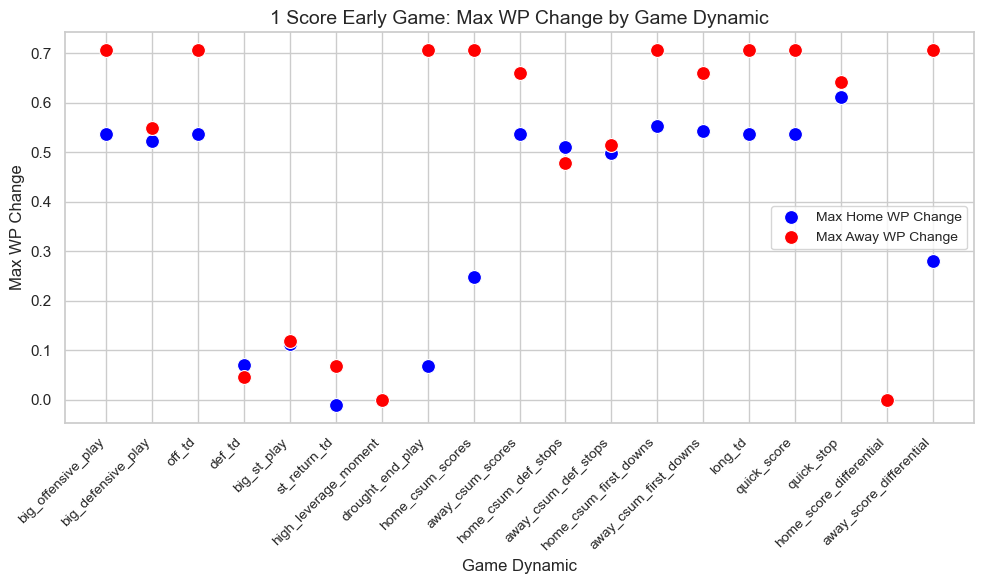


1 Score Early Game: Sorted Game Dynamics by Mean WP Changes
Home WP Changes:
quick_stop: 0.612
home_csum_first_downs: 0.552
away_csum_first_downs: 0.543
big_offensive_play: 0.537
quick_score: 0.537
long_td: 0.537
away_csum_scores: 0.537
off_td: 0.537
big_defensive_play: 0.523
home_csum_def_stops: 0.510
away_csum_def_stops: 0.499
away_score_differential: 0.281
home_csum_scores: 0.248
big_st_play: 0.112
def_td: 0.071
drought_end_play: 0.069
high_leverage_moment: 0.000
home_score_differential: 0.000
st_return_td: -0.011

Away WP Changes:
big_offensive_play: 0.706
drought_end_play: 0.706
quick_score: 0.706
long_td: 0.706
home_csum_first_downs: 0.706
home_csum_scores: 0.706
away_score_differential: 0.706
off_td: 0.706
away_csum_first_downs: 0.661
away_csum_scores: 0.661
quick_stop: 0.642
big_defensive_play: 0.549
away_csum_def_stops: 0.514
home_csum_def_stops: 0.478
big_st_play: 0.119
st_return_td: 0.069
def_td: 0.046
high_leverage_moment: 0.000
home_score_differential: 0.000


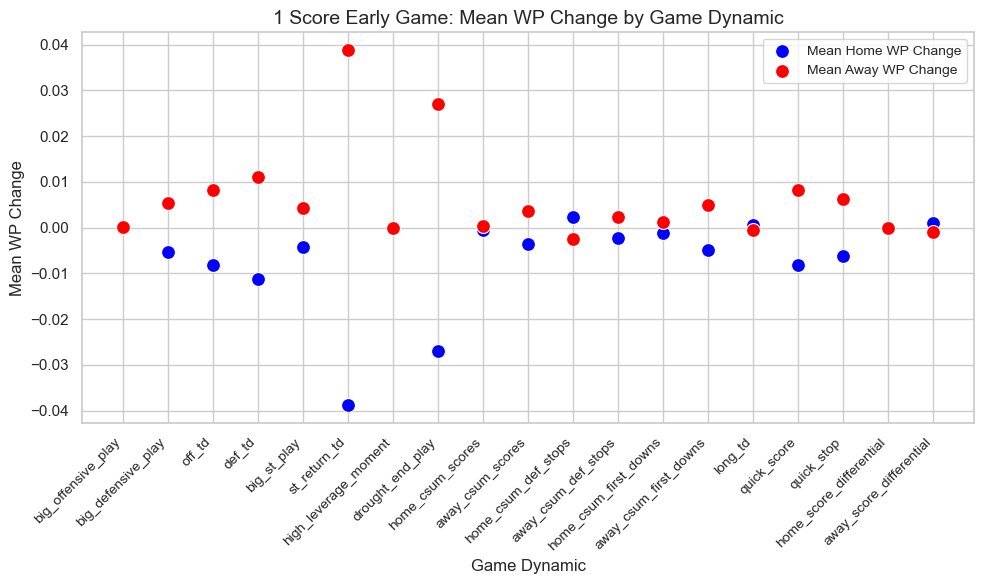


1 Score Late Game: Sorted Game Dynamics by Max WP Changes
Home WP Changes:
quick_stop: 0.938
home_csum_scores: 0.903
away_csum_def_stops: 0.845
away_csum_scores: 0.799
home_csum_first_downs: 0.799
home_csum_def_stops: 0.799
big_defensive_play: 0.728
big_offensive_play: 0.644
away_score_differential: 0.644
drought_end_play: 0.619
high_leverage_moment: 0.619
away_csum_first_downs: 0.409
off_td: 0.334
quick_score: 0.329
long_td: 0.299
def_td: 0.131
big_st_play: 0.118
home_score_differential: 0.000
st_return_td: -0.005

Away WP Changes:
away_csum_scores: 0.928
off_td: 0.928
quick_stop: 0.900
home_csum_first_downs: 0.900
away_csum_def_stops: 0.900
away_csum_first_downs: 0.897
home_csum_def_stops: 0.861
away_score_differential: 0.855
drought_end_play: 0.825
quick_score: 0.825
home_csum_scores: 0.679
big_offensive_play: 0.607
high_leverage_moment: 0.583
big_defensive_play: 0.489
long_td: 0.256
big_st_play: 0.190
st_return_td: 0.126
def_td: 0.126
home_score_differential: 0.000


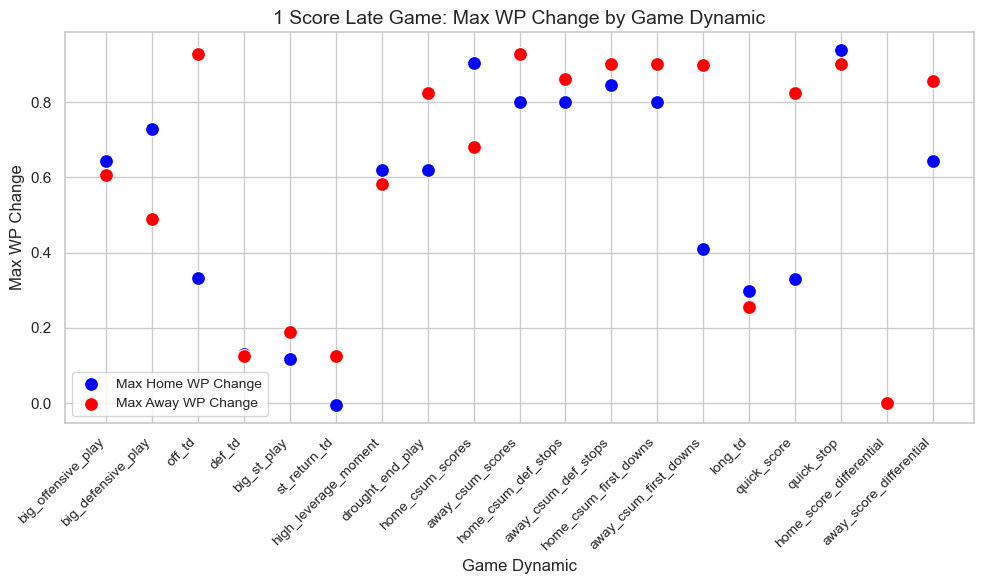


1 Score Late Game: Sorted Game Dynamics by Mean WP Changes
Home WP Changes:
quick_stop: 0.938
home_csum_scores: 0.903
away_csum_def_stops: 0.845
away_csum_scores: 0.799
home_csum_first_downs: 0.799
home_csum_def_stops: 0.799
big_defensive_play: 0.728
big_offensive_play: 0.644
away_score_differential: 0.644
drought_end_play: 0.619
high_leverage_moment: 0.619
away_csum_first_downs: 0.409
off_td: 0.334
quick_score: 0.329
long_td: 0.299
def_td: 0.131
big_st_play: 0.118
home_score_differential: 0.000
st_return_td: -0.005

Away WP Changes:
away_csum_scores: 0.928
off_td: 0.928
quick_stop: 0.900
home_csum_first_downs: 0.900
away_csum_def_stops: 0.900
away_csum_first_downs: 0.897
home_csum_def_stops: 0.861
away_score_differential: 0.855
drought_end_play: 0.825
quick_score: 0.825
home_csum_scores: 0.679
big_offensive_play: 0.607
high_leverage_moment: 0.583
big_defensive_play: 0.489
long_td: 0.256
big_st_play: 0.190
st_return_td: 0.126
def_td: 0.126
home_score_differential: 0.000


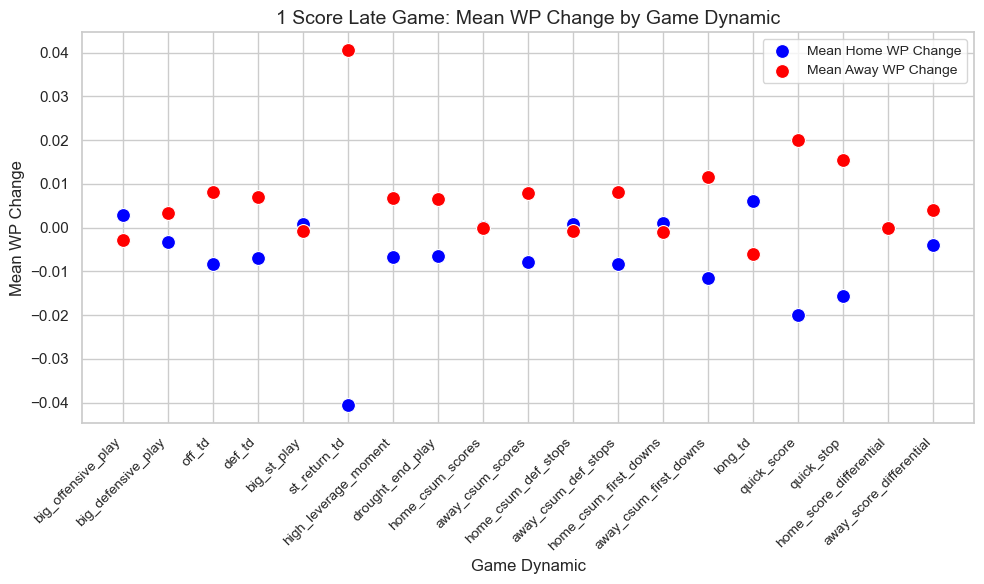

In [8]:
scoring_ranges = {
    'Tied Game Early': (dfV5['away_score_differential'] == 0) & (dfV5['qtr'] == 1),
    'Tied Game Late': (dfV5['away_score_differential'] == 0) & (dfV5['qtr'] == 4),
    '1 Score Early Game': ((dfV5['away_score_differential'] >= 0) & (dfV5['away_score_differential'] <= 8)) & (dfV5['qtr'] == 1),
    '1 Score Late Game': ((dfV5['away_score_differential'] >= 0) & (dfV5['away_score_differential'] <= 8)) & (dfV5['qtr'] == 4)
}

all_dynamics = wp_change_analysis_df['game_dynamic'].unique()

for range_label, condition in scoring_ranges.items():
    range_df = dfV5[condition]
    wp_change_analysis = {}
    for dynamic_name, mask in dynamics: 
        wp_change_analysis[dynamic_name] = {
            'mean_home_wp_change': range_df.loc[mask, 'home_wp_change'].mean(),
            'max_home_wp_change': range_df.loc[mask, 'home_wp_change'].max(),
            'mean_away_wp_change': range_df.loc[mask, 'away_wp_change'].mean(),
            'max_away_wp_change': range_df.loc[mask, 'away_wp_change'].max(),
            'count': mask.sum(),
        }
    
    range_analysis_df = pd.DataFrame(wp_change_analysis).T.reset_index()
    range_analysis_df.columns = [
        'game_dynamic',
        'mean_home_wp_change',
        'max_home_wp_change',
        'mean_away_wp_change',
        'max_away_wp_change',
        'count',
    ]
    
    range_analysis_df = range_analysis_df.set_index('game_dynamic').reindex(all_dynamics).reset_index()
    range_analysis_df.fillna(0, inplace=True)
    
    sorted_home_wp = range_analysis_df[['game_dynamic', 'max_home_wp_change']].sort_values(
        by='max_home_wp_change', ascending=False
    ).reset_index(drop=True)
    
    sorted_away_wp = range_analysis_df[['game_dynamic', 'max_away_wp_change']].sort_values(
        by='max_away_wp_change', ascending=False
    ).reset_index(drop=True)

    print(f"\n{range_label}: Sorted Game Dynamics by Max WP Changes")
    print("Home WP Changes:")
    for dynamic, max_value in sorted_home_wp.values:
        print(f"{dynamic}: {max_value:.3f}")
    
    print("\nAway WP Changes:")
    for dynamic, max_value in sorted_away_wp.values:
        print(f"{dynamic}: {max_value:.3f}")
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='game_dynamic',
        y='max_home_wp_change',
        data=range_analysis_df,
        color='blue',
        s=100,
        label='Max Home WP Change',
    )
    sns.scatterplot(
        x='game_dynamic',
        y='max_away_wp_change',
        data=range_analysis_df,
        color='red',
        s=100,
        label='Max Away WP Change',
    )
    
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.xlabel('Game Dynamic', fontsize=12)
    plt.ylabel('Max WP Change', fontsize=12)
    plt.title(f'{range_label}: Max WP Change by Game Dynamic', fontsize=14)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

    print(f"\n{range_label}: Sorted Game Dynamics by Mean WP Changes")
    print("Home WP Changes:")
    for dynamic, mean_value in sorted_home_wp.values:
        print(f"{dynamic}: {mean_value:.3f}")
    
    print("\nAway WP Changes:")
    for dynamic, mean_value in sorted_away_wp.values:
        print(f"{dynamic}: {mean_value:.3f}")

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='game_dynamic',
        y='mean_home_wp_change',
        data=range_analysis_df,
        color='blue',
        s=100,
        label='Mean Home WP Change',
    )
    sns.scatterplot(
        x='game_dynamic',
        y='mean_away_wp_change',
        data=range_analysis_df,
        color='red',
        s=100,
        label='Mean Away WP Change',
    )
    
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.xlabel('Game Dynamic', fontsize=12)
    plt.ylabel('Mean WP Change', fontsize=12)
    plt.title(f'{range_label}: Mean WP Change by Game Dynamic', fontsize=14)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

# Same combos but home team winning (dont need ties)


1 Score Early Game: Sorted Game Dynamics by Max WP Changes
Home WP Changes:
quick_stop: 0.709
away_csum_first_downs: 0.657
home_csum_first_downs: 0.552
big_defensive_play: 0.523
home_csum_def_stops: 0.510
big_offensive_play: 0.509
quick_score: 0.505
away_csum_scores: 0.505
def_td: 0.505
away_csum_def_stops: 0.499
home_csum_scores: 0.390
drought_end_play: 0.390
long_td: 0.390
off_td: 0.390
home_score_differential: 0.241
big_st_play: 0.152
st_return_td: 0.076
high_leverage_moment: 0.000
away_score_differential: 0.000

Away WP Changes:
quick_stop: 0.642
away_csum_first_downs: 0.596
big_defensive_play: 0.549
home_csum_first_downs: 0.534
away_csum_def_stops: 0.514
big_offensive_play: 0.507
home_csum_def_stops: 0.478
off_td: 0.418
quick_score: 0.418
long_td: 0.418
home_csum_scores: 0.418
drought_end_play: 0.392
away_csum_scores: 0.371
def_td: 0.371
home_score_differential: 0.224
big_st_play: 0.130
st_return_td: 0.021
high_leverage_moment: 0.000
away_score_differential: 0.000


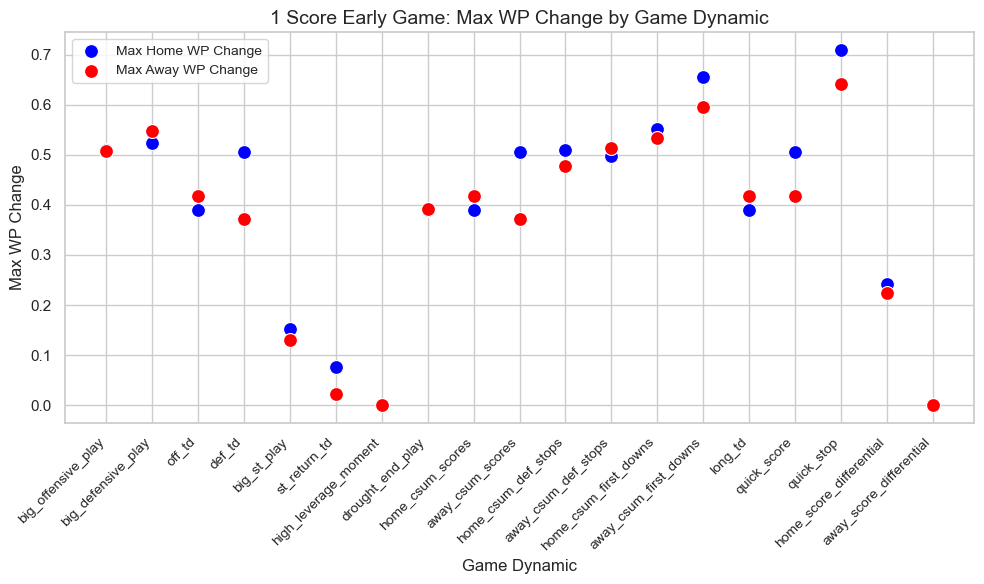


1 Score Early Game: Sorted Game Dynamics by Mean WP Changes
Home WP Changes:
quick_stop: 0.709
away_csum_first_downs: 0.657
home_csum_first_downs: 0.552
big_defensive_play: 0.523
home_csum_def_stops: 0.510
big_offensive_play: 0.509
quick_score: 0.505
away_csum_scores: 0.505
def_td: 0.505
away_csum_def_stops: 0.499
home_csum_scores: 0.390
drought_end_play: 0.390
long_td: 0.390
off_td: 0.390
home_score_differential: 0.241
big_st_play: 0.152
st_return_td: 0.076
high_leverage_moment: 0.000
away_score_differential: 0.000

Away WP Changes:
quick_stop: 0.642
away_csum_first_downs: 0.596
big_defensive_play: 0.549
home_csum_first_downs: 0.534
away_csum_def_stops: 0.514
big_offensive_play: 0.507
home_csum_def_stops: 0.478
off_td: 0.418
quick_score: 0.418
long_td: 0.418
home_csum_scores: 0.418
drought_end_play: 0.392
away_csum_scores: 0.371
def_td: 0.371
home_score_differential: 0.224
big_st_play: 0.130
st_return_td: 0.021
high_leverage_moment: 0.000
away_score_differential: 0.000


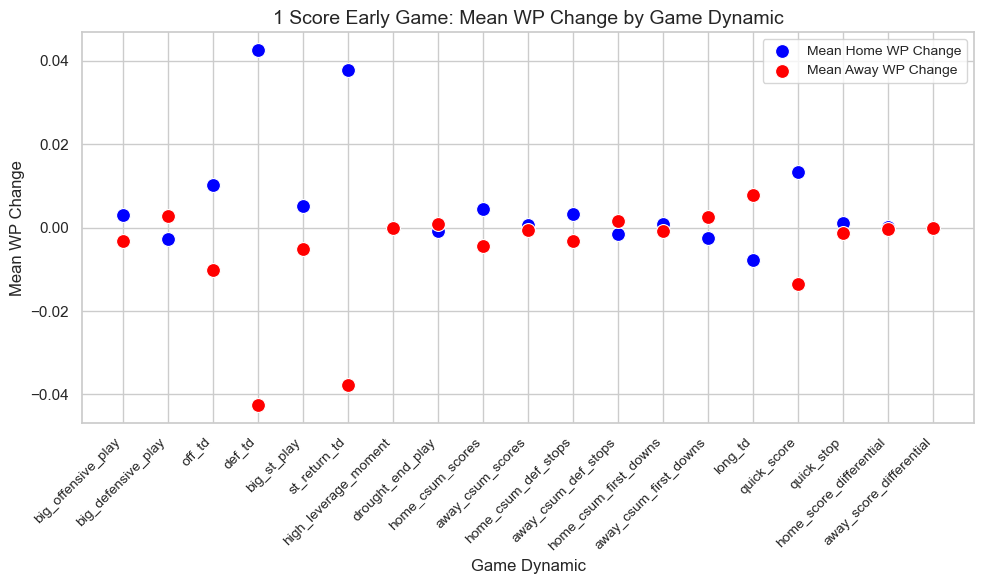


1 Score Late Game: Sorted Game Dynamics by Max WP Changes
Home WP Changes:
quick_stop: 0.938
home_csum_scores: 0.929
away_csum_scores: 0.908
away_csum_def_stops: 0.908
home_csum_def_stops: 0.908
away_csum_first_downs: 0.891
home_score_differential: 0.870
home_csum_first_downs: 0.799
big_offensive_play: 0.783
high_leverage_moment: 0.759
big_defensive_play: 0.728
drought_end_play: 0.619
quick_score: 0.609
off_td: 0.609
big_st_play: 0.376
long_td: 0.107
def_td: 0.093
st_return_td: 0.063
away_score_differential: 0.000

Away WP Changes:
away_csum_scores: 0.941
away_csum_def_stops: 0.941
away_csum_first_downs: 0.897
quick_stop: 0.897
home_csum_def_stops: 0.861
home_score_differential: 0.846
home_csum_scores: 0.709
big_defensive_play: 0.489
home_csum_first_downs: 0.443
off_td: 0.361
quick_score: 0.323
high_leverage_moment: 0.284
drought_end_play: 0.234
big_offensive_play: 0.231
big_st_play: 0.143
long_td: 0.087
def_td: 0.065
st_return_td: 0.015
away_score_differential: 0.000


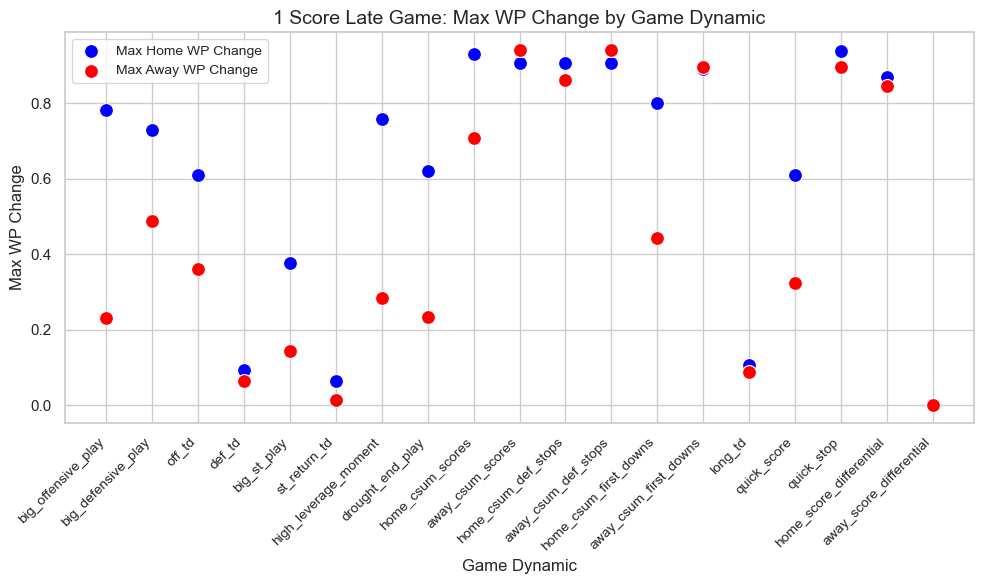


1 Score Late Game: Sorted Game Dynamics by Mean WP Changes
Home WP Changes:
quick_stop: 0.938
home_csum_scores: 0.929
away_csum_scores: 0.908
away_csum_def_stops: 0.908
home_csum_def_stops: 0.908
away_csum_first_downs: 0.891
home_score_differential: 0.870
home_csum_first_downs: 0.799
big_offensive_play: 0.783
high_leverage_moment: 0.759
big_defensive_play: 0.728
drought_end_play: 0.619
quick_score: 0.609
off_td: 0.609
big_st_play: 0.376
long_td: 0.107
def_td: 0.093
st_return_td: 0.063
away_score_differential: 0.000

Away WP Changes:
away_csum_scores: 0.941
away_csum_def_stops: 0.941
away_csum_first_downs: 0.897
quick_stop: 0.897
home_csum_def_stops: 0.861
home_score_differential: 0.846
home_csum_scores: 0.709
big_defensive_play: 0.489
home_csum_first_downs: 0.443
off_td: 0.361
quick_score: 0.323
high_leverage_moment: 0.284
drought_end_play: 0.234
big_offensive_play: 0.231
big_st_play: 0.143
long_td: 0.087
def_td: 0.065
st_return_td: 0.015
away_score_differential: 0.000


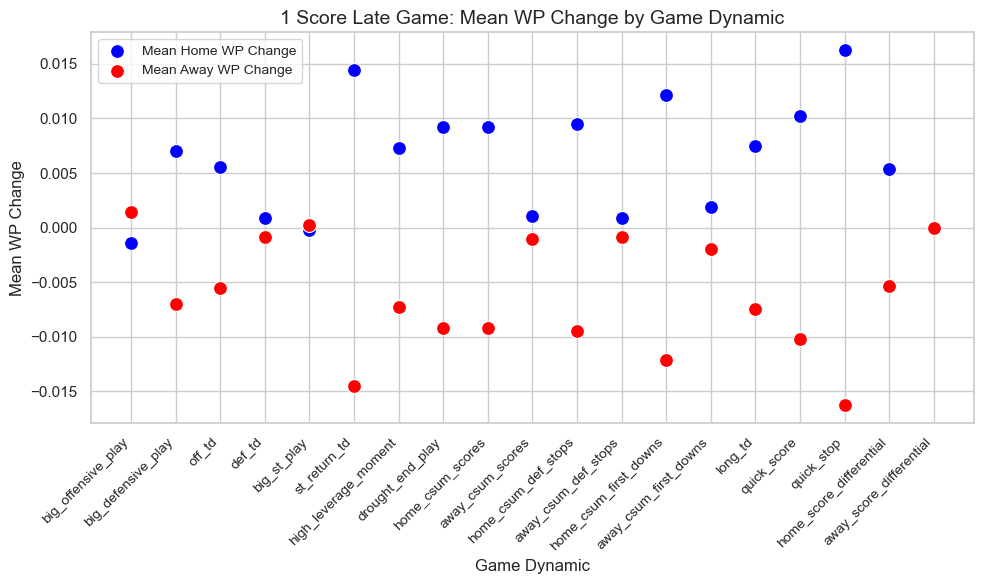

In [9]:
scoring_ranges = {
    '1 Score Early Game': ((dfV5['home_score_differential'] >= 0) & (dfV5['home_score_differential'] <= 8)) & (dfV5['qtr'] == 1),
    '1 Score Late Game': ((dfV5['home_score_differential'] >= 0) & (dfV5['home_score_differential'] <= 8)) & (dfV5['qtr'] == 4)
}

all_dynamics = wp_change_analysis_df['game_dynamic'].unique()

for range_label, condition in scoring_ranges.items():
    range_df = dfV5[condition]
    wp_change_analysis = {}
    for dynamic_name, mask in dynamics: 
        wp_change_analysis[dynamic_name] = {
            'mean_home_wp_change': range_df.loc[mask, 'home_wp_change'].mean(),
            'max_home_wp_change': range_df.loc[mask, 'home_wp_change'].max(),
            'mean_away_wp_change': range_df.loc[mask, 'away_wp_change'].mean(),
            'max_away_wp_change': range_df.loc[mask, 'away_wp_change'].max(),
            'count': mask.sum(),
        }
    
    range_analysis_df = pd.DataFrame(wp_change_analysis).T.reset_index()
    range_analysis_df.columns = [
        'game_dynamic',
        'mean_home_wp_change',
        'max_home_wp_change',
        'mean_away_wp_change',
        'max_away_wp_change',
        'count',
    ]
    
    range_analysis_df = range_analysis_df.set_index('game_dynamic').reindex(all_dynamics).reset_index()
    range_analysis_df.fillna(0, inplace=True)
    
    sorted_home_wp = range_analysis_df[['game_dynamic', 'max_home_wp_change']].sort_values(
        by='max_home_wp_change', ascending=False
    ).reset_index(drop=True)
    
    sorted_away_wp = range_analysis_df[['game_dynamic', 'max_away_wp_change']].sort_values(
        by='max_away_wp_change', ascending=False
    ).reset_index(drop=True)

    print(f"\n{range_label}: Sorted Game Dynamics by Max WP Changes")
    print("Home WP Changes:")
    for dynamic, max_value in sorted_home_wp.values:
        print(f"{dynamic}: {max_value:.3f}")
    
    print("\nAway WP Changes:")
    for dynamic, max_value in sorted_away_wp.values:
        print(f"{dynamic}: {max_value:.3f}")
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='game_dynamic',
        y='max_home_wp_change',
        data=range_analysis_df,
        color='blue',
        s=100,
        label='Max Home WP Change',
    )
    sns.scatterplot(
        x='game_dynamic',
        y='max_away_wp_change',
        data=range_analysis_df,
        color='red',
        s=100,
        label='Max Away WP Change',
    )
    
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.xlabel('Game Dynamic', fontsize=12)
    plt.ylabel('Max WP Change', fontsize=12)
    plt.title(f'{range_label}: Max WP Change by Game Dynamic', fontsize=14)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

    print(f"\n{range_label}: Sorted Game Dynamics by Mean WP Changes")
    print("Home WP Changes:")
    for dynamic, mean_value in sorted_home_wp.values:
        print(f"{dynamic}: {mean_value:.3f}")
    
    print("\nAway WP Changes:")
    for dynamic, mean_value in sorted_away_wp.values:
        print(f"{dynamic}: {mean_value:.3f}")

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='game_dynamic',
        y='mean_home_wp_change',
        data=range_analysis_df,
        color='blue',
        s=100,
        label='Mean Home WP Change',
    )
    sns.scatterplot(
        x='game_dynamic',
        y='mean_away_wp_change',
        data=range_analysis_df,
        color='red',
        s=100,
        label='Mean Away WP Change',
    )
    
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.xlabel('Game Dynamic', fontsize=12)
    plt.ylabel('Mean WP Change', fontsize=12)
    plt.title(f'{range_label}: Mean WP Change by Game Dynamic', fontsize=14)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

# Differentiating offense from defense, showing the same trends and values as before in tie games in 4th quarter


Tied Game Home Offense - 4th Quarter: Sorted Game Dynamics by Max WP Changes
Home WP Changes:
quick_stop: 0.938
home_csum_scores: 0.903
away_csum_def_stops: 0.845
away_csum_scores: 0.799
home_csum_first_downs: 0.799
home_csum_def_stops: 0.799
big_defensive_play: 0.728
high_leverage_moment: 0.619
drought_end_play: 0.619
away_csum_first_downs: 0.409
off_td: 0.334
quick_score: 0.284
big_offensive_play: 0.274
big_st_play: 0.118
long_td: 0.048
def_td: 0.012
st_return_td: 0.000
home_score_differential: 0.000
away_score_differential: 0.000

Away WP Changes:
away_csum_first_downs: 0.897
quick_stop: 0.897
away_csum_scores: 0.861
home_csum_def_stops: 0.861
away_csum_def_stops: 0.786
home_csum_scores: 0.489
big_defensive_play: 0.489
home_csum_first_downs: 0.443
off_td: 0.361
quick_score: 0.323
high_leverage_moment: 0.265
drought_end_play: 0.144
big_st_play: 0.143
big_offensive_play: 0.135
long_td: 0.021
def_td: 0.003
st_return_td: 0.000
home_score_differential: 0.000
away_score_differential: 0.0

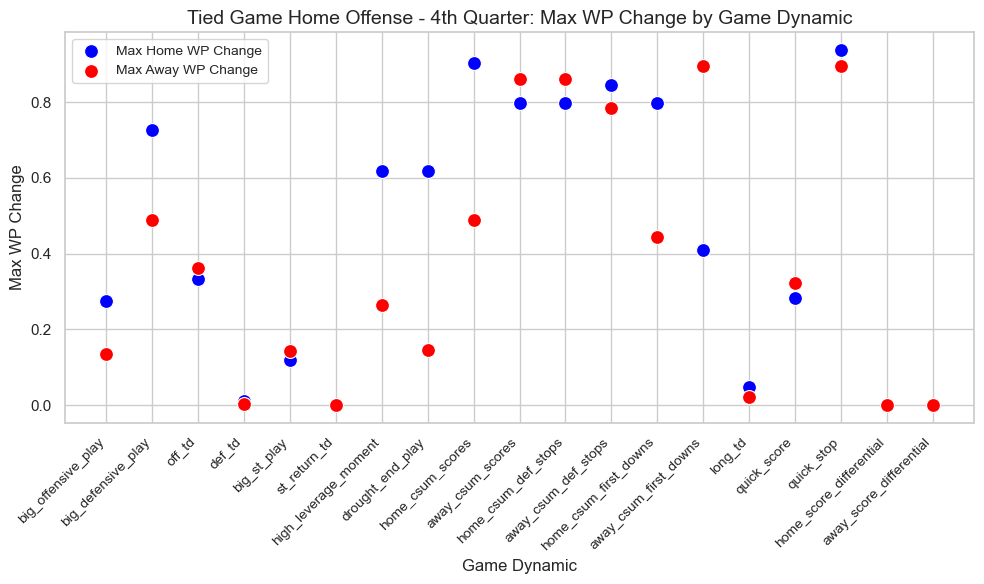


Tied Game Home Offense - 4th Quarter: Sorted Game Dynamics by Mean WP Changes
Home WP Changes:
quick_stop: 0.938
home_csum_scores: 0.903
away_csum_def_stops: 0.845
away_csum_scores: 0.799
home_csum_first_downs: 0.799
home_csum_def_stops: 0.799
big_defensive_play: 0.728
high_leverage_moment: 0.619
drought_end_play: 0.619
away_csum_first_downs: 0.409
off_td: 0.334
quick_score: 0.284
big_offensive_play: 0.274
big_st_play: 0.118
long_td: 0.048
def_td: 0.012
st_return_td: 0.000
home_score_differential: 0.000
away_score_differential: 0.000

Away WP Changes:
away_csum_first_downs: 0.897
quick_stop: 0.897
away_csum_scores: 0.861
home_csum_def_stops: 0.861
away_csum_def_stops: 0.786
home_csum_scores: 0.489
big_defensive_play: 0.489
home_csum_first_downs: 0.443
off_td: 0.361
quick_score: 0.323
high_leverage_moment: 0.265
drought_end_play: 0.144
big_st_play: 0.143
big_offensive_play: 0.135
long_td: 0.021
def_td: 0.003
st_return_td: 0.000
home_score_differential: 0.000
away_score_differential: 0.

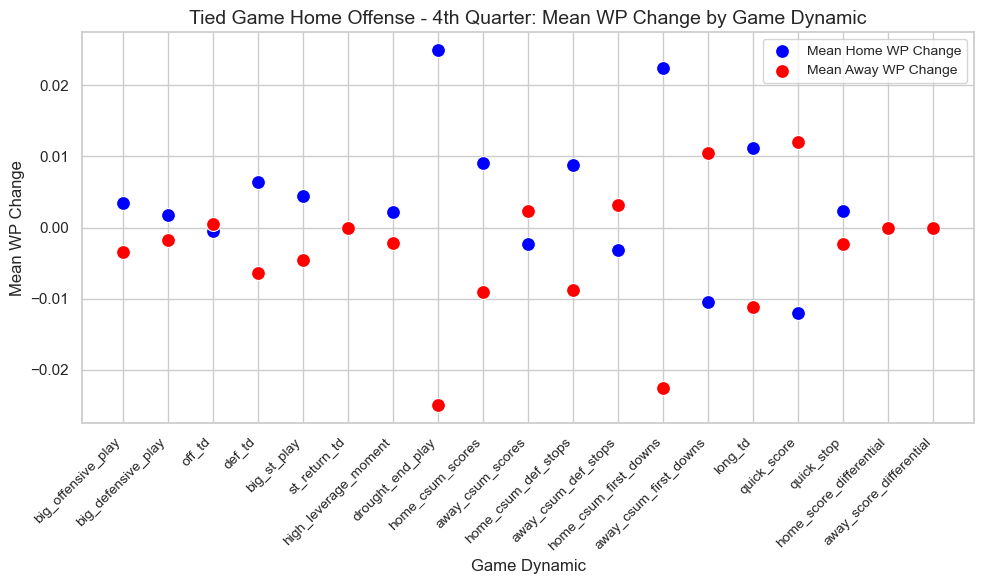


Tied Game Home Defense - 4th Quarter: Sorted Game Dynamics by Max WP Changes
Home WP Changes:
quick_stop: 0.938
home_csum_scores: 0.903
away_csum_def_stops: 0.845
away_csum_scores: 0.799
home_csum_first_downs: 0.799
home_csum_def_stops: 0.799
big_defensive_play: 0.728
high_leverage_moment: 0.619
drought_end_play: 0.619
away_csum_first_downs: 0.409
off_td: 0.334
quick_score: 0.284
big_offensive_play: 0.274
big_st_play: 0.118
long_td: 0.048
def_td: 0.012
st_return_td: 0.000
home_score_differential: 0.000
away_score_differential: 0.000

Away WP Changes:
away_csum_first_downs: 0.897
quick_stop: 0.897
away_csum_scores: 0.861
home_csum_def_stops: 0.861
away_csum_def_stops: 0.786
home_csum_scores: 0.489
big_defensive_play: 0.489
home_csum_first_downs: 0.443
off_td: 0.361
quick_score: 0.323
high_leverage_moment: 0.265
drought_end_play: 0.144
big_st_play: 0.143
big_offensive_play: 0.135
long_td: 0.021
def_td: 0.003
st_return_td: 0.000
home_score_differential: 0.000
away_score_differential: 0.0

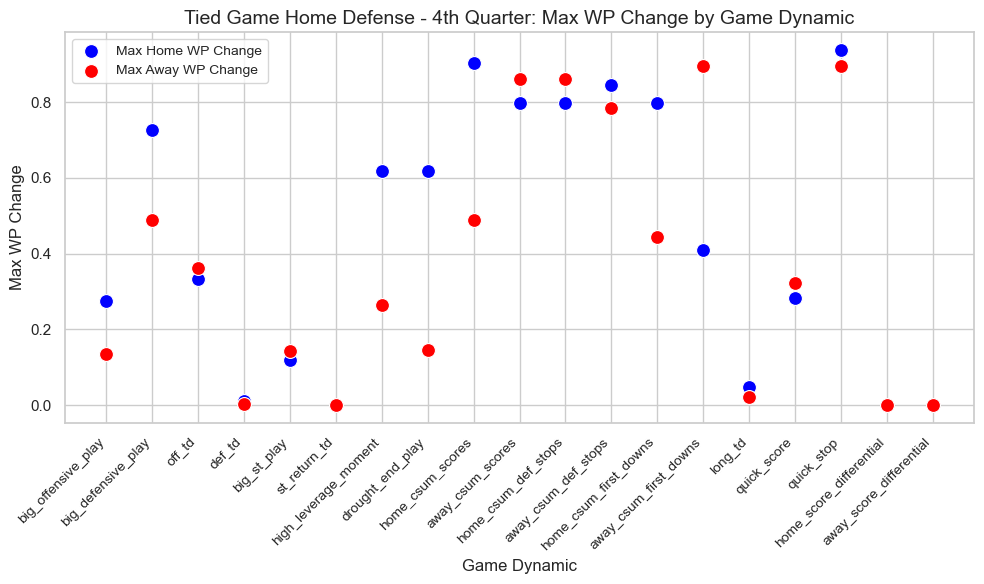


Tied Game Home Defense - 4th Quarter: Sorted Game Dynamics by Mean WP Changes
Home WP Changes:
quick_stop: 0.938
home_csum_scores: 0.903
away_csum_def_stops: 0.845
away_csum_scores: 0.799
home_csum_first_downs: 0.799
home_csum_def_stops: 0.799
big_defensive_play: 0.728
high_leverage_moment: 0.619
drought_end_play: 0.619
away_csum_first_downs: 0.409
off_td: 0.334
quick_score: 0.284
big_offensive_play: 0.274
big_st_play: 0.118
long_td: 0.048
def_td: 0.012
st_return_td: 0.000
home_score_differential: 0.000
away_score_differential: 0.000

Away WP Changes:
away_csum_first_downs: 0.897
quick_stop: 0.897
away_csum_scores: 0.861
home_csum_def_stops: 0.861
away_csum_def_stops: 0.786
home_csum_scores: 0.489
big_defensive_play: 0.489
home_csum_first_downs: 0.443
off_td: 0.361
quick_score: 0.323
high_leverage_moment: 0.265
drought_end_play: 0.144
big_st_play: 0.143
big_offensive_play: 0.135
long_td: 0.021
def_td: 0.003
st_return_td: 0.000
home_score_differential: 0.000
away_score_differential: 0.

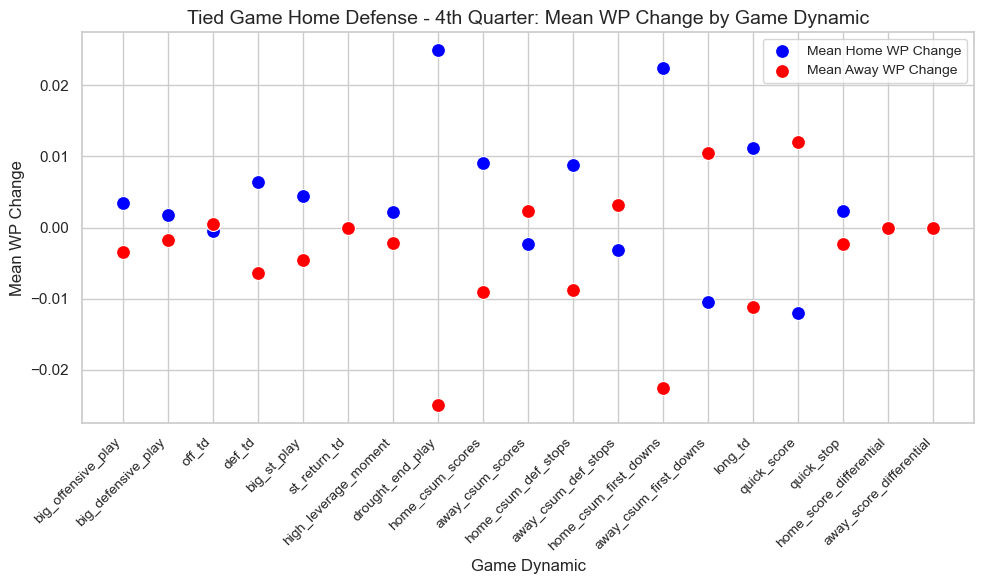


Tied Game Away Offense - 4th Quarter: Sorted Game Dynamics by Max WP Changes
Home WP Changes:
quick_stop: 0.938
home_csum_scores: 0.903
away_csum_def_stops: 0.845
away_csum_scores: 0.799
home_csum_first_downs: 0.799
home_csum_def_stops: 0.799
big_defensive_play: 0.728
high_leverage_moment: 0.619
drought_end_play: 0.619
away_csum_first_downs: 0.409
off_td: 0.334
quick_score: 0.284
big_offensive_play: 0.274
big_st_play: 0.118
long_td: 0.048
def_td: 0.012
st_return_td: 0.000
home_score_differential: 0.000
away_score_differential: 0.000

Away WP Changes:
away_csum_first_downs: 0.897
quick_stop: 0.897
away_csum_scores: 0.861
home_csum_def_stops: 0.861
away_csum_def_stops: 0.786
home_csum_scores: 0.489
big_defensive_play: 0.489
home_csum_first_downs: 0.443
off_td: 0.361
quick_score: 0.323
high_leverage_moment: 0.265
drought_end_play: 0.144
big_st_play: 0.143
big_offensive_play: 0.135
long_td: 0.021
def_td: 0.003
st_return_td: 0.000
home_score_differential: 0.000
away_score_differential: 0.0

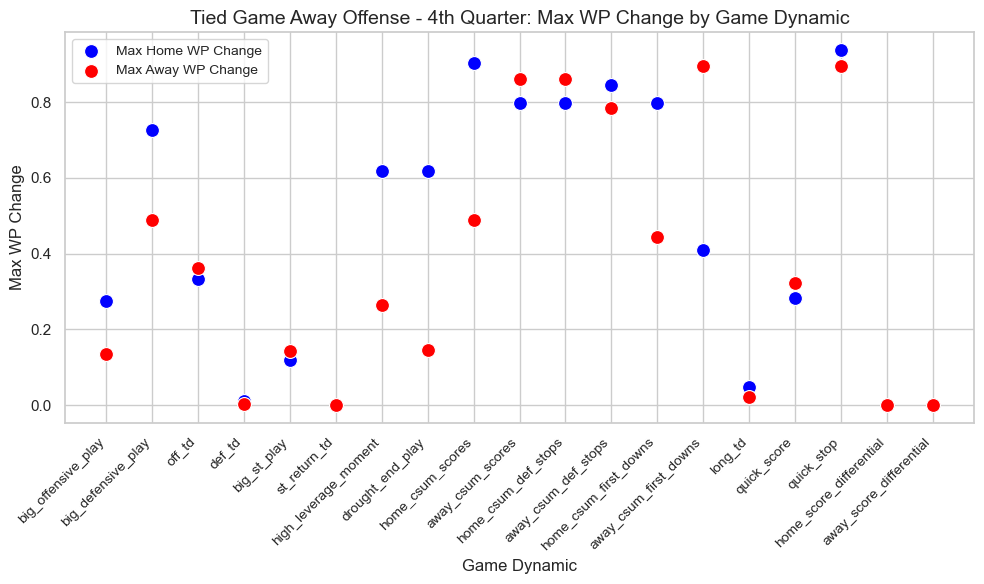


Tied Game Away Offense - 4th Quarter: Sorted Game Dynamics by Mean WP Changes
Home WP Changes:
quick_stop: 0.938
home_csum_scores: 0.903
away_csum_def_stops: 0.845
away_csum_scores: 0.799
home_csum_first_downs: 0.799
home_csum_def_stops: 0.799
big_defensive_play: 0.728
high_leverage_moment: 0.619
drought_end_play: 0.619
away_csum_first_downs: 0.409
off_td: 0.334
quick_score: 0.284
big_offensive_play: 0.274
big_st_play: 0.118
long_td: 0.048
def_td: 0.012
st_return_td: 0.000
home_score_differential: 0.000
away_score_differential: 0.000

Away WP Changes:
away_csum_first_downs: 0.897
quick_stop: 0.897
away_csum_scores: 0.861
home_csum_def_stops: 0.861
away_csum_def_stops: 0.786
home_csum_scores: 0.489
big_defensive_play: 0.489
home_csum_first_downs: 0.443
off_td: 0.361
quick_score: 0.323
high_leverage_moment: 0.265
drought_end_play: 0.144
big_st_play: 0.143
big_offensive_play: 0.135
long_td: 0.021
def_td: 0.003
st_return_td: 0.000
home_score_differential: 0.000
away_score_differential: 0.

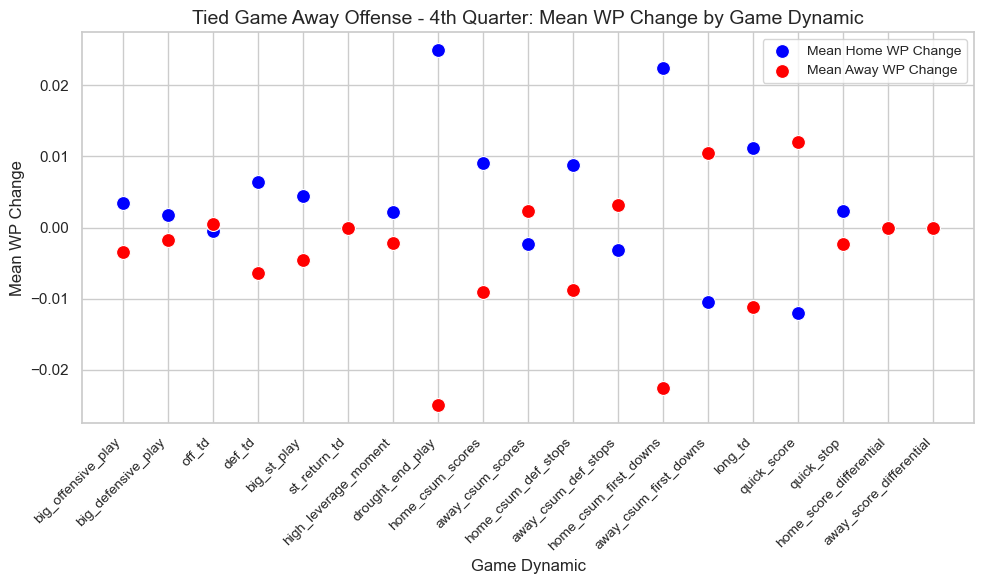


Tied Game Away Defense - 4th Quarter: Sorted Game Dynamics by Max WP Changes
Home WP Changes:
quick_stop: 0.938
home_csum_scores: 0.903
away_csum_def_stops: 0.845
away_csum_scores: 0.799
home_csum_first_downs: 0.799
home_csum_def_stops: 0.799
big_defensive_play: 0.728
high_leverage_moment: 0.619
drought_end_play: 0.619
away_csum_first_downs: 0.409
off_td: 0.334
quick_score: 0.284
big_offensive_play: 0.274
big_st_play: 0.118
long_td: 0.048
def_td: 0.012
st_return_td: 0.000
home_score_differential: 0.000
away_score_differential: 0.000

Away WP Changes:
away_csum_first_downs: 0.897
quick_stop: 0.897
away_csum_scores: 0.861
home_csum_def_stops: 0.861
away_csum_def_stops: 0.786
home_csum_scores: 0.489
big_defensive_play: 0.489
home_csum_first_downs: 0.443
off_td: 0.361
quick_score: 0.323
high_leverage_moment: 0.265
drought_end_play: 0.144
big_st_play: 0.143
big_offensive_play: 0.135
long_td: 0.021
def_td: 0.003
st_return_td: 0.000
home_score_differential: 0.000
away_score_differential: 0.0

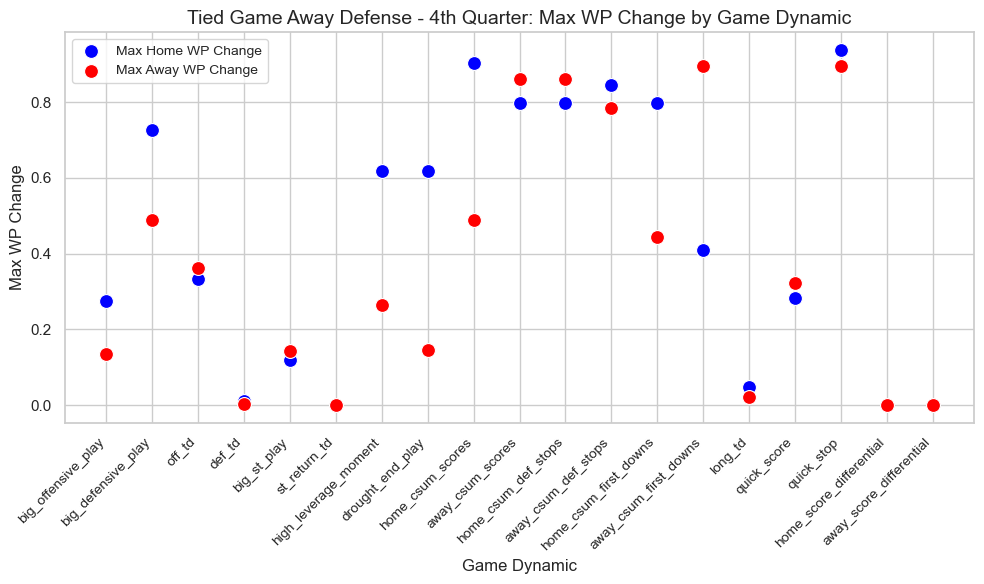


Tied Game Away Defense - 4th Quarter: Sorted Game Dynamics by Mean WP Changes
Home WP Changes:
quick_stop: 0.938
home_csum_scores: 0.903
away_csum_def_stops: 0.845
away_csum_scores: 0.799
home_csum_first_downs: 0.799
home_csum_def_stops: 0.799
big_defensive_play: 0.728
high_leverage_moment: 0.619
drought_end_play: 0.619
away_csum_first_downs: 0.409
off_td: 0.334
quick_score: 0.284
big_offensive_play: 0.274
big_st_play: 0.118
long_td: 0.048
def_td: 0.012
st_return_td: 0.000
home_score_differential: 0.000
away_score_differential: 0.000

Away WP Changes:
away_csum_first_downs: 0.897
quick_stop: 0.897
away_csum_scores: 0.861
home_csum_def_stops: 0.861
away_csum_def_stops: 0.786
home_csum_scores: 0.489
big_defensive_play: 0.489
home_csum_first_downs: 0.443
off_td: 0.361
quick_score: 0.323
high_leverage_moment: 0.265
drought_end_play: 0.144
big_st_play: 0.143
big_offensive_play: 0.135
long_td: 0.021
def_td: 0.003
st_return_td: 0.000
home_score_differential: 0.000
away_score_differential: 0.

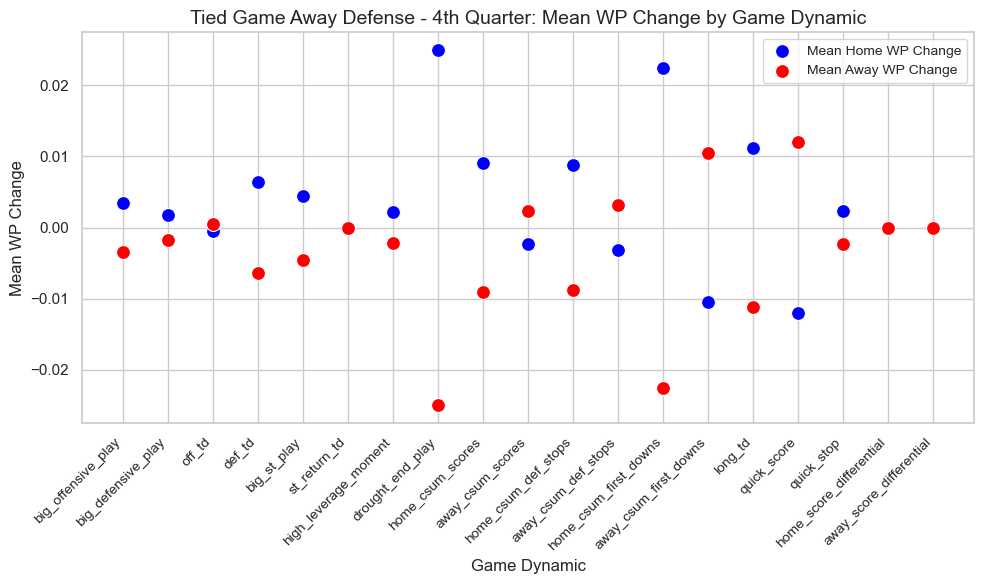

In [10]:
scoring_ranges = {
    'Tied Game Home Offense - 4th Quarter': (dfV5['away_score_differential'] == 0) & (dfV5['qtr'] == 4) & (dfV5['posteam'] != 'away_team'),
    'Tied Game Home Defense - 4th Quarter': (dfV5['away_score_differential'] == 0) & (dfV5['qtr'] == 4) & (dfV5['posteam'] != 'home_team'),
    'Tied Game Away Offense - 4th Quarter': (dfV5['away_score_differential'] == 0) & (dfV5['qtr'] == 4) & (dfV5['posteam'] != 'home_team'),
    'Tied Game Away Defense - 4th Quarter': (dfV5['away_score_differential'] == 0) & (dfV5['qtr'] == 4) & (dfV5['posteam'] != 'away_team')
}

all_dynamics = wp_change_analysis_df['game_dynamic'].unique()

for range_label, condition in scoring_ranges.items():
    range_df = dfV5[condition]
    wp_change_analysis = {}
    for dynamic_name, mask in dynamics: 
        wp_change_analysis[dynamic_name] = {
            'mean_home_wp_change': range_df.loc[mask, 'home_wp_change'].mean(),
            'max_home_wp_change': range_df.loc[mask, 'home_wp_change'].max(),
            'mean_away_wp_change': range_df.loc[mask, 'away_wp_change'].mean(),
            'max_away_wp_change': range_df.loc[mask, 'away_wp_change'].max(),
            'count': mask.sum(),
        }
    
    range_analysis_df = pd.DataFrame(wp_change_analysis).T.reset_index()
    range_analysis_df.columns = [
        'game_dynamic',
        'mean_home_wp_change',
        'max_home_wp_change',
        'mean_away_wp_change',
        'max_away_wp_change',
        'count',
    ]
    
    range_analysis_df = range_analysis_df.set_index('game_dynamic').reindex(all_dynamics).reset_index()
    range_analysis_df.fillna(0, inplace=True)
    
    sorted_home_wp = range_analysis_df[['game_dynamic', 'max_home_wp_change']].sort_values(
        by='max_home_wp_change', ascending=False
    ).reset_index(drop=True)
    
    sorted_away_wp = range_analysis_df[['game_dynamic', 'max_away_wp_change']].sort_values(
        by='max_away_wp_change', ascending=False
    ).reset_index(drop=True)

    print(f"\n{range_label}: Sorted Game Dynamics by Max WP Changes")
    print("Home WP Changes:")
    for dynamic, max_value in sorted_home_wp.values:
        print(f"{dynamic}: {max_value:.3f}")
    
    print("\nAway WP Changes:")
    for dynamic, max_value in sorted_away_wp.values:
        print(f"{dynamic}: {max_value:.3f}")
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='game_dynamic',
        y='max_home_wp_change',
        data=range_analysis_df,
        color='blue',
        s=100,
        label='Max Home WP Change',
    )
    sns.scatterplot(
        x='game_dynamic',
        y='max_away_wp_change',
        data=range_analysis_df,
        color='red',
        s=100,
        label='Max Away WP Change',
    )
    
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.xlabel('Game Dynamic', fontsize=12)
    plt.ylabel('Max WP Change', fontsize=12)
    plt.title(f'{range_label}: Max WP Change by Game Dynamic', fontsize=14)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

    print(f"\n{range_label}: Sorted Game Dynamics by Mean WP Changes")
    print("Home WP Changes:")
    for dynamic, mean_value in sorted_home_wp.values:
        print(f"{dynamic}: {mean_value:.3f}")
    
    print("\nAway WP Changes:")
    for dynamic, mean_value in sorted_away_wp.values:
        print(f"{dynamic}: {mean_value:.3f}")

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='game_dynamic',
        y='mean_home_wp_change',
        data=range_analysis_df,
        color='blue',
        s=100,
        label='Mean Home WP Change',
    )
    sns.scatterplot(
        x='game_dynamic',
        y='mean_away_wp_change',
        data=range_analysis_df,
        color='red',
        s=100,
        label='Mean Away WP Change',
    )
    
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.xlabel('Game Dynamic', fontsize=12)
    plt.ylabel('Mean WP Change', fontsize=12)
    plt.title(f'{range_label}: Mean WP Change by Game Dynamic', fontsize=14)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

# Investigating streaks - Stops, Scores, First downs, drought ending scores - Should be done in a game within 3 scores
# Investigating big/fast plays - Big offensive, big defensive, quick score, quick stop, long td - check during tie games

# Consecutive Stops


2 Consecutive Stops: Max WP Changes
Home Max WP Change: 0.905
Away Max WP Change: 0.900


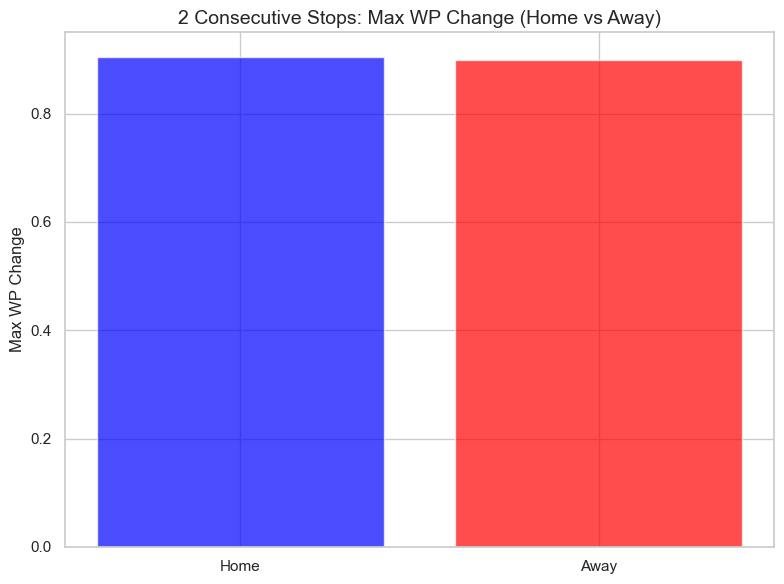


2 Consecutive Stops: Mean WP Changes
Home Mean WP Change: 0.003
Away Mean WP Change: 0.002


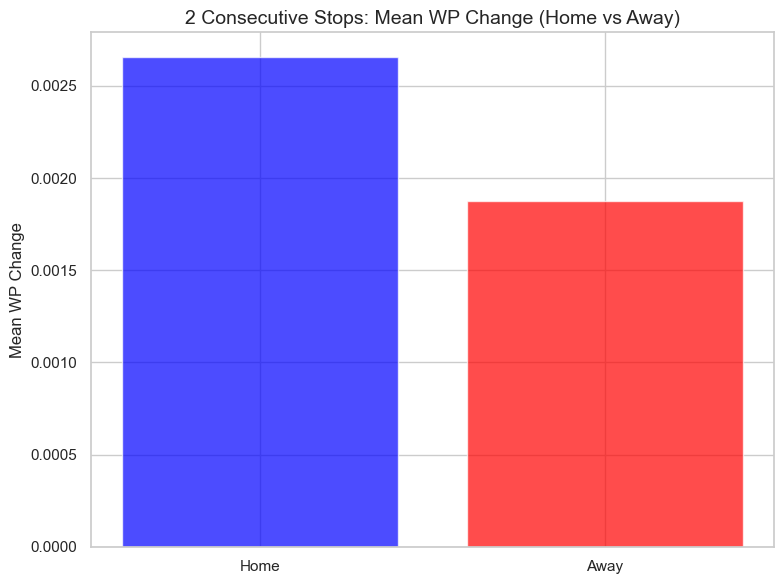


3 Consecutive Stops: Max WP Changes
Home Max WP Change: 0.938
Away Max WP Change: 0.846


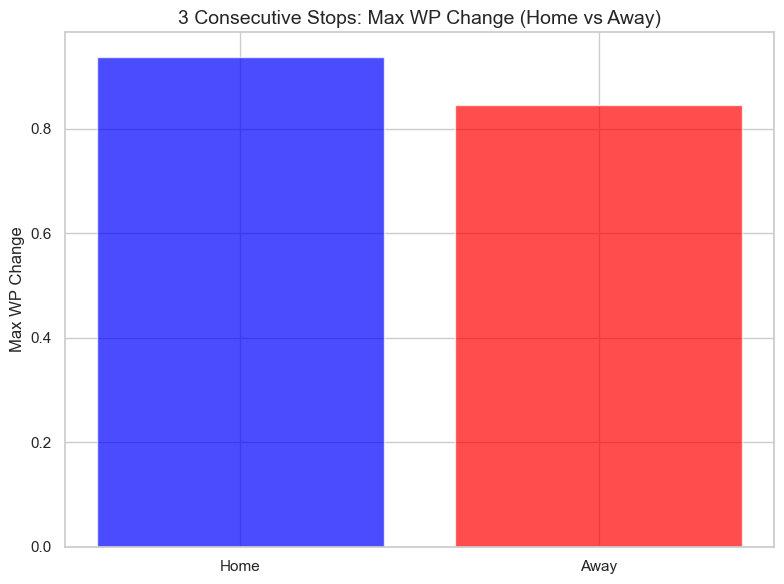


3 Consecutive Stops: Mean WP Changes
Home Mean WP Change: 0.002
Away Mean WP Change: 0.002


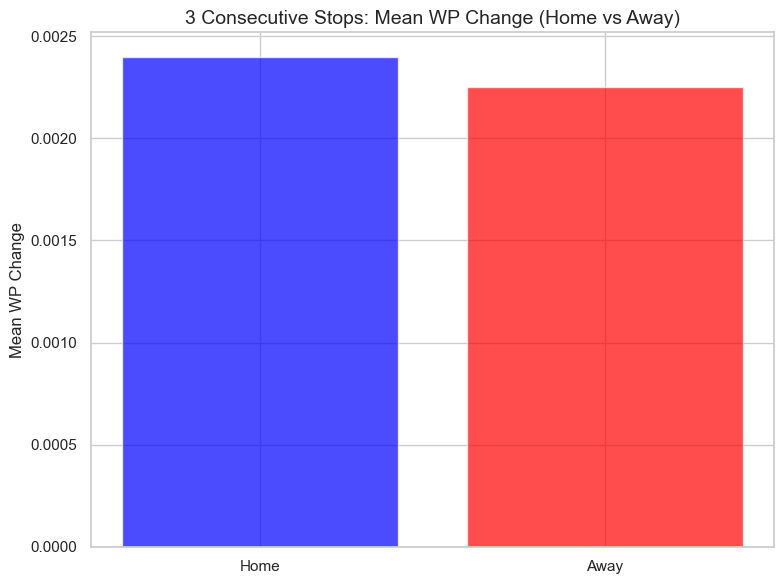


4 or More Consecutive Stops: Max WP Changes
Home Max WP Change: 0.845
Away Max WP Change: 0.897


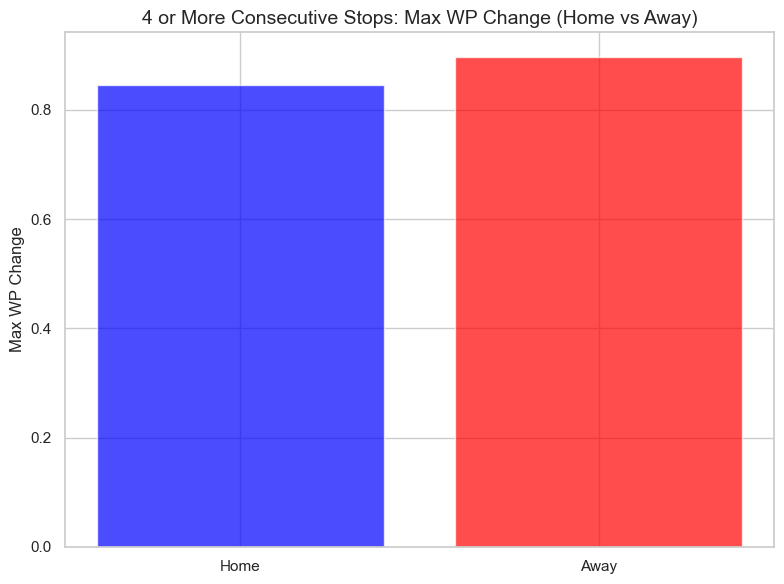


4 or More Consecutive Stops: Mean WP Changes
Home Mean WP Change: 0.002
Away Mean WP Change: 0.002


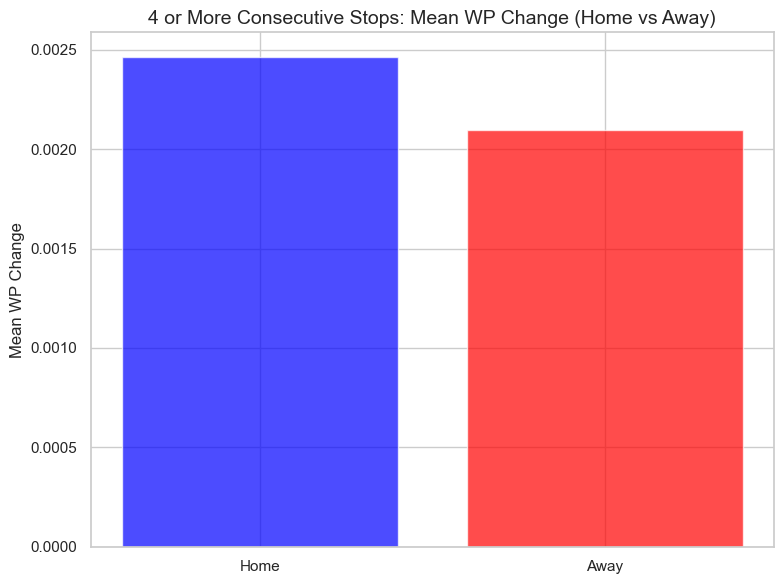

In [13]:
scoring_ranges = {
    '2 Consecutive Stops': {
        'home_condition': (dfV5['home_score_differential'] <= 24) & (dfV5['home_csum_def_stops'] == 2),
        'away_condition': (dfV5['away_score_differential'] <= 24) & (dfV5['away_csum_def_stops'] == 2),
    },
    '3 Consecutive Stops': {
        'home_condition': (dfV5['home_score_differential'] <= 24) & (dfV5['home_csum_def_stops'] == 3),
        'away_condition': (dfV5['away_score_differential'] <= 24) & (dfV5['away_csum_def_stops'] == 3),
    },
    '4 or More Consecutive Stops': {
        'home_condition': (dfV5['home_score_differential'] <= 24) & (dfV5['home_csum_def_stops'] >= 4),
        'away_condition': (dfV5['away_score_differential'] <= 24) & (dfV5['away_csum_def_stops'] >= 4),
    },
}

for range_label, conditions in scoring_ranges.items():
    # Filter data for each condition
    home_range_df = dfV5[conditions['home_condition']]
    away_range_df = dfV5[conditions['away_condition']]
    
    # Calculate Max WP Changes
    max_home_wp_change = home_range_df['home_wp_change'].max()
    max_away_wp_change = away_range_df['away_wp_change'].max()
    
    # Print Max WP Changes
    print(f"\n{range_label}: Max WP Changes")
    print(f"Home Max WP Change: {max_home_wp_change:.3f}")
    print(f"Away Max WP Change: {max_away_wp_change:.3f}")
    
    # Plot Max WP Changes
    plt.figure(figsize=(8, 6))
    plt.bar(['Home', 'Away'], [max_home_wp_change, max_away_wp_change], color=['blue', 'red'], alpha=0.7)
    plt.ylabel('Max WP Change', fontsize=12)
    plt.title(f'{range_label}: Max WP Change (Home vs Away)', fontsize=14)
    plt.tight_layout()
    plt.show()

    # Calculate Mean WP Changes
    mean_home_wp_change = home_range_df['home_wp_change'].mean()
    mean_away_wp_change = away_range_df['away_wp_change'].mean()
    
    # Print Mean WP Changes
    print(f"\n{range_label}: Mean WP Changes")
    print(f"Home Mean WP Change: {mean_home_wp_change:.3f}")
    print(f"Away Mean WP Change: {mean_away_wp_change:.3f}")
    
    # Plot Mean WP Changes
    plt.figure(figsize=(8, 6))
    plt.bar(['Home', 'Away'], [mean_home_wp_change, mean_away_wp_change], color=['blue', 'red'], alpha=0.7)
    plt.ylabel('Mean WP Change', fontsize=12)
    plt.title(f'{range_label}: Mean WP Change (Home vs Away)', fontsize=14)
    plt.tight_layout()
    plt.show()

# Consecutive scores - 2, 3, 4 or more


2 Consecutive Scores: Max WP Changes
Home Max WP Change: 0.938
Away Max WP Change: 0.897


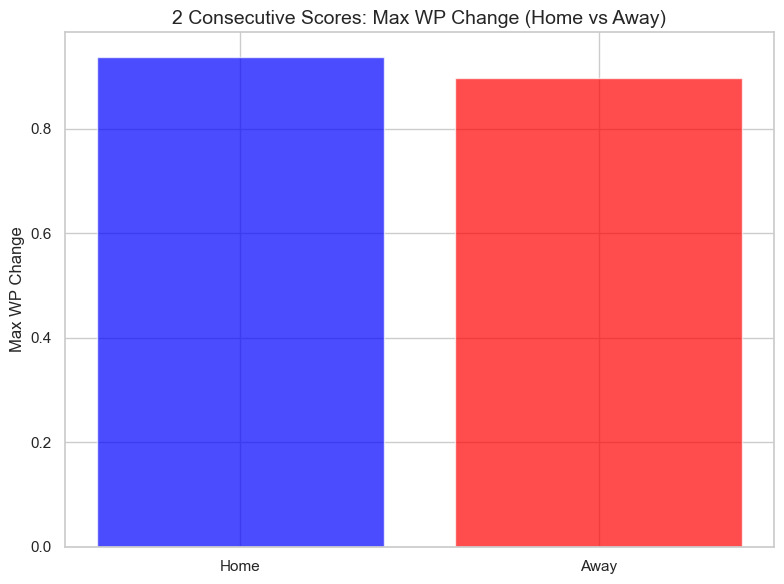


2 Consecutive Scores: Mean WP Changes
Home Mean WP Change: 0.002
Away Mean WP Change: 0.002


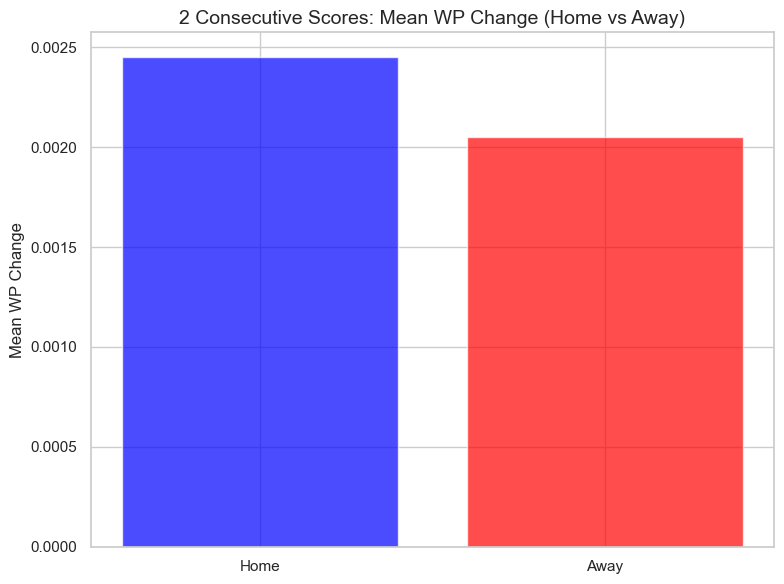


3 Consecutive Scores: Max WP Changes
Home Max WP Change: 0.682
Away Max WP Change: 0.606


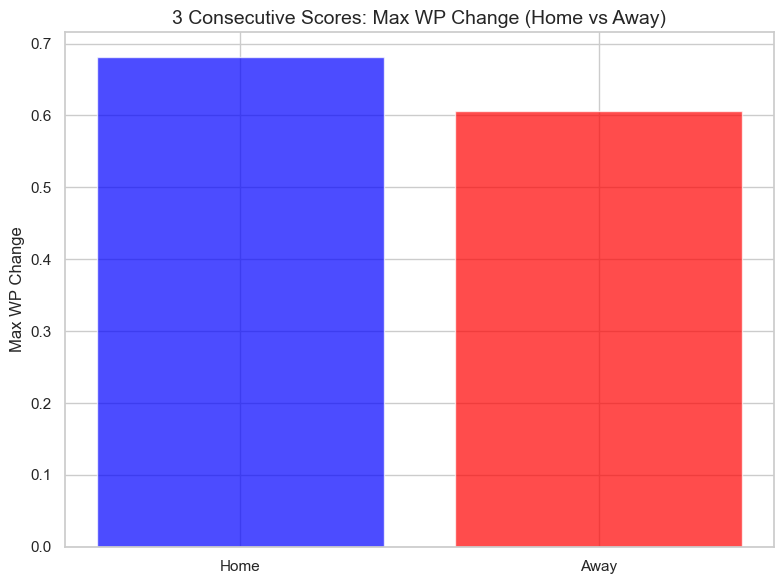


3 Consecutive Scores: Mean WP Changes
Home Mean WP Change: 0.002
Away Mean WP Change: 0.002


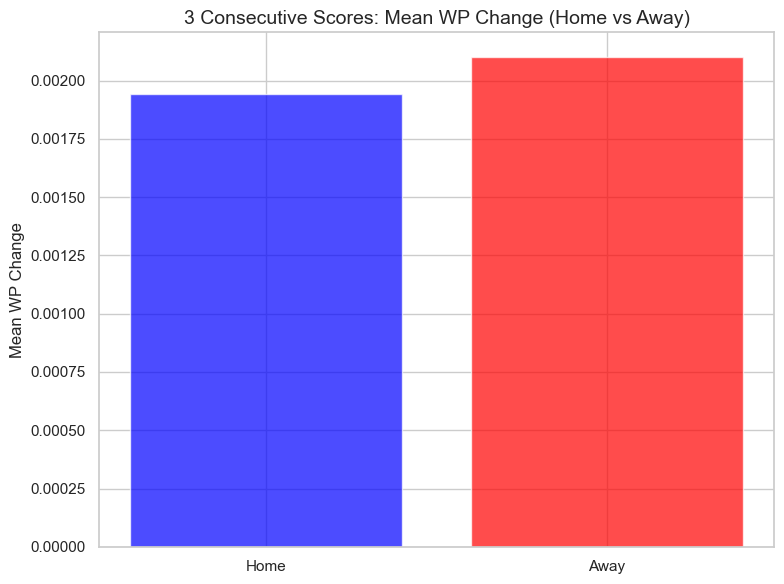


4 or More Consecutive Scores: Max WP Changes
Home Max WP Change: 0.870
Away Max WP Change: 0.642


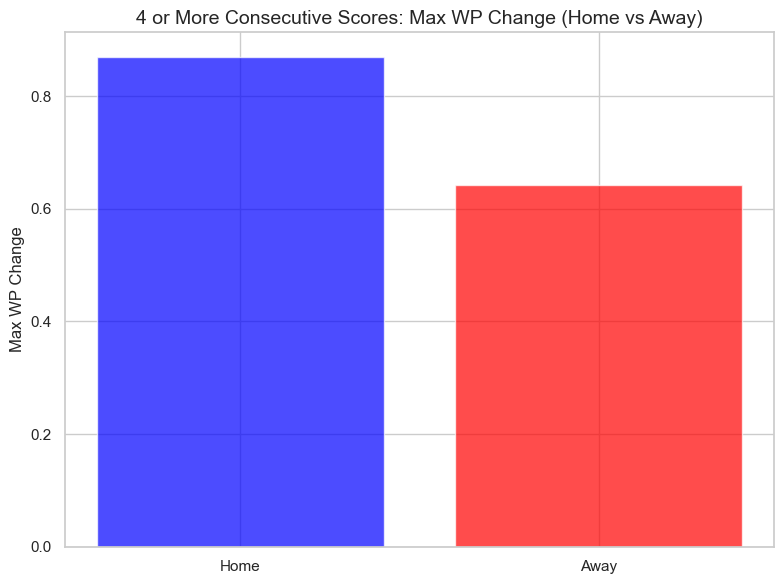


4 or More Consecutive Scores: Mean WP Changes
Home Mean WP Change: 0.001
Away Mean WP Change: 0.001


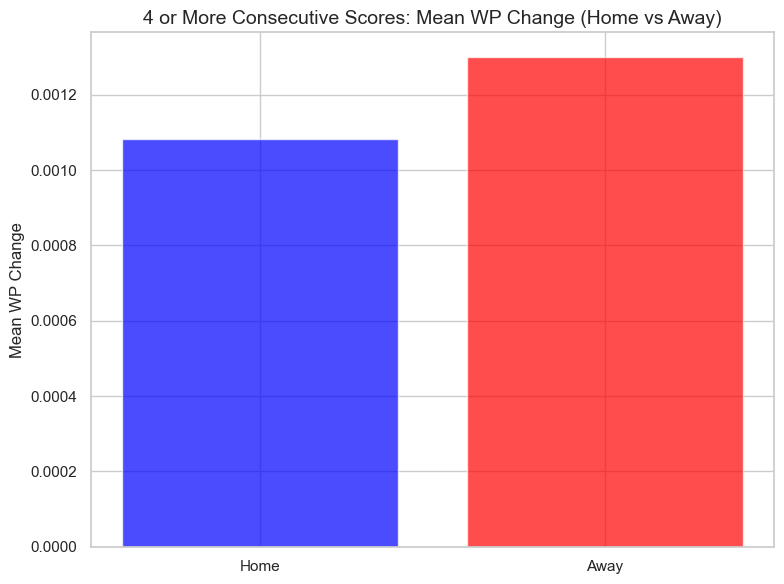

In [14]:
scoring_ranges = {
    '2 Consecutive Scores': {
        'home_condition': (dfV5['home_csum_scores'] == 2),
        'away_condition': (dfV5['away_csum_scores'] == 2)
    },
    '3 Consecutive Scores': {
        'home_condition': (dfV5['home_csum_scores'] == 3),
        'away_condition': (dfV5['away_csum_scores'] == 3)
    },
    '4 or More Consecutive Scores': {
        'home_condition': (dfV5['home_csum_scores'] >= 4),
        'away_condition': (dfV5['away_csum_scores'] >= 4)
    },
}

for range_label, conditions in scoring_ranges.items():
    # Filter data for each condition
    home_range_df = dfV5[conditions['home_condition']]
    away_range_df = dfV5[conditions['away_condition']]
    
    # Calculate Max WP Changes
    max_home_wp_change = home_range_df['home_wp_change'].max()
    max_away_wp_change = away_range_df['away_wp_change'].max()
    
    # Print Max WP Changes
    print(f"\n{range_label}: Max WP Changes")
    print(f"Home Max WP Change: {max_home_wp_change:.3f}")
    print(f"Away Max WP Change: {max_away_wp_change:.3f}")
    
    # Plot Max WP Changes
    plt.figure(figsize=(8, 6))
    plt.bar(['Home', 'Away'], [max_home_wp_change, max_away_wp_change], color=['blue', 'red'], alpha=0.7)
    plt.ylabel('Max WP Change', fontsize=12)
    plt.title(f'{range_label}: Max WP Change (Home vs Away)', fontsize=14)
    plt.tight_layout()
    plt.show()

    # Calculate Mean WP Changes
    mean_home_wp_change = home_range_df['home_wp_change'].mean()
    mean_away_wp_change = away_range_df['away_wp_change'].mean()
    
    # Print Mean WP Changes
    print(f"\n{range_label}: Mean WP Changes")
    print(f"Home Mean WP Change: {mean_home_wp_change:.3f}")
    print(f"Away Mean WP Change: {mean_away_wp_change:.3f}")
    
    # Plot Mean WP Changes
    plt.figure(figsize=(8, 6))
    plt.bar(['Home', 'Away'], [mean_home_wp_change, mean_away_wp_change], color=['blue', 'red'], alpha=0.7)
    plt.ylabel('Mean WP Change', fontsize=12)
    plt.title(f'{range_label}: Mean WP Change (Home vs Away)', fontsize=14)
    plt.tight_layout()
    plt.show()

# Drought Ending Score

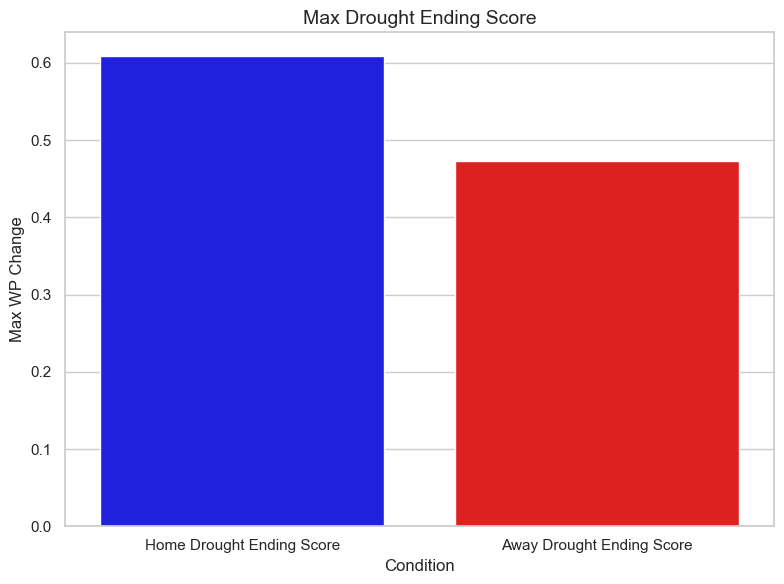

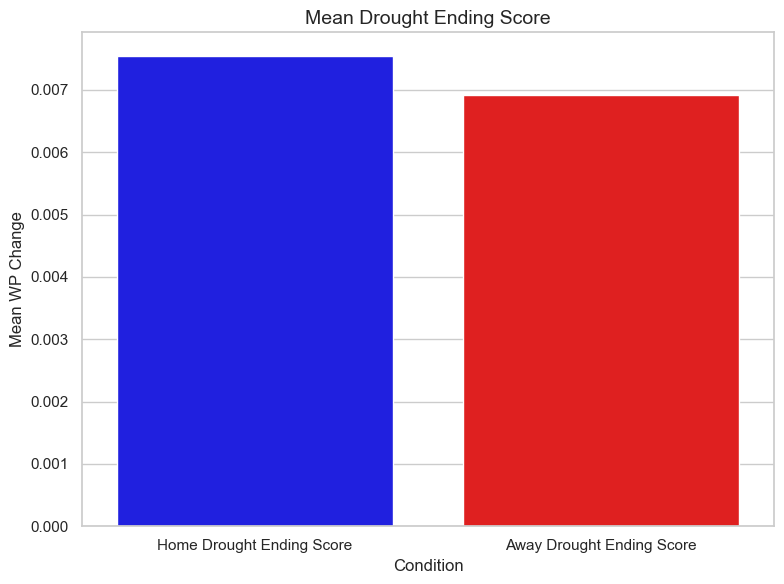

In [ ]:
max_wp_changes = []
mean_wp_changes = []

scoring_ranges = {
    'Home Drought Ending Score': (dfV5['home_td'] == 1) & (dfV5['away_csum_scores'].shift(1) >= 2),
    'Away Drought Ending Score': (dfV5['away_td'] == 1) & (dfV5['home_csum_scores'].shift(1) >= 2),
}

for range_label, condition in scoring_ranges.items():
    range_df = dfV5[condition]

    max_wp_change = range_df['home_wp_change'].max() if 'Home' in range_label else range_df['away_wp_change'].max()
    mean_wp_change = range_df['home_wp_change'].mean() if 'Home' in range_label else range_df['away_wp_change'].mean()
    
    max_wp_changes.append((range_label, max_wp_change))
    mean_wp_changes.append((range_label, mean_wp_change))


max_wp_df = pd.DataFrame(max_wp_changes, columns=['Condition', 'Max WP Change'])
mean_wp_df = pd.DataFrame(mean_wp_changes, columns=['Condition', 'Mean WP Change'])

plt.figure(figsize=(8, 6))
sns.barplot(x='Condition', y='Max WP Change', data=max_wp_df, palette=['blue', 'red'])
plt.title('Max Drought Ending Score', fontsize=14)
plt.ylabel('Max WP Change', fontsize=12)
plt.xlabel('Condition', fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.barplot(x='Condition', y='Mean WP Change', data=mean_wp_df, palette=['blue', 'red'])
plt.title('Mean Drought Ending Score', fontsize=14)
plt.ylabel('Mean WP Change', fontsize=12)
plt.xlabel('Condition', fontsize=12)
plt.tight_layout()
plt.show()

# Big Offensive Play

Max Win Probability Changes:
                 Condition  Max WP Change
0  Home Big Offensive Play       0.508971
1  Away Big Offensive Play       0.532064

Mean Win Probability Changes:
                 Condition  Mean WP Change
0  Home Big Offensive Play        0.058847
1  Away Big Offensive Play        0.061298


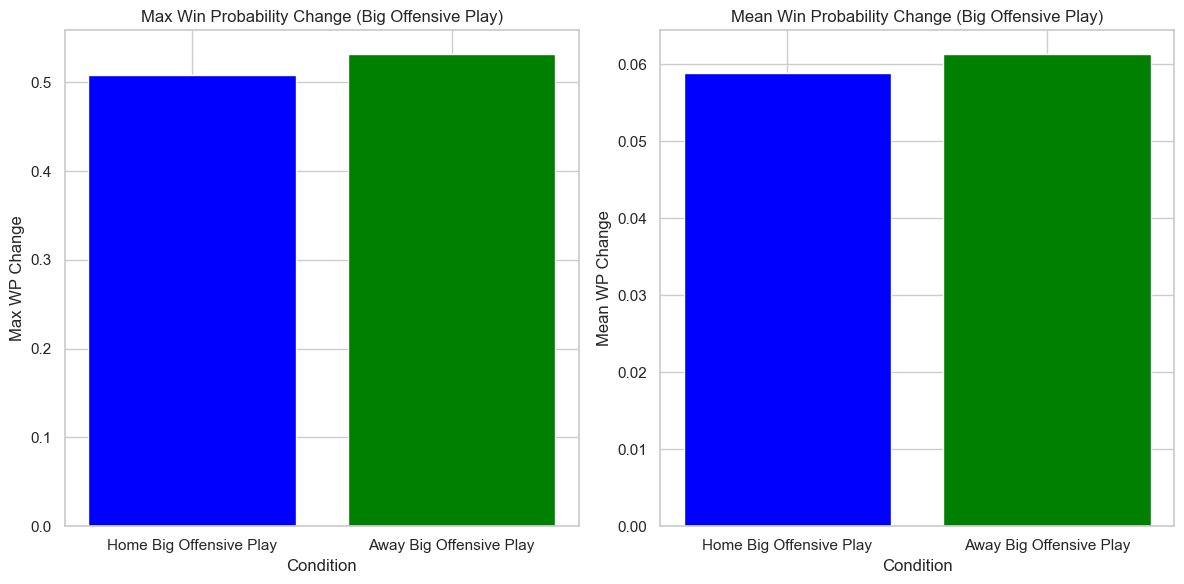

In [ ]:
scoring_ranges = {
    'Home Big Offensive Play': (dfV5['posteam'] != 'away_team') & (dfV5['home_score_differential'] == 0) & (dfV5['big_offensive_play'] == 1),
    'Away Big Offensive Play': (dfV5['posteam'] != 'home_team') & (dfV5['home_score_differential'] == 0) & (dfV5['big_offensive_play'] == 1)
}

max_wp_changes = []
mean_wp_changes = []

for range_label, condition in scoring_ranges.items():
    range_df = dfV5[condition]

    if 'Home' in range_label:
        range_df = range_df[range_df['home_wp_change'] >= 0]  
        max_wp_change = range_df['home_wp_change'].max()
        mean_wp_change = range_df['home_wp_change'].mean()
    else:
        range_df = range_df[range_df['away_wp_change'] >= 0]  
        max_wp_change = range_df['away_wp_change'].max()
        mean_wp_change = range_df['away_wp_change'].mean()
    
    max_wp_changes.append((range_label, max_wp_change))
    mean_wp_changes.append((range_label, mean_wp_change))

max_wp_df = pd.DataFrame(max_wp_changes, columns=['Condition', 'Max WP Change'])
mean_wp_df = pd.DataFrame(mean_wp_changes, columns=['Condition', 'Mean WP Change'])

print("Max Win Probability Changes:")
print(max_wp_df)
print("\nMean Win Probability Changes:")
print(mean_wp_df)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(max_wp_df['Condition'], max_wp_df['Max WP Change'], color=['blue', 'green'])
plt.title('Max Win Probability Change (Big Offensive Play)')
plt.xlabel('Condition')
plt.ylabel('Max WP Change')

plt.subplot(1, 2, 2)
plt.bar(mean_wp_df['Condition'], mean_wp_df['Mean WP Change'], color=['blue', 'green'])
plt.title('Mean Win Probability Change (Big Offensive Play)')
plt.xlabel('Condition')
plt.ylabel('Mean WP Change')

plt.tight_layout()
plt.show()

# Big Defensive Play

Max Win Probability Changes:
                 Condition  Max WP Change
0  Home Big Defensive Play       0.727836
1  Away Big Defensive Play       0.548547

Mean Win Probability Changes:
                 Condition  Mean WP Change
0  Home Big Defensive Play        0.043834
1  Away Big Defensive Play        0.051955


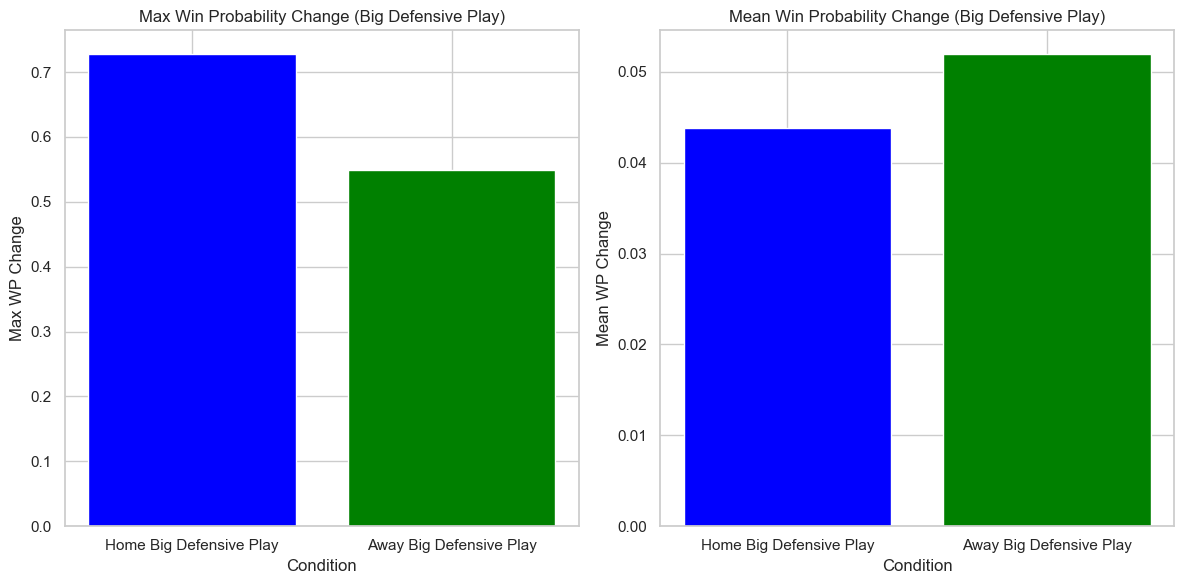

In [26]:
scoring_ranges = {
    'Home Big Defensive Play': (dfV5['posteam'] != 'away_team') & (dfV5['home_score_differential'] == 0) & (dfV5['big_defensive_play'] == 1),
    'Away Big Defensive Play': (dfV5['posteam'] != 'home_team') & (dfV5['home_score_differential'] == 0) & (dfV5['big_defensive_play'] == 1)
}

max_wp_changes = []
mean_wp_changes = []

for range_label, condition in scoring_ranges.items():
    range_df = dfV5[condition]

    if 'Home' in range_label:
        range_df = range_df[range_df['home_wp_change'] >= 0]  
        max_wp_change = range_df['home_wp_change'].max()
        mean_wp_change = range_df['home_wp_change'].mean()
    else:
        range_df = range_df[range_df['away_wp_change'] >= 0]  
        max_wp_change = range_df['away_wp_change'].max()
        mean_wp_change = range_df['away_wp_change'].mean()
    
    max_wp_changes.append((range_label, max_wp_change))
    mean_wp_changes.append((range_label, mean_wp_change))

max_wp_df = pd.DataFrame(max_wp_changes, columns=['Condition', 'Max WP Change'])
mean_wp_df = pd.DataFrame(mean_wp_changes, columns=['Condition', 'Mean WP Change'])

print("Max Win Probability Changes:")
print(max_wp_df)
print("\nMean Win Probability Changes:")
print(mean_wp_df)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(max_wp_df['Condition'], max_wp_df['Max WP Change'], color=['blue', 'green'])
plt.title('Max Win Probability Change (Big Defensive Play)')
plt.xlabel('Condition')
plt.ylabel('Max WP Change')

plt.subplot(1, 2, 2)
plt.bar(mean_wp_df['Condition'], mean_wp_df['Mean WP Change'], color=['blue', 'green'])
plt.title('Mean Win Probability Change (Big Defensive Play)')
plt.xlabel('Condition')
plt.ylabel('Mean WP Change')

plt.tight_layout()
plt.show()

# Quick Score

Max Win Probability Changes:
          Condition  Max WP Change
0  Home Quick Score       0.284275
1  Away Quick Score       0.322582

Mean Win Probability Changes:
          Condition  Mean WP Change
0  Home Quick Score        0.044974
1  Away Quick Score        0.049432


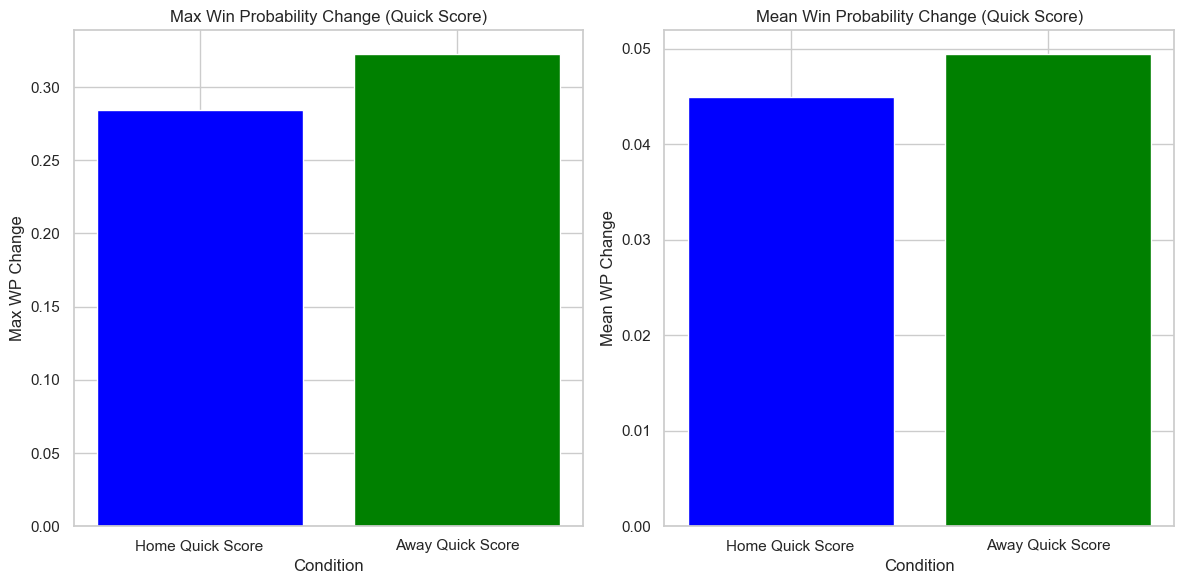

In [27]:
scoring_ranges = {
    'Home Quick Score': (dfV5['posteam'] != 'away_team') & (dfV5['home_score_differential'] == 0) & (dfV5['quick_score'] == 1),
    'Away Quick Score': (dfV5['posteam'] != 'home_team') & (dfV5['home_score_differential'] == 0) & (dfV5['quick_score'] == 1)
}

max_wp_changes = []
mean_wp_changes = []

for range_label, condition in scoring_ranges.items():
    range_df = dfV5[condition]

    if 'Home' in range_label:
        range_df = range_df[range_df['home_wp_change'] >= 0]  
        max_wp_change = range_df['home_wp_change'].max()
        mean_wp_change = range_df['home_wp_change'].mean()
    else:
        range_df = range_df[range_df['away_wp_change'] >= 0]  
        max_wp_change = range_df['away_wp_change'].max()
        mean_wp_change = range_df['away_wp_change'].mean()
    
    max_wp_changes.append((range_label, max_wp_change))
    mean_wp_changes.append((range_label, mean_wp_change))

max_wp_df = pd.DataFrame(max_wp_changes, columns=['Condition', 'Max WP Change'])
mean_wp_df = pd.DataFrame(mean_wp_changes, columns=['Condition', 'Mean WP Change'])

print("Max Win Probability Changes:")
print(max_wp_df)
print("\nMean Win Probability Changes:")
print(mean_wp_df)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(max_wp_df['Condition'], max_wp_df['Max WP Change'], color=['blue', 'green'])
plt.title('Max Win Probability Change (Quick Score)')
plt.xlabel('Condition')
plt.ylabel('Max WP Change')

plt.subplot(1, 2, 2)
plt.bar(mean_wp_df['Condition'], mean_wp_df['Mean WP Change'], color=['blue', 'green'])
plt.title('Mean Win Probability Change (Quick Score)')
plt.xlabel('Condition')
plt.ylabel('Mean WP Change')

plt.tight_layout()
plt.show()

# Quick Stop

Max Win Probability Changes:
         Condition  Max WP Change
0  Home Quick Stop       0.937904
1  Away Quick Stop       0.897181

Mean Win Probability Changes:
         Condition  Mean WP Change
0  Home Quick Stop        0.066331
1  Away Quick Stop        0.069489


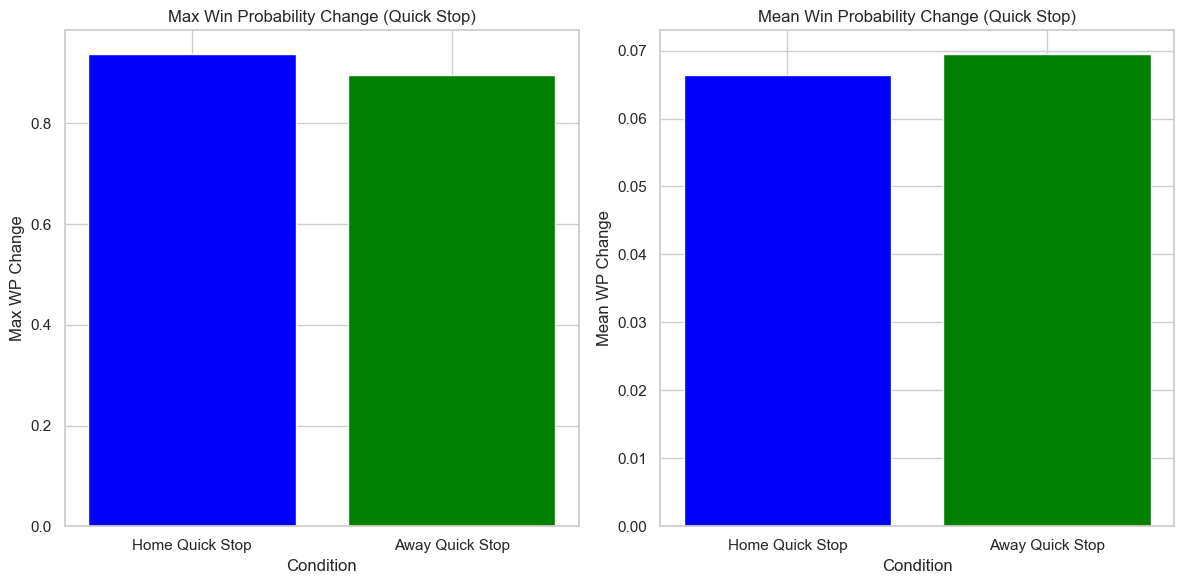

In [28]:
scoring_ranges = {
    'Home Quick Stop': (dfV5['posteam'] != 'home_team') & (dfV5['home_score_differential'] == 0) & (dfV5['quick_stop'] == 1),
    'Away Quick Stop': (dfV5['posteam'] != 'away_team') & (dfV5['home_score_differential'] == 0) & (dfV5['quick_stop'] == 1)
}

max_wp_changes = []
mean_wp_changes = []

for range_label, condition in scoring_ranges.items():
    range_df = dfV5[condition]

    if 'Home' in range_label:
        range_df = range_df[range_df['home_wp_change'] >= 0]  
        max_wp_change = range_df['home_wp_change'].max()
        mean_wp_change = range_df['home_wp_change'].mean()
    else:
        range_df = range_df[range_df['away_wp_change'] >= 0]  
        max_wp_change = range_df['away_wp_change'].max()
        mean_wp_change = range_df['away_wp_change'].mean()
    
    max_wp_changes.append((range_label, max_wp_change))
    mean_wp_changes.append((range_label, mean_wp_change))

max_wp_df = pd.DataFrame(max_wp_changes, columns=['Condition', 'Max WP Change'])
mean_wp_df = pd.DataFrame(mean_wp_changes, columns=['Condition', 'Mean WP Change'])

print("Max Win Probability Changes:")
print(max_wp_df)
print("\nMean Win Probability Changes:")
print(mean_wp_df)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(max_wp_df['Condition'], max_wp_df['Max WP Change'], color=['blue', 'green'])
plt.title('Max Win Probability Change (Quick Stop)')
plt.xlabel('Condition')
plt.ylabel('Max WP Change')

plt.subplot(1, 2, 2)
plt.bar(mean_wp_df['Condition'], mean_wp_df['Mean WP Change'], color=['blue', 'green'])
plt.title('Mean Win Probability Change (Quick Stop)')
plt.xlabel('Condition')
plt.ylabel('Mean WP Change')

plt.tight_layout()
plt.show()

# Long Touchdowns

Max Win Probability Changes:
      Condition  Max WP Change
0  Home Long TD       0.100651
1  Away Long TD       0.205254

Mean Win Probability Changes:
      Condition  Mean WP Change
0  Home Long TD        0.030673
1  Away Long TD        0.044413


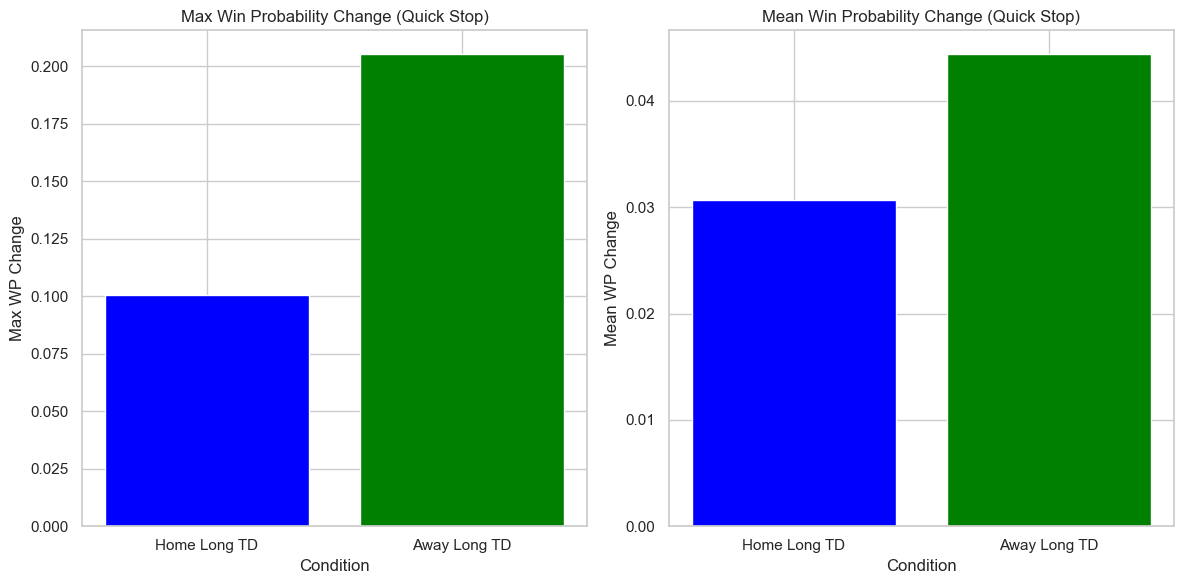

In [29]:
scoring_ranges = {
    'Home Long TD': (dfV5['posteam'] != 'away_team') & (dfV5['home_score_differential'] == 0) & (dfV5['long_td'] == 1),
    'Away Long TD': (dfV5['posteam'] != 'home_team') & (dfV5['home_score_differential'] == 0) & (dfV5['long_td'] == 1)
}

max_wp_changes = []
mean_wp_changes = []

for range_label, condition in scoring_ranges.items():
    range_df = dfV5[condition]

    if 'Home' in range_label:
        range_df = range_df[range_df['home_wp_change'] >= 0]  
        max_wp_change = range_df['home_wp_change'].max()
        mean_wp_change = range_df['home_wp_change'].mean()
    else:
        range_df = range_df[range_df['away_wp_change'] >= 0]  
        max_wp_change = range_df['away_wp_change'].max()
        mean_wp_change = range_df['away_wp_change'].mean()
    
    max_wp_changes.append((range_label, max_wp_change))
    mean_wp_changes.append((range_label, mean_wp_change))

max_wp_df = pd.DataFrame(max_wp_changes, columns=['Condition', 'Max WP Change'])
mean_wp_df = pd.DataFrame(mean_wp_changes, columns=['Condition', 'Mean WP Change'])

print("Max Win Probability Changes:")
print(max_wp_df)
print("\nMean Win Probability Changes:")
print(mean_wp_df)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(max_wp_df['Condition'], max_wp_df['Max WP Change'], color=['blue', 'green'])
plt.title('Max Win Probability Change (Quick Stop)')
plt.xlabel('Condition')
plt.ylabel('Max WP Change')

plt.subplot(1, 2, 2)
plt.bar(mean_wp_df['Condition'], mean_wp_df['Mean WP Change'], color=['blue', 'green'])
plt.title('Mean Win Probability Change (Quick Stop)')
plt.xlabel('Condition')
plt.ylabel('Mean WP Change')

plt.tight_layout()
plt.show()

# High Leverage First Downs

Max Win Probability Changes:
                   Condition  Max WP Change
0  Home High Leverage Moment       0.274259
1  Away High Leverage Moment       0.262460

Mean Win Probability Changes:
                   Condition  Mean WP Change
0  Home High Leverage Moment        0.031384
1  Away High Leverage Moment        0.029582


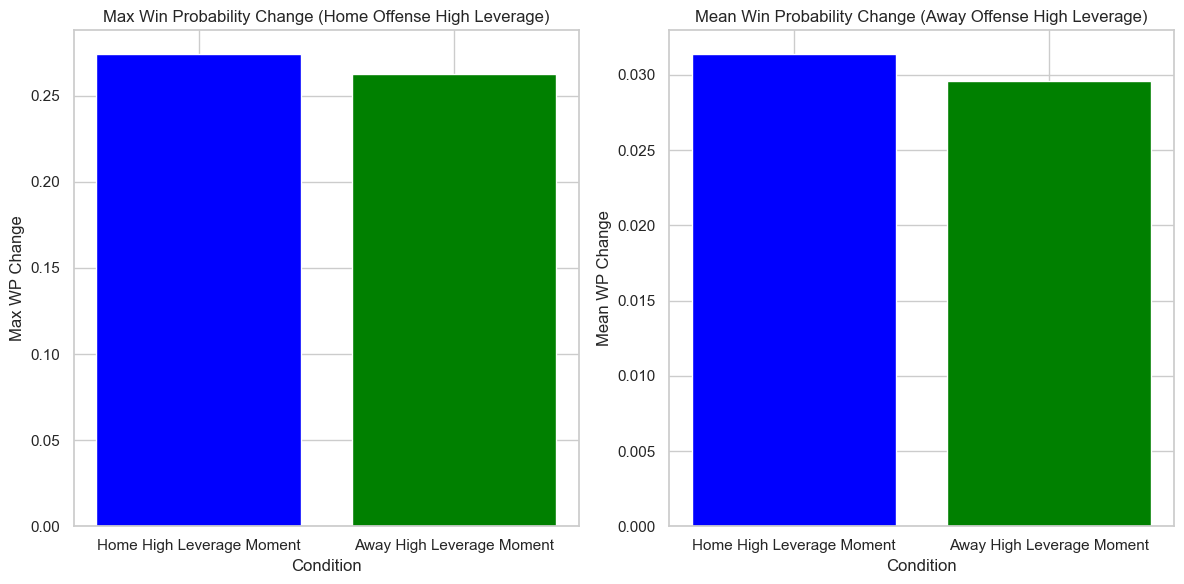

In [31]:
scoring_ranges = {
    'Home High Leverage Moment': (dfV5['posteam'] != 'away_team') & (dfV5['high_leverage_moment'] == 1) & (dfV5['yards_gained'] >= 10),
    'Away High Leverage Moment': (dfV5['posteam'] != 'home_team') & (dfV5['high_leverage_moment'] == 1) & (dfV5['yards_gained'] >= 10)
}

max_wp_changes = []
mean_wp_changes = []

for range_label, condition in scoring_ranges.items():
    range_df = dfV5[condition]

    if 'Home' in range_label:
        range_df = range_df[range_df['home_wp_change'] >= 0]  
        max_wp_change = range_df['home_wp_change'].max()
        mean_wp_change = range_df['home_wp_change'].mean()
    else:
        range_df = range_df[range_df['away_wp_change'] >= 0]  
        max_wp_change = range_df['away_wp_change'].max()
        mean_wp_change = range_df['away_wp_change'].mean()
    
    max_wp_changes.append((range_label, max_wp_change))
    mean_wp_changes.append((range_label, mean_wp_change))

max_wp_df = pd.DataFrame(max_wp_changes, columns=['Condition', 'Max WP Change'])
mean_wp_df = pd.DataFrame(mean_wp_changes, columns=['Condition', 'Mean WP Change'])

print("Max Win Probability Changes:")
print(max_wp_df)
print("\nMean Win Probability Changes:")
print(mean_wp_df)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(max_wp_df['Condition'], max_wp_df['Max WP Change'], color=['blue', 'green'])
plt.title('Max Win Probability Change (Home Offense High Leverage)')
plt.xlabel('Condition')
plt.ylabel('Max WP Change')

plt.subplot(1, 2, 2)
plt.bar(mean_wp_df['Condition'], mean_wp_df['Mean WP Change'], color=['blue', 'green'])
plt.title('Mean Win Probability Change (Away Offense High Leverage)')
plt.xlabel('Condition')
plt.ylabel('Mean WP Change')

plt.tight_layout()
plt.show()